In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai') 
import gdal
import numpy as np
import re
import os, io, re

# import image
train_path = './train_crowns/train_crowns/'
test_path = "./test_crowns/"
# filename を全て入れる
train_files = []
test_files = []
for filename in os.listdir(train_path):
    if os.path.isfile(os.path.join(train_path, filename)):
        train_files.append(filename)
for filename in os.listdir(test_path):
    if os.path.isfile(os.path.join(test_path, filename)):
        test_files.append(filename)

# .tifのファイルを選んで入れる
train_img = []
test_img= []
for name in train_files:
    if re.search(r"(.tif)$", name):
        train_img.append(name)
for name in test_files:
    if re.search(r"(.tif)$", name):
        test_img.append(name)
# print(img_files)

In [2]:
train_height = []
train_DBH = []
train_index = []
test_height = []
test_index = []

for imgfile in train_files:
    image = gdal.Open("C:/Users/owner/Kaggle/GE_Kaggle01/train_crowns/train_crowns/"+imgfile, gdal.GA_ReadOnly)
    a = np.array([image.GetRasterBand(i + 1).ReadAsArray() for i in range(image.RasterCount)])
    train_height.append(a[0<a].mean())
#     print(a[a>0].mean())
    file = os.path.splitext(imgfile)[0]
    file_split = [i for i in file.split("_")]
    train_index.append(file_split[0])
    train_DBH.append(float(file_split[3]))
#     print(float(file_split[3]))
    
for imgfile in test_files:
    image = gdal.Open("C:/Users/owner/Kaggle/GE_Kaggle01/test_crowns/"+imgfile, gdal.GA_ReadOnly)
    a = np.array([image.GetRasterBand(i + 1).ReadAsArray() for i in range(image.RasterCount)])
    test_height.append(a[a>0].mean())
#     print(a[a>0].mean())
    file = os.path.basename(imgfile)
    file_split = [i for i in file.split("_")]
    test_index.append(file_split[0])
#     print(file_split[0])

In [3]:
import pandas as pd
index = pd.Index(train_index)
d = {"Height": train_height}
train = pd.DataFrame(data=d, index=index)
# print(train)
target = pd.DataFrame({"DBH": train_DBH}, index=index)
# print(target)
test = pd.DataFrame(data={"Height": test_height}, index=pd.Index(test_index))

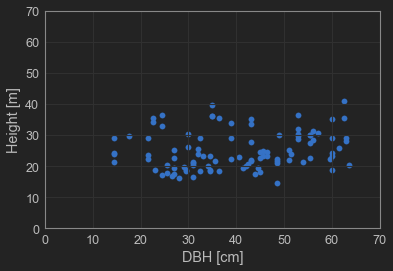

In [4]:
tmp = pd.DataFrame({"Height": train_height, "DBH": train_DBH}, index=index)
# print(tmp)
import matplotlib.pyplot as plt
x = tmp["DBH"]
y = tmp["Height"]
plt.scatter(x,y)
plt.xlabel("DBH [cm]")
plt.ylabel("Height [m]")
plt.axis([0,70,0,70])
plt.show()

In [5]:
from sklearn.model_selection import LeaveOneOut
import xgboost as xgb
loo = LeaveOneOut()
X = train["Height"].values
Y = target["DBH"].values

In [6]:
for X_index, Y_index in loo.split(train):
    X_train, X_target = X[X_index], Y[X_index]
    Y_train, Y_target = X[Y_index], Y[Y_index]
    
    dtrain = xgb.DMatrix(pd.DataFrame(X_train), label=pd.DataFrame(X_target))
    dvalid = xgb.DMatrix(pd.DataFrame(Y_train), label=pd.DataFrame(Y_target))
    num_round = 500
    evallist = [(dvalid, "eval"), (dtrain, "train")]
    evals_result = {}
    param = {
        "max_depth": 3,
        "eta": 0.01,
        "objective": "reg:squarederror",
    }
    bst = xgb.train(
                            param, dtrain,
                            num_round,
                            evallist,
                            evals_result=evals_result,
                            # 一定ラウンド回しても改善が見込めない場合は学習を打ち切る
    )

[0]	eval-rmse:34.0865	train-rmse:41.665
[1]	eval-rmse:33.677	train-rmse:41.2955
[2]	eval-rmse:33.2716	train-rmse:40.93
[3]	eval-rmse:32.8702	train-rmse:40.5685
[4]	eval-rmse:32.4727	train-rmse:40.2108
[5]	eval-rmse:32.0974	train-rmse:39.857
[6]	eval-rmse:31.7075	train-rmse:39.5071
[7]	eval-rmse:31.3215	train-rmse:39.161
[8]	eval-rmse:30.9394	train-rmse:38.8186
[9]	eval-rmse:30.561	train-rmse:38.48
[10]	eval-rmse:30.1863	train-rmse:38.145
[11]	eval-rmse:29.8153	train-rmse:37.8138
[12]	eval-rmse:29.448	train-rmse:37.4861
[13]	eval-rmse:29.0896	train-rmse:37.1621
[14]	eval-rmse:28.7295	train-rmse:36.8416
[15]	eval-rmse:28.3781	train-rmse:36.5247
[16]	eval-rmse:28.025	train-rmse:36.2112
[17]	eval-rmse:27.6753	train-rmse:35.9012
[18]	eval-rmse:27.3342	train-rmse:35.5947
[19]	eval-rmse:26.9914	train-rmse:35.2916
[20]	eval-rmse:26.6519	train-rmse:34.9918
[21]	eval-rmse:26.3207	train-rmse:34.6954
[22]	eval-rmse:25.9879	train-rmse:34.4022
[23]	eval-rmse:25.6632	train-rmse:34.1124
[24]	eval-rmse

[194]	eval-rmse:2.52229	train-rmse:13.144
[195]	eval-rmse:2.64717	train-rmse:13.1142
[196]	eval-rmse:2.77144	train-rmse:13.0848
[197]	eval-rmse:2.89508	train-rmse:13.0559
[198]	eval-rmse:3.0181	train-rmse:13.0275
[199]	eval-rmse:3.14051	train-rmse:12.9995
[200]	eval-rmse:3.26231	train-rmse:12.972
[201]	eval-rmse:3.3835	train-rmse:12.9449
[202]	eval-rmse:3.50408	train-rmse:12.9183
[203]	eval-rmse:3.62406	train-rmse:12.8921
[204]	eval-rmse:3.74344	train-rmse:12.8663
[205]	eval-rmse:3.86223	train-rmse:12.841
[206]	eval-rmse:3.98041	train-rmse:12.8161
[207]	eval-rmse:4.09802	train-rmse:12.7915
[208]	eval-rmse:4.21502	train-rmse:12.7674
[209]	eval-rmse:4.33145	train-rmse:12.7437
[210]	eval-rmse:4.44729	train-rmse:12.7203
[211]	eval-rmse:4.56255	train-rmse:12.6973
[212]	eval-rmse:4.67724	train-rmse:12.6747
[213]	eval-rmse:4.79136	train-rmse:12.6525
[214]	eval-rmse:4.9049	train-rmse:12.6307
[215]	eval-rmse:5.01788	train-rmse:12.6092
[216]	eval-rmse:5.13029	train-rmse:12.588
[217]	eval-rmse:5.

[386]	eval-rmse:17.0257	train-rmse:11.1563
[387]	eval-rmse:17.0217	train-rmse:11.1543
[388]	eval-rmse:17.0741	train-rmse:11.1501
[389]	eval-rmse:17.1262	train-rmse:11.1482
[390]	eval-rmse:17.1453	train-rmse:11.1394
[391]	eval-rmse:17.1971	train-rmse:11.1375
[392]	eval-rmse:17.1928	train-rmse:11.1356
[393]	eval-rmse:17.2443	train-rmse:11.1323
[394]	eval-rmse:17.263	train-rmse:11.1221
[395]	eval-rmse:17.2585	train-rmse:11.1203
[396]	eval-rmse:17.3097	train-rmse:11.1163
[397]	eval-rmse:17.3606	train-rmse:11.1145
[398]	eval-rmse:17.4113	train-rmse:11.1128
[399]	eval-rmse:17.4618	train-rmse:11.111
[400]	eval-rmse:17.4799	train-rmse:11.1011
[401]	eval-rmse:17.475	train-rmse:11.0994
[402]	eval-rmse:17.5251	train-rmse:11.0962
[403]	eval-rmse:17.5319	train-rmse:11.092
[404]	eval-rmse:17.5497	train-rmse:11.0836
[405]	eval-rmse:17.5994	train-rmse:11.0797
[406]	eval-rmse:17.6489	train-rmse:11.0781
[407]	eval-rmse:17.6561	train-rmse:11.0744
[408]	eval-rmse:17.7053	train-rmse:11.0713
[409]	eval-rmse

[80]	eval-rmse:0.471081	train-rmse:22.0283
[81]	eval-rmse:0.27203	train-rmse:21.8798
[82]	eval-rmse:0.085394	train-rmse:21.7354
[83]	eval-rmse:0.109886	train-rmse:21.5904
[84]	eval-rmse:0.289881	train-rmse:21.4496
[85]	eval-rmse:0.481491	train-rmse:21.3082
[86]	eval-rmse:0.671228	train-rmse:21.1686
[87]	eval-rmse:0.846069	train-rmse:21.0332
[88]	eval-rmse:1.03224	train-rmse:20.8971
[89]	eval-rmse:1.20666	train-rmse:20.7651
[90]	eval-rmse:1.3893	train-rmse:20.6325
[91]	eval-rmse:1.55751	train-rmse:20.5039
[92]	eval-rmse:1.73946	train-rmse:20.3707
[93]	eval-rmse:1.91966	train-rmse:20.2392
[94]	eval-rmse:2.08313	train-rmse:20.1155
[95]	eval-rmse:2.26004	train-rmse:19.9871
[96]	eval-rmse:2.43526	train-rmse:19.8604
[97]	eval-rmse:2.59687	train-rmse:19.7414
[98]	eval-rmse:2.76886	train-rmse:19.6177
[99]	eval-rmse:2.92189	train-rmse:19.5018
[100]	eval-rmse:3.09076	train-rmse:19.3812
[101]	eval-rmse:3.24367	train-rmse:19.2683
[102]	eval-rmse:3.40946	train-rmse:19.1506
[103]	eval-rmse:3.56028	t

[272]	eval-rmse:15.5359	train-rmse:11.5587
[273]	eval-rmse:15.5646	train-rmse:11.5493
[274]	eval-rmse:15.5931	train-rmse:11.5401
[275]	eval-rmse:15.6197	train-rmse:11.5299
[276]	eval-rmse:15.6476	train-rmse:11.521
[277]	eval-rmse:15.6753	train-rmse:11.5122
[278]	eval-rmse:15.7026	train-rmse:11.5036
[279]	eval-rmse:15.7252	train-rmse:11.4944
[280]	eval-rmse:15.752	train-rmse:11.486
[281]	eval-rmse:15.7786	train-rmse:11.4778
[282]	eval-rmse:15.805	train-rmse:11.4697
[283]	eval-rmse:15.8298	train-rmse:11.4615
[284]	eval-rmse:15.8556	train-rmse:11.4537
[285]	eval-rmse:15.8812	train-rmse:11.4459
[286]	eval-rmse:15.9022	train-rmse:11.4375
[287]	eval-rmse:15.9273	train-rmse:11.43
[288]	eval-rmse:15.9521	train-rmse:11.4226
[289]	eval-rmse:15.9757	train-rmse:11.414
[290]	eval-rmse:16.0001	train-rmse:11.4068
[291]	eval-rmse:16.0242	train-rmse:11.3997
[292]	eval-rmse:16.0481	train-rmse:11.3928
[293]	eval-rmse:16.0677	train-rmse:11.3851
[294]	eval-rmse:16.0911	train-rmse:11.3783
[295]	eval-rmse:16

[464]	eval-rmse:18.1096	train-rmse:10.541
[465]	eval-rmse:18.1219	train-rmse:10.5321
[466]	eval-rmse:18.1265	train-rmse:10.531
[467]	eval-rmse:18.1325	train-rmse:10.528
[468]	eval-rmse:18.1304	train-rmse:10.524
[469]	eval-rmse:18.1323	train-rmse:10.5216
[470]	eval-rmse:18.1366	train-rmse:10.5181
[471]	eval-rmse:18.1456	train-rmse:10.5099
[472]	eval-rmse:18.1494	train-rmse:10.507
[473]	eval-rmse:18.1552	train-rmse:10.5041
[474]	eval-rmse:18.167	train-rmse:10.4968
[475]	eval-rmse:18.1712	train-rmse:10.4957
[476]	eval-rmse:18.1803	train-rmse:10.4933
[477]	eval-rmse:18.1779	train-rmse:10.4896
[478]	eval-rmse:18.1794	train-rmse:10.4872
[479]	eval-rmse:18.1829	train-rmse:10.4843
[480]	eval-rmse:18.1915	train-rmse:10.4763
[481]	eval-rmse:18.1954	train-rmse:10.4729
[482]	eval-rmse:18.2009	train-rmse:10.47
[483]	eval-rmse:18.2048	train-rmse:10.469
[484]	eval-rmse:18.2136	train-rmse:10.4666
[485]	eval-rmse:18.211	train-rmse:10.463
[486]	eval-rmse:18.2066	train-rmse:10.4607
[487]	eval-rmse:18.209

[158]	eval-rmse:2.42367	train-rmse:14.6844
[159]	eval-rmse:2.32574	train-rmse:14.6278
[160]	eval-rmse:2.24278	train-rmse:14.5756
[161]	eval-rmse:2.14667	train-rmse:14.5205
[162]	eval-rmse:2.05783	train-rmse:14.4706
[163]	eval-rmse:1.96349	train-rmse:14.4169
[164]	eval-rmse:1.88382	train-rmse:14.3679
[165]	eval-rmse:1.79123	train-rmse:14.3157
[166]	eval-rmse:1.71312	train-rmse:14.2677
[167]	eval-rmse:1.62225	train-rmse:14.2167
[168]	eval-rmse:1.53224	train-rmse:14.1666
[169]	eval-rmse:1.45649	train-rmse:14.121
[170]	eval-rmse:1.38143	train-rmse:14.0755
[171]	eval-rmse:1.2939	train-rmse:14.0273
[172]	eval-rmse:1.2072	train-rmse:13.9798
[173]	eval-rmse:1.12696	train-rmse:13.9368
[174]	eval-rmse:1.04185	train-rmse:13.8906
[175]	eval-rmse:0.963116	train-rmse:13.8489
[176]	eval-rmse:0.886299	train-rmse:13.8094
[177]	eval-rmse:0.816425	train-rmse:13.7667
[178]	eval-rmse:0.747185	train-rmse:13.7261
[179]	eval-rmse:0.665882	train-rmse:13.6827
[180]	eval-rmse:0.585358	train-rmse:13.6399
[181]	ev

[349]	eval-rmse:5.05582	train-rmse:11.3559
[350]	eval-rmse:5.06944	train-rmse:11.3528
[351]	eval-rmse:5.08293	train-rmse:11.3498
[352]	eval-rmse:5.08778	train-rmse:11.3468
[353]	eval-rmse:5.11163	train-rmse:11.3356
[354]	eval-rmse:5.21608	train-rmse:11.3314
[355]	eval-rmse:5.22905	train-rmse:11.3285
[356]	eval-rmse:5.2419	train-rmse:11.3256
[357]	eval-rmse:5.25462	train-rmse:11.3228
[358]	eval-rmse:5.27771	train-rmse:11.3119
[359]	eval-rmse:5.29018	train-rmse:11.3091
[360]	eval-rmse:5.30254	train-rmse:11.3064
[361]	eval-rmse:5.30642	train-rmse:11.3038
[362]	eval-rmse:5.32897	train-rmse:11.2931
[363]	eval-rmse:5.34095	train-rmse:11.2905
[364]	eval-rmse:5.35282	train-rmse:11.2879
[365]	eval-rmse:5.36456	train-rmse:11.2854
[366]	eval-rmse:5.37619	train-rmse:11.2829
[367]	eval-rmse:5.398	train-rmse:11.2724
[368]	eval-rmse:5.4094	train-rmse:11.27
[369]	eval-rmse:5.4207	train-rmse:11.2676
[370]	eval-rmse:5.42368	train-rmse:11.2652
[371]	eval-rmse:5.445	train-rmse:11.255
[372]	eval-rmse:5.453

[43]	eval-rmse:19.6932	train-rmse:28.9528
[44]	eval-rmse:19.4112	train-rmse:28.7228
[45]	eval-rmse:19.1454	train-rmse:28.4977
[46]	eval-rmse:18.8688	train-rmse:28.2729
[47]	eval-rmse:18.6121	train-rmse:28.0529
[48]	eval-rmse:18.3407	train-rmse:27.8333
[49]	eval-rmse:18.085	train-rmse:27.6185
[50]	eval-rmse:17.8356	train-rmse:27.4062
[51]	eval-rmse:17.5718	train-rmse:27.1941
[52]	eval-rmse:17.3234	train-rmse:26.9867
[53]	eval-rmse:17.0646	train-rmse:26.7795
[54]	eval-rmse:16.8248	train-rmse:26.577
[55]	eval-rmse:16.5708	train-rmse:26.3747
[56]	eval-rmse:16.3318	train-rmse:26.177
[57]	eval-rmse:16.0827	train-rmse:25.9793
[58]	eval-rmse:15.8483	train-rmse:25.7863
[59]	eval-rmse:15.6198	train-rmse:25.5956
[60]	eval-rmse:15.3776	train-rmse:25.4049
[61]	eval-rmse:15.15	train-rmse:25.2188
[62]	eval-rmse:14.9124	train-rmse:25.0326
[63]	eval-rmse:14.6926	train-rmse:24.851
[64]	eval-rmse:14.4595	train-rmse:24.6692
[65]	eval-rmse:14.2404	train-rmse:24.492
[66]	eval-rmse:14.0117	train-rmse:24.3144

[236]	eval-rmse:4.23622	train-rmse:12.2143
[237]	eval-rmse:4.25497	train-rmse:12.1993
[238]	eval-rmse:4.30435	train-rmse:12.1844
[239]	eval-rmse:4.32247	train-rmse:12.1699
[240]	eval-rmse:4.37105	train-rmse:12.1555
[241]	eval-rmse:4.38856	train-rmse:12.1414
[242]	eval-rmse:4.43455	train-rmse:12.1275
[243]	eval-rmse:4.47629	train-rmse:12.1139
[244]	eval-rmse:4.49284	train-rmse:12.1005
[245]	eval-rmse:4.53945	train-rmse:12.0873
[246]	eval-rmse:4.55542	train-rmse:12.0743
[247]	eval-rmse:4.60127	train-rmse:12.0616
[248]	eval-rmse:4.61667	train-rmse:12.049
[249]	eval-rmse:4.66178	train-rmse:12.0367
[250]	eval-rmse:4.6954	train-rmse:12.0245
[251]	eval-rmse:4.73306	train-rmse:12.0126
[252]	eval-rmse:4.766	train-rmse:12.0009
[253]	eval-rmse:4.79862	train-rmse:11.9893
[254]	eval-rmse:4.83092	train-rmse:11.9779
[255]	eval-rmse:4.8629	train-rmse:11.9667
[256]	eval-rmse:4.90562	train-rmse:11.9557
[257]	eval-rmse:4.93695	train-rmse:11.9449
[258]	eval-rmse:4.96798	train-rmse:11.9343
[259]	eval-rmse:

[428]	eval-rmse:7.476	train-rmse:11.0261
[429]	eval-rmse:7.48007	train-rmse:11.0229
[430]	eval-rmse:7.48625	train-rmse:11.0216
[431]	eval-rmse:7.44134	train-rmse:11.0186
[432]	eval-rmse:7.44676	train-rmse:11.0152
[433]	eval-rmse:7.45067	train-rmse:11.0121
[434]	eval-rmse:7.46599	train-rmse:11.0039
[435]	eval-rmse:7.46318	train-rmse:11.0026
[436]	eval-rmse:7.46864	train-rmse:11.0012
[437]	eval-rmse:7.48378	train-rmse:10.9917
[438]	eval-rmse:7.4827	train-rmse:10.9877
[439]	eval-rmse:7.48631	train-rmse:10.9846
[440]	eval-rmse:7.49126	train-rmse:10.9813
[441]	eval-rmse:7.44632	train-rmse:10.9784
[442]	eval-rmse:7.45038	train-rmse:10.9746
[443]	eval-rmse:7.45548	train-rmse:10.9732
[444]	eval-rmse:7.45979	train-rmse:10.968
[445]	eval-rmse:7.41505	train-rmse:10.9652
[446]	eval-rmse:7.42038	train-rmse:10.964
[447]	eval-rmse:7.42374	train-rmse:10.961
[448]	eval-rmse:7.42216	train-rmse:10.957
[449]	eval-rmse:7.42696	train-rmse:10.9557
[450]	eval-rmse:7.43143	train-rmse:10.9524
[451]	eval-rmse:7.

[122]	eval-rmse:36.8322	train-rmse:16.9398
[123]	eval-rmse:36.842	train-rmse:16.8471
[124]	eval-rmse:36.8516	train-rmse:16.7557
[125]	eval-rmse:36.7361	train-rmse:16.6717
[126]	eval-rmse:36.6288	train-rmse:16.5881
[127]	eval-rmse:36.5156	train-rmse:16.5064
[128]	eval-rmse:36.4052	train-rmse:16.4257
[129]	eval-rmse:36.4185	train-rmse:16.3395
[130]	eval-rmse:36.3102	train-rmse:16.2609
[131]	eval-rmse:36.3243	train-rmse:16.1768
[132]	eval-rmse:36.2235	train-rmse:16.0995
[133]	eval-rmse:36.1165	train-rmse:16.024
[134]	eval-rmse:36.0123	train-rmse:15.9496
[135]	eval-rmse:36.0289	train-rmse:15.8696
[136]	eval-rmse:35.9249	train-rmse:15.7971
[137]	eval-rmse:35.9422	train-rmse:15.719
[138]	eval-rmse:35.9593	train-rmse:15.6419
[139]	eval-rmse:35.8598	train-rmse:15.5722
[140]	eval-rmse:35.8777	train-rmse:15.497
[141]	eval-rmse:35.7784	train-rmse:15.4292
[142]	eval-rmse:35.7969	train-rmse:15.3559
[143]	eval-rmse:35.7011	train-rmse:15.2898
[144]	eval-rmse:35.7202	train-rmse:15.2184
[145]	eval-rmse

[314]	eval-rmse:29.2739	train-rmse:11.0938
[315]	eval-rmse:29.2549	train-rmse:11.0886
[316]	eval-rmse:29.236	train-rmse:11.0835
[317]	eval-rmse:29.2174	train-rmse:11.0784
[318]	eval-rmse:29.1989	train-rmse:11.0735
[319]	eval-rmse:29.1806	train-rmse:11.0686
[320]	eval-rmse:29.1625	train-rmse:11.0638
[321]	eval-rmse:29.1445	train-rmse:11.0591
[322]	eval-rmse:29.1268	train-rmse:11.0544
[323]	eval-rmse:29.1092	train-rmse:11.0498
[324]	eval-rmse:29.0918	train-rmse:11.0453
[325]	eval-rmse:29.0746	train-rmse:11.0409
[326]	eval-rmse:29.0575	train-rmse:11.0365
[327]	eval-rmse:29.0406	train-rmse:11.0322
[328]	eval-rmse:29.0239	train-rmse:11.0279
[329]	eval-rmse:29.0073	train-rmse:11.0238
[330]	eval-rmse:28.9909	train-rmse:11.0197
[331]	eval-rmse:28.9747	train-rmse:11.0156
[332]	eval-rmse:28.9586	train-rmse:11.0116
[333]	eval-rmse:28.9516	train-rmse:11.0077
[334]	eval-rmse:28.9396	train-rmse:11.0015
[335]	eval-rmse:28.926	train-rmse:10.9954
[336]	eval-rmse:28.9194	train-rmse:10.9916
[337]	eval-rm

[6]	eval-rmse:59.2844	train-rmse:39.2042
[7]	eval-rmse:58.9014	train-rmse:38.8604
[8]	eval-rmse:58.5221	train-rmse:38.5204
[9]	eval-rmse:58.1638	train-rmse:38.1841
[10]	eval-rmse:57.7918	train-rmse:37.8515
[11]	eval-rmse:57.4235	train-rmse:37.5225
[12]	eval-rmse:57.0588	train-rmse:37.1971
[13]	eval-rmse:56.703	train-rmse:36.8753
[14]	eval-rmse:56.3453	train-rmse:36.557
[15]	eval-rmse:55.9965	train-rmse:36.2422
[16]	eval-rmse:55.6458	train-rmse:35.9309
[17]	eval-rmse:55.2987	train-rmse:35.6231
[18]	eval-rmse:54.96	train-rmse:35.3186
[19]	eval-rmse:54.6196	train-rmse:35.0175
[20]	eval-rmse:54.2825	train-rmse:34.7198
[21]	eval-rmse:53.9537	train-rmse:34.4254
[22]	eval-rmse:53.6232	train-rmse:34.1342
[23]	eval-rmse:53.3008	train-rmse:33.8464
[24]	eval-rmse:53.1638	train-rmse:33.5617
[25]	eval-rmse:53.0277	train-rmse:33.2802
[26]	eval-rmse:52.7147	train-rmse:33.0018
[27]	eval-rmse:52.5816	train-rmse:32.7266
[28]	eval-rmse:52.4494	train-rmse:32.4545
[29]	eval-rmse:52.1454	train-rmse:32.1854


[201]	eval-rmse:33.6651	train-rmse:12.6792
[202]	eval-rmse:33.5987	train-rmse:12.6458
[203]	eval-rmse:33.5329	train-rmse:12.6129
[204]	eval-rmse:33.4986	train-rmse:12.578
[205]	eval-rmse:33.434	train-rmse:12.546
[206]	eval-rmse:33.4006	train-rmse:12.512
[207]	eval-rmse:33.3372	train-rmse:12.4808
[208]	eval-rmse:33.3046	train-rmse:12.4477
[209]	eval-rmse:33.2423	train-rmse:12.4174
[210]	eval-rmse:33.2362	train-rmse:12.3917
[211]	eval-rmse:33.1749	train-rmse:12.3622
[212]	eval-rmse:33.1439	train-rmse:12.3306
[213]	eval-rmse:33.0838	train-rmse:12.3019
[214]	eval-rmse:33.0361	train-rmse:12.2754
[215]	eval-rmse:32.9827	train-rmse:12.2524
[216]	eval-rmse:32.9783	train-rmse:12.2287
[217]	eval-rmse:32.9201	train-rmse:12.2013
[218]	eval-rmse:32.8916	train-rmse:12.1719
[219]	eval-rmse:32.8345	train-rmse:12.1453
[220]	eval-rmse:32.8067	train-rmse:12.1167
[221]	eval-rmse:32.7506	train-rmse:12.0908
[222]	eval-rmse:32.7004	train-rmse:12.0699
[223]	eval-rmse:32.6738	train-rmse:12.0422
[224]	eval-rmse

[393]	eval-rmse:29.6918	train-rmse:10.4993
[394]	eval-rmse:29.689	train-rmse:10.4962
[395]	eval-rmse:29.6815	train-rmse:10.4905
[396]	eval-rmse:29.6991	train-rmse:10.4849
[397]	eval-rmse:29.6817	train-rmse:10.4782
[398]	eval-rmse:29.6749	train-rmse:10.4741
[399]	eval-rmse:29.677	train-rmse:10.4677
[400]	eval-rmse:29.6693	train-rmse:10.4644
[401]	eval-rmse:29.6523	train-rmse:10.4533
[402]	eval-rmse:29.6546	train-rmse:10.447
[403]	eval-rmse:29.6467	train-rmse:10.4455
[404]	eval-rmse:29.6366	train-rmse:10.4413
[405]	eval-rmse:29.6299	train-rmse:10.4358
[406]	eval-rmse:29.6134	train-rmse:10.426
[407]	eval-rmse:29.6161	train-rmse:10.4197
[408]	eval-rmse:29.61	train-rmse:10.4158
[409]	eval-rmse:29.603	train-rmse:10.4126
[410]	eval-rmse:29.6058	train-rmse:10.4065
[411]	eval-rmse:29.5897	train-rmse:10.4012
[412]	eval-rmse:29.5824	train-rmse:10.3998
[413]	eval-rmse:29.5854	train-rmse:10.3937
[414]	eval-rmse:29.5787	train-rmse:10.3906
[415]	eval-rmse:29.5774	train-rmse:10.3879
[416]	eval-rmse:29

[87]	eval-rmse:4.42915	train-rmse:21.0389
[88]	eval-rmse:4.17645	train-rmse:20.9017
[89]	eval-rmse:4.00488	train-rmse:20.7697
[90]	eval-rmse:3.75595	train-rmse:20.6358
[91]	eval-rmse:3.50923	train-rmse:20.5036
[92]	eval-rmse:3.33956	train-rmse:20.3765
[93]	eval-rmse:3.09654	train-rmse:20.2475
[94]	eval-rmse:2.9329	train-rmse:20.1235
[95]	eval-rmse:2.69349	train-rmse:19.9976
[96]	eval-rmse:2.45622	train-rmse:19.8734
[97]	eval-rmse:2.29436	train-rmse:19.7541
[98]	eval-rmse:2.06063	train-rmse:19.6327
[99]	eval-rmse:1.82898	train-rmse:19.5129
[100]	eval-rmse:1.67433	train-rmse:19.3982
[101]	eval-rmse:1.44611	train-rmse:19.2812
[102]	eval-rmse:1.21992	train-rmse:19.1658
[103]	eval-rmse:1.06692	train-rmse:19.0555
[104]	eval-rmse:0.844101	train-rmse:18.9429
[105]	eval-rmse:0.696581	train-rmse:18.8354
[106]	eval-rmse:0.534782	train-rmse:18.7222
[107]	eval-rmse:0.316696	train-rmse:18.6138
[108]	eval-rmse:0.173313	train-rmse:18.5105
[109]	eval-rmse:0.015873	train-rmse:18.4015
[110]	eval-rmse:0.1

[279]	eval-rmse:14.836	train-rmse:11.5152
[280]	eval-rmse:14.8612	train-rmse:11.5074
[281]	eval-rmse:14.9424	train-rmse:11.4969
[282]	eval-rmse:14.9671	train-rmse:11.4892
[283]	eval-rmse:14.9918	train-rmse:11.4808
[284]	eval-rmse:15.0161	train-rmse:11.4734
[285]	eval-rmse:15.0959	train-rmse:11.4634
[286]	eval-rmse:15.1197	train-rmse:11.4561
[287]	eval-rmse:15.1434	train-rmse:11.4481
[288]	eval-rmse:15.1667	train-rmse:11.4412
[289]	eval-rmse:15.2453	train-rmse:11.4316
[290]	eval-rmse:15.2681	train-rmse:11.4248
[291]	eval-rmse:15.2907	train-rmse:11.4181
[292]	eval-rmse:15.3681	train-rmse:11.4089
[293]	eval-rmse:15.3905	train-rmse:11.4015
[294]	eval-rmse:15.4125	train-rmse:11.3951
[295]	eval-rmse:15.4342	train-rmse:11.3888
[296]	eval-rmse:15.5104	train-rmse:11.3799
[297]	eval-rmse:15.5319	train-rmse:11.3729
[298]	eval-rmse:15.553	train-rmse:11.3668
[299]	eval-rmse:15.5739	train-rmse:11.3609
[300]	eval-rmse:15.6488	train-rmse:11.3524
[301]	eval-rmse:15.671	train-rmse:11.3459
[302]	eval-rms

[471]	eval-rmse:18.4449	train-rmse:10.6187
[472]	eval-rmse:18.4487	train-rmse:10.6173
[473]	eval-rmse:18.4519	train-rmse:10.6124
[474]	eval-rmse:18.4555	train-rmse:10.6099
[475]	eval-rmse:18.4692	train-rmse:10.6017
[476]	eval-rmse:18.4727	train-rmse:10.5987
[477]	eval-rmse:18.4764	train-rmse:10.5954
[478]	eval-rmse:18.4789	train-rmse:10.5918
[479]	eval-rmse:18.4924	train-rmse:10.5822
[480]	eval-rmse:18.5413	train-rmse:10.579
[481]	eval-rmse:18.5452	train-rmse:10.5779
[482]	eval-rmse:18.5484	train-rmse:10.5749
[483]	eval-rmse:18.5518	train-rmse:10.5735
[484]	eval-rmse:18.5556	train-rmse:10.5725
[485]	eval-rmse:18.5588	train-rmse:10.57
[486]	eval-rmse:18.5555	train-rmse:10.5662
[487]	eval-rmse:18.5588	train-rmse:10.563
[488]	eval-rmse:18.5621	train-rmse:10.5617
[489]	eval-rmse:18.5651	train-rmse:10.5587
[490]	eval-rmse:18.6134	train-rmse:10.5468
[491]	eval-rmse:18.6164	train-rmse:10.5444
[492]	eval-rmse:18.6189	train-rmse:10.5396
[493]	eval-rmse:18.6317	train-rmse:10.5303
[494]	eval-rmse

[166]	eval-rmse:0.088428	train-rmse:14.2583
[167]	eval-rmse:0.010807	train-rmse:14.2108
[168]	eval-rmse:0.079041	train-rmse:14.1607
[169]	eval-rmse:0.15514	train-rmse:14.1132
[170]	eval-rmse:0.237679	train-rmse:14.0683
[171]	eval-rmse:0.325069	train-rmse:14.0202
[172]	eval-rmse:0.398933	train-rmse:13.9763
[173]	eval-rmse:0.484703	train-rmse:13.9295
[174]	eval-rmse:0.557114	train-rmse:13.8865
[175]	eval-rmse:0.641293	train-rmse:13.8408
[176]	eval-rmse:0.719364	train-rmse:13.7995
[177]	eval-rmse:0.789642	train-rmse:13.7565
[178]	eval-rmse:0.865082	train-rmse:13.718
[179]	eval-rmse:0.946236	train-rmse:13.6747
[180]	eval-rmse:1.01445	train-rmse:13.6351
[181]	eval-rmse:1.08205	train-rmse:13.5944
[182]	eval-rmse:1.16097	train-rmse:13.5528
[183]	eval-rmse:1.22724	train-rmse:13.5132
[184]	eval-rmse:1.2929	train-rmse:13.4759
[185]	eval-rmse:1.36966	train-rmse:13.4355
[186]	eval-rmse:1.44692	train-rmse:13.4004
[187]	eval-rmse:1.52343	train-rmse:13.3658
[188]	eval-rmse:1.59918	train-rmse:13.3318


[358]	eval-rmse:6.87139	train-rmse:11.3078
[359]	eval-rmse:6.88384	train-rmse:11.3051
[360]	eval-rmse:6.89615	train-rmse:11.3024
[361]	eval-rmse:6.89994	train-rmse:11.2997
[362]	eval-rmse:6.92233	train-rmse:11.2889
[363]	eval-rmse:6.93156	train-rmse:11.2845
[364]	eval-rmse:6.9434	train-rmse:11.2819
[365]	eval-rmse:6.95513	train-rmse:11.2793
[366]	eval-rmse:6.96674	train-rmse:11.2768
[367]	eval-rmse:6.9884	train-rmse:11.2663
[368]	eval-rmse:6.99978	train-rmse:11.2638
[369]	eval-rmse:7.01105	train-rmse:11.2614
[370]	eval-rmse:7.01395	train-rmse:11.2591
[371]	eval-rmse:7.03512	train-rmse:11.2487
[372]	eval-rmse:7.04333	train-rmse:11.2445
[373]	eval-rmse:7.05417	train-rmse:11.2422
[374]	eval-rmse:7.0649	train-rmse:11.2399
[375]	eval-rmse:7.06738	train-rmse:11.2377
[376]	eval-rmse:7.08795	train-rmse:11.2276
[377]	eval-rmse:7.09836	train-rmse:11.2254
[378]	eval-rmse:7.10866	train-rmse:11.2232
[379]	eval-rmse:7.12881	train-rmse:11.2133
[380]	eval-rmse:7.13891	train-rmse:11.2112
[381]	eval-rms

[51]	eval-rmse:35.7623	train-rmse:27.0936
[52]	eval-rmse:35.5156	train-rmse:26.8877
[53]	eval-rmse:35.2589	train-rmse:26.6816
[54]	eval-rmse:35.0169	train-rmse:26.4806
[55]	eval-rmse:34.7808	train-rmse:26.2819
[56]	eval-rmse:34.5313	train-rmse:26.0829
[57]	eval-rmse:34.2962	train-rmse:25.889
[58]	eval-rmse:34.0514	train-rmse:25.6948
[59]	eval-rmse:33.8244	train-rmse:25.5054
[60]	eval-rmse:33.5842	train-rmse:25.3157
[61]	eval-rmse:33.358	train-rmse:25.131
[62]	eval-rmse:33.1375	train-rmse:24.9484
[63]	eval-rmse:32.904	train-rmse:24.7654
[64]	eval-rmse:32.6843	train-rmse:24.5874
[65]	eval-rmse:32.4553	train-rmse:24.4087
[66]	eval-rmse:32.2432	train-rmse:24.235
[67]	eval-rmse:32.0184	train-rmse:24.0606
[68]	eval-rmse:31.8071	train-rmse:23.8911
[69]	eval-rmse:31.5866	train-rmse:23.7208
[70]	eval-rmse:31.3793	train-rmse:23.5555
[71]	eval-rmse:31.163	train-rmse:23.3893
[72]	eval-rmse:30.9629	train-rmse:23.2279
[73]	eval-rmse:30.7507	train-rmse:23.0657
[74]	eval-rmse:30.5406	train-rmse:22.905

[244]	eval-rmse:17.2373	train-rmse:12.1277
[245]	eval-rmse:17.2018	train-rmse:12.114
[246]	eval-rmse:17.1858	train-rmse:12.1012
[247]	eval-rmse:17.1399	train-rmse:12.0886
[248]	eval-rmse:17.1055	train-rmse:12.0754
[249]	eval-rmse:17.0603	train-rmse:12.0632
[250]	eval-rmse:17.0935	train-rmse:12.0488
[251]	eval-rmse:17.0601	train-rmse:12.0362
[252]	eval-rmse:17.0216	train-rmse:12.0245
[253]	eval-rmse:17.0551	train-rmse:12.0107
[254]	eval-rmse:17.0117	train-rmse:11.9994
[255]	eval-rmse:17.0452	train-rmse:11.9859
[256]	eval-rmse:17.0134	train-rmse:11.9742
[257]	eval-rmse:16.9725	train-rmse:11.9634
[258]	eval-rmse:17.0063	train-rmse:11.9505
[259]	eval-rmse:16.9755	train-rmse:11.9392
[260]	eval-rmse:16.9452	train-rmse:11.929
[261]	eval-rmse:16.9793	train-rmse:11.9165
[262]	eval-rmse:16.9496	train-rmse:11.9066
[263]	eval-rmse:16.9836	train-rmse:11.8945
[264]	eval-rmse:16.9545	train-rmse:11.8849
[265]	eval-rmse:16.9254	train-rmse:11.8745
[266]	eval-rmse:16.8969	train-rmse:11.8651
[267]	eval-rm

[436]	eval-rmse:15.7617	train-rmse:10.9886
[437]	eval-rmse:15.7621	train-rmse:10.9847
[438]	eval-rmse:15.7568	train-rmse:10.9831
[439]	eval-rmse:15.7511	train-rmse:10.9818
[440]	eval-rmse:15.7459	train-rmse:10.9803
[441]	eval-rmse:15.7408	train-rmse:10.977
[442]	eval-rmse:15.7845	train-rmse:10.9737
[443]	eval-rmse:15.7853	train-rmse:10.9699
[444]	eval-rmse:15.7804	train-rmse:10.9672
[445]	eval-rmse:15.7755	train-rmse:10.9657
[446]	eval-rmse:15.7707	train-rmse:10.9625
[447]	eval-rmse:15.7658	train-rmse:10.961
[448]	eval-rmse:15.762	train-rmse:10.9572
[449]	eval-rmse:15.7479	train-rmse:10.9484
[450]	eval-rmse:15.7427	train-rmse:10.9471
[451]	eval-rmse:15.7864	train-rmse:10.9439
[452]	eval-rmse:15.7825	train-rmse:10.9388
[453]	eval-rmse:15.778	train-rmse:10.9362
[454]	eval-rmse:15.7643	train-rmse:10.9274
[455]	eval-rmse:15.7599	train-rmse:10.9243
[456]	eval-rmse:15.8035	train-rmse:10.9211
[457]	eval-rmse:15.7986	train-rmse:10.9199
[458]	eval-rmse:15.7944	train-rmse:10.9174
[459]	eval-rmse

[130]	eval-rmse:32.904	train-rmse:16.3859
[131]	eval-rmse:32.779	train-rmse:16.3033
[132]	eval-rmse:32.6872	train-rmse:16.2287
[133]	eval-rmse:32.5878	train-rmse:16.153
[134]	eval-rmse:32.5234	train-rmse:16.08
[135]	eval-rmse:32.4339	train-rmse:16.0085
[136]	eval-rmse:32.3144	train-rmse:15.9308
[137]	eval-rmse:32.2526	train-rmse:15.8607
[138]	eval-rmse:32.1352	train-rmse:15.7851
[139]	eval-rmse:32.0418	train-rmse:15.7152
[140]	eval-rmse:31.9826	train-rmse:15.6478
[141]	eval-rmse:31.8682	train-rmse:15.5749
[142]	eval-rmse:31.8105	train-rmse:15.5092
[143]	eval-rmse:31.6982	train-rmse:15.4382
[144]	eval-rmse:31.587	train-rmse:15.3681
[145]	eval-rmse:31.532	train-rmse:15.305
[146]	eval-rmse:31.4228	train-rmse:15.2366
[147]	eval-rmse:31.3693	train-rmse:15.1752
[148]	eval-rmse:31.262	train-rmse:15.1087
[149]	eval-rmse:31.2328	train-rmse:15.049
[150]	eval-rmse:31.1275	train-rmse:14.984
[151]	eval-rmse:31.0231	train-rmse:14.92
[152]	eval-rmse:30.996	train-rmse:14.8627
[153]	eval-rmse:30.8936	t

[322]	eval-rmse:25.2602	train-rmse:11.2479
[323]	eval-rmse:25.2522	train-rmse:11.2435
[324]	eval-rmse:25.2411	train-rmse:11.2374
[325]	eval-rmse:25.224	train-rmse:11.2331
[326]	eval-rmse:25.2071	train-rmse:11.2289
[327]	eval-rmse:25.1997	train-rmse:11.2248
[328]	eval-rmse:25.1999	train-rmse:11.2199
[329]	eval-rmse:25.1835	train-rmse:11.2159
[330]	eval-rmse:25.1672	train-rmse:11.2119
[331]	eval-rmse:25.1512	train-rmse:11.208
[332]	eval-rmse:25.1445	train-rmse:11.2041
[333]	eval-rmse:25.1345	train-rmse:11.1985
[334]	eval-rmse:25.1189	train-rmse:11.1947
[335]	eval-rmse:25.1126	train-rmse:11.191
[336]	eval-rmse:25.1465	train-rmse:11.1865
[337]	eval-rmse:25.1314	train-rmse:11.1829
[338]	eval-rmse:25.1164	train-rmse:11.1794
[339]	eval-rmse:25.1016	train-rmse:11.1758
[340]	eval-rmse:25.096	train-rmse:11.1724
[341]	eval-rmse:25.0972	train-rmse:11.1681
[342]	eval-rmse:25.088	train-rmse:11.1629
[343]	eval-rmse:25.0737	train-rmse:11.1596
[344]	eval-rmse:25.0686	train-rmse:11.1563
[345]	eval-rmse:

[15]	eval-rmse:50.4698	train-rmse:36.3159
[16]	eval-rmse:50.1187	train-rmse:36.0043
[17]	eval-rmse:49.7711	train-rmse:35.6961
[18]	eval-rmse:49.4319	train-rmse:35.3914
[19]	eval-rmse:49.091	train-rmse:35.09
[20]	eval-rmse:48.7585	train-rmse:34.7921
[21]	eval-rmse:48.4243	train-rmse:34.4974
[22]	eval-rmse:48.0934	train-rmse:34.206
[23]	eval-rmse:47.7705	train-rmse:33.9179
[24]	eval-rmse:47.446	train-rmse:33.633
[25]	eval-rmse:47.1248	train-rmse:33.3513
[26]	eval-rmse:46.8113	train-rmse:33.0728
[27]	eval-rmse:46.4963	train-rmse:32.7975
[28]	eval-rmse:46.189	train-rmse:32.5252
[29]	eval-rmse:45.8801	train-rmse:32.256
[30]	eval-rmse:45.5743	train-rmse:31.9899
[31]	eval-rmse:45.2759	train-rmse:31.7269
[32]	eval-rmse:44.9761	train-rmse:31.4668
[33]	eval-rmse:44.6792	train-rmse:31.2097
[34]	eval-rmse:44.3895	train-rmse:30.9556
[35]	eval-rmse:44.0984	train-rmse:30.7043
[36]	eval-rmse:43.8144	train-rmse:30.456
[37]	eval-rmse:43.529	train-rmse:30.2106
[38]	eval-rmse:43.2464	train-rmse:29.968
[39

[209]	eval-rmse:17.7968	train-rmse:12.712
[210]	eval-rmse:17.7361	train-rmse:12.6888
[211]	eval-rmse:17.6823	train-rmse:12.666
[212]	eval-rmse:17.6273	train-rmse:12.6435
[213]	eval-rmse:17.5666	train-rmse:12.6215
[214]	eval-rmse:17.5143	train-rmse:12.5997
[215]	eval-rmse:17.4546	train-rmse:12.5784
[216]	eval-rmse:17.4034	train-rmse:12.5574
[217]	eval-rmse:17.3447	train-rmse:12.5367
[218]	eval-rmse:17.2943	train-rmse:12.5164
[219]	eval-rmse:17.2366	train-rmse:12.4964
[220]	eval-rmse:17.1872	train-rmse:12.4767
[221]	eval-rmse:17.1305	train-rmse:12.4574
[222]	eval-rmse:17.0803	train-rmse:12.4384
[223]	eval-rmse:17.0323	train-rmse:12.4197
[224]	eval-rmse:16.9769	train-rmse:12.4013
[225]	eval-rmse:16.9298	train-rmse:12.3832
[226]	eval-rmse:16.8754	train-rmse:12.3654
[227]	eval-rmse:16.823	train-rmse:12.3479
[228]	eval-rmse:16.7771	train-rmse:12.3307
[229]	eval-rmse:16.7241	train-rmse:12.3137
[230]	eval-rmse:16.6791	train-rmse:12.2971
[231]	eval-rmse:16.627	train-rmse:12.2807
[232]	eval-rmse

[401]	eval-rmse:11.9718	train-rmse:11.0733
[402]	eval-rmse:11.9637	train-rmse:11.0716
[403]	eval-rmse:11.9648	train-rmse:11.0699
[404]	eval-rmse:11.9486	train-rmse:11.0617
[405]	eval-rmse:11.899	train-rmse:11.0582
[406]	eval-rmse:11.9003	train-rmse:11.0565
[407]	eval-rmse:11.8843	train-rmse:11.0471
[408]	eval-rmse:11.8774	train-rmse:11.044
[409]	eval-rmse:11.8699	train-rmse:11.0424
[410]	eval-rmse:11.8714	train-rmse:11.0408
[411]	eval-rmse:11.8557	train-rmse:11.0329
[412]	eval-rmse:11.8489	train-rmse:11.0311
[413]	eval-rmse:11.8417	train-rmse:11.0295
[414]	eval-rmse:11.8358	train-rmse:11.0254
[415]	eval-rmse:11.8204	train-rmse:11.0162
[416]	eval-rmse:11.8139	train-rmse:11.0126
[417]	eval-rmse:11.7656	train-rmse:11.0092
[418]	eval-rmse:11.7677	train-rmse:11.0077
[419]	eval-rmse:11.7614	train-rmse:11.006
[420]	eval-rmse:11.7464	train-rmse:10.9983
[421]	eval-rmse:11.7459	train-rmse:10.9941
[422]	eval-rmse:11.7399	train-rmse:10.9912
[423]	eval-rmse:11.7338	train-rmse:10.9877
[424]	eval-rms

[96]	eval-rmse:35.5283	train-rmse:19.7573
[97]	eval-rmse:35.3708	train-rmse:19.6395
[98]	eval-rmse:35.2021	train-rmse:19.516
[99]	eval-rmse:35.0503	train-rmse:19.4013
[100]	eval-rmse:34.9837	train-rmse:19.284
[101]	eval-rmse:34.8194	train-rmse:19.1651
[102]	eval-rmse:34.6666	train-rmse:19.0548
[103]	eval-rmse:34.6033	train-rmse:18.9417
[104]	eval-rmse:34.4433	train-rmse:18.827
[105]	eval-rmse:34.2974	train-rmse:18.7209
[106]	eval-rmse:34.2372	train-rmse:18.6121
[107]	eval-rmse:34.0916	train-rmse:18.5089
[108]	eval-rmse:33.9372	train-rmse:18.3996
[109]	eval-rmse:33.7993	train-rmse:18.2991
[110]	eval-rmse:33.7433	train-rmse:18.1957
[111]	eval-rmse:33.593	train-rmse:18.0904
[112]	eval-rmse:33.4565	train-rmse:17.994
[113]	eval-rmse:33.4035	train-rmse:17.8946
[114]	eval-rmse:33.2672	train-rmse:17.8007
[115]	eval-rmse:33.1222	train-rmse:17.7005
[116]	eval-rmse:32.9786	train-rmse:17.6015
[117]	eval-rmse:32.8484	train-rmse:17.5113
[118]	eval-rmse:32.8006	train-rmse:17.4178
[119]	eval-rmse:32.6

[288]	eval-rmse:24.6137	train-rmse:11.4739
[289]	eval-rmse:24.591	train-rmse:11.4672
[290]	eval-rmse:24.614	train-rmse:11.4588
[291]	eval-rmse:24.582	train-rmse:11.4524
[292]	eval-rmse:24.6051	train-rmse:11.4442
[293]	eval-rmse:24.5832	train-rmse:11.4379
[294]	eval-rmse:24.5616	train-rmse:11.4317
[295]	eval-rmse:24.5848	train-rmse:11.4238
[296]	eval-rmse:24.5636	train-rmse:11.4178
[297]	eval-rmse:24.5425	train-rmse:11.4119
[298]	eval-rmse:24.566	train-rmse:11.4043
[299]	eval-rmse:24.5422	train-rmse:11.3985
[300]	eval-rmse:24.5218	train-rmse:11.3929
[301]	eval-rmse:24.5454	train-rmse:11.3855
[302]	eval-rmse:24.5254	train-rmse:11.38
[303]	eval-rmse:24.5056	train-rmse:11.3746
[304]	eval-rmse:24.5293	train-rmse:11.3675
[305]	eval-rmse:24.5099	train-rmse:11.3623
[306]	eval-rmse:24.4909	train-rmse:11.3557
[307]	eval-rmse:24.4609	train-rmse:11.3505
[308]	eval-rmse:24.485	train-rmse:11.3438
[309]	eval-rmse:24.4663	train-rmse:11.3388
[310]	eval-rmse:24.448	train-rmse:11.3325
[311]	eval-rmse:24.

[480]	eval-rmse:23.4085	train-rmse:10.6141
[481]	eval-rmse:23.3956	train-rmse:10.6068
[482]	eval-rmse:23.3917	train-rmse:10.6058
[483]	eval-rmse:23.3988	train-rmse:10.5941
[484]	eval-rmse:23.3958	train-rmse:10.5913
[485]	eval-rmse:23.3832	train-rmse:10.583
[486]	eval-rmse:23.3801	train-rmse:10.58
[487]	eval-rmse:23.3874	train-rmse:10.5684
[488]	eval-rmse:23.3842	train-rmse:10.5671
[489]	eval-rmse:23.3719	train-rmse:10.5601
[490]	eval-rmse:23.3793	train-rmse:10.5488
[491]	eval-rmse:23.3815	train-rmse:10.5454
[492]	eval-rmse:23.3784	train-rmse:10.5441
[493]	eval-rmse:23.3764	train-rmse:10.539
[494]	eval-rmse:23.4098	train-rmse:10.5363
[495]	eval-rmse:23.4148	train-rmse:10.5329
[496]	eval-rmse:23.4122	train-rmse:10.5302
[497]	eval-rmse:23.4093	train-rmse:10.5289
[498]	eval-rmse:23.4062	train-rmse:10.5254
[499]	eval-rmse:23.3943	train-rmse:10.5174
[0]	eval-rmse:52.1074	train-rmse:41.4783
[1]	eval-rmse:51.7188	train-rmse:41.1106
[2]	eval-rmse:51.334	train-rmse:40.7469
[3]	eval-rmse:50.9343	

[175]	eval-rmse:19.5901	train-rmse:13.7938
[176]	eval-rmse:19.5568	train-rmse:13.7524
[177]	eval-rmse:19.4737	train-rmse:13.7073
[178]	eval-rmse:19.4415	train-rmse:13.6666
[179]	eval-rmse:19.3599	train-rmse:13.6227
[180]	eval-rmse:19.2852	train-rmse:13.5839
[181]	eval-rmse:19.2547	train-rmse:13.5449
[182]	eval-rmse:19.1753	train-rmse:13.5026
[183]	eval-rmse:19.2025	train-rmse:13.4661
[184]	eval-rmse:19.2295	train-rmse:13.4301
[185]	eval-rmse:19.2563	train-rmse:13.3947
[186]	eval-rmse:19.2829	train-rmse:13.3599
[187]	eval-rmse:19.3094	train-rmse:13.3256
[188]	eval-rmse:19.3356	train-rmse:13.2919
[189]	eval-rmse:19.3617	train-rmse:13.2587
[190]	eval-rmse:19.3877	train-rmse:13.2261
[191]	eval-rmse:19.4134	train-rmse:13.194
[192]	eval-rmse:19.439	train-rmse:13.1624
[193]	eval-rmse:19.4644	train-rmse:13.1314
[194]	eval-rmse:19.4896	train-rmse:13.1008
[195]	eval-rmse:19.5147	train-rmse:13.0708
[196]	eval-rmse:19.5396	train-rmse:13.0412
[197]	eval-rmse:19.5643	train-rmse:13.0121
[198]	eval-rm

[367]	eval-rmse:18.8954	train-rmse:11.1623
[368]	eval-rmse:18.8872	train-rmse:11.158
[369]	eval-rmse:18.8762	train-rmse:11.1537
[370]	eval-rmse:18.8685	train-rmse:11.1493
[371]	eval-rmse:18.8583	train-rmse:11.1447
[372]	eval-rmse:18.8369	train-rmse:11.1322
[373]	eval-rmse:18.826	train-rmse:11.1299
[374]	eval-rmse:18.8156	train-rmse:11.1258
[375]	eval-rmse:18.808	train-rmse:11.1216
[376]	eval-rmse:18.7975	train-rmse:11.1194
[377]	eval-rmse:18.788	train-rmse:11.1149
[378]	eval-rmse:18.781	train-rmse:11.1107
[379]	eval-rmse:18.7791	train-rmse:11.1086
[380]	eval-rmse:18.7586	train-rmse:11.098
[381]	eval-rmse:18.7849	train-rmse:11.095
[382]	eval-rmse:18.7753	train-rmse:11.0911
[383]	eval-rmse:18.7687	train-rmse:11.087
[384]	eval-rmse:18.7599	train-rmse:11.0826
[385]	eval-rmse:18.7399	train-rmse:11.0706
[386]	eval-rmse:18.7332	train-rmse:11.0667
[387]	eval-rmse:18.7237	train-rmse:11.0647
[388]	eval-rmse:18.7146	train-rmse:11.0609
[389]	eval-rmse:18.7413	train-rmse:11.058
[390]	eval-rmse:18.7

[61]	eval-rmse:4.51758	train-rmse:25.2075
[62]	eval-rmse:4.2948	train-rmse:25.0223
[63]	eval-rmse:4.05836	train-rmse:24.8373
[64]	eval-rmse:3.83626	train-rmse:24.6567
[65]	eval-rmse:3.60431	train-rmse:24.476
[66]	eval-rmse:3.38998	train-rmse:24.2997
[67]	eval-rmse:3.17425	train-rmse:24.1256
[68]	eval-rmse:2.94876	train-rmse:23.9512
[69]	eval-rmse:2.73718	train-rmse:23.7813
[70]	eval-rmse:2.51597	train-rmse:23.6111
[71]	eval-rmse:2.29692	train-rmse:23.443
[72]	eval-rmse:2.09135	train-rmse:23.2793
[73]	eval-rmse:1.87645	train-rmse:23.1151
[74]	eval-rmse:1.67813	train-rmse:22.9554
[75]	eval-rmse:1.46728	train-rmse:22.7952
[76]	eval-rmse:1.27278	train-rmse:22.6394
[77]	eval-rmse:1.06589	train-rmse:22.4832
[78]	eval-rmse:0.861025	train-rmse:22.3288
[79]	eval-rmse:0.672096	train-rmse:22.1788
[80]	eval-rmse:0.471081	train-rmse:22.0283
[81]	eval-rmse:0.27203	train-rmse:21.8798
[82]	eval-rmse:0.085394	train-rmse:21.7354
[83]	eval-rmse:0.109886	train-rmse:21.5904
[84]	eval-rmse:0.289881	train-rm

[253]	eval-rmse:17.5198	train-rmse:11.8746
[254]	eval-rmse:17.5529	train-rmse:11.8624
[255]	eval-rmse:17.6005	train-rmse:11.8509
[256]	eval-rmse:17.6329	train-rmse:11.8391
[257]	eval-rmse:17.6799	train-rmse:11.828
[258]	eval-rmse:17.7117	train-rmse:11.8165
[259]	eval-rmse:17.7579	train-rmse:11.8058
[260]	eval-rmse:17.7886	train-rmse:11.7953
[261]	eval-rmse:17.8195	train-rmse:11.7843
[262]	eval-rmse:17.8496	train-rmse:11.7741
[263]	eval-rmse:17.9249	train-rmse:11.7617
[264]	eval-rmse:17.9544	train-rmse:11.7518
[265]	eval-rmse:18.0287	train-rmse:11.7397
[266]	eval-rmse:18.0581	train-rmse:11.7295
[267]	eval-rmse:18.0868	train-rmse:11.72
[268]	eval-rmse:18.1151	train-rmse:11.7107
[269]	eval-rmse:18.188	train-rmse:11.6992
[270]	eval-rmse:18.2158	train-rmse:11.6902
[271]	eval-rmse:18.2438	train-rmse:11.6807
[272]	eval-rmse:18.271	train-rmse:11.6719
[273]	eval-rmse:18.3481	train-rmse:11.661
[274]	eval-rmse:18.3748	train-rmse:11.6526
[275]	eval-rmse:18.4454	train-rmse:11.642
[276]	eval-rmse:18

[445]	eval-rmse:22.0846	train-rmse:10.8599
[446]	eval-rmse:22.0895	train-rmse:10.8583
[447]	eval-rmse:22.0947	train-rmse:10.8548
[448]	eval-rmse:22.1367	train-rmse:10.8515
[449]	eval-rmse:22.1418	train-rmse:10.8503
[450]	eval-rmse:22.1464	train-rmse:10.8472
[451]	eval-rmse:22.1756	train-rmse:10.844
[452]	eval-rmse:22.1727	train-rmse:10.8428
[453]	eval-rmse:22.1772	train-rmse:10.8413
[454]	eval-rmse:22.1817	train-rmse:10.8388
[455]	eval-rmse:22.1787	train-rmse:10.8342
[456]	eval-rmse:22.2433	train-rmse:10.8221
[457]	eval-rmse:22.2476	train-rmse:10.8206
[458]	eval-rmse:22.2446	train-rmse:10.8163
[459]	eval-rmse:22.3086	train-rmse:10.8043
[460]	eval-rmse:22.3372	train-rmse:10.8011
[461]	eval-rmse:22.3417	train-rmse:10.7976
[462]	eval-rmse:22.3458	train-rmse:10.7962
[463]	eval-rmse:22.3498	train-rmse:10.7932
[464]	eval-rmse:22.3538	train-rmse:10.7907
[465]	eval-rmse:22.3571	train-rmse:10.7863
[466]	eval-rmse:22.3611	train-rmse:10.7849
[467]	eval-rmse:22.3649	train-rmse:10.7819
[468]	eval-r

[139]	eval-rmse:16.3572	train-rmse:15.7297
[140]	eval-rmse:16.4652	train-rmse:15.6632
[141]	eval-rmse:16.5739	train-rmse:15.5924
[142]	eval-rmse:16.7293	train-rmse:15.5242
[143]	eval-rmse:16.8358	train-rmse:15.4553
[144]	eval-rmse:16.9888	train-rmse:15.3889
[145]	eval-rmse:17.0899	train-rmse:15.3272
[146]	eval-rmse:17.1934	train-rmse:15.261
[147]	eval-rmse:17.3432	train-rmse:15.1972
[148]	eval-rmse:17.4448	train-rmse:15.1322
[149]	eval-rmse:17.5923	train-rmse:15.0702
[150]	eval-rmse:17.7384	train-rmse:15.0069
[151]	eval-rmse:17.8833	train-rmse:14.9466
[152]	eval-rmse:17.9813	train-rmse:14.8885
[153]	eval-rmse:18.0851	train-rmse:14.8275
[154]	eval-rmse:18.2268	train-rmse:14.7696
[155]	eval-rmse:18.3218	train-rmse:14.7091
[156]	eval-rmse:18.4147	train-rmse:14.6556
[157]	eval-rmse:18.5147	train-rmse:14.5979
[158]	eval-rmse:18.6526	train-rmse:14.5431
[159]	eval-rmse:18.7508	train-rmse:14.4856
[160]	eval-rmse:18.8403	train-rmse:14.4351
[161]	eval-rmse:18.9753	train-rmse:14.3825
[162]	eval-r

[331]	eval-rmse:27.0924	train-rmse:11.2213
[332]	eval-rmse:27.1088	train-rmse:11.2172
[333]	eval-rmse:27.125	train-rmse:11.2132
[334]	eval-rmse:27.1411	train-rmse:11.2092
[335]	eval-rmse:27.157	train-rmse:11.2053
[336]	eval-rmse:27.1728	train-rmse:11.2015
[337]	eval-rmse:27.1884	train-rmse:11.1977
[338]	eval-rmse:27.2038	train-rmse:11.194
[339]	eval-rmse:27.2191	train-rmse:11.1903
[340]	eval-rmse:27.2342	train-rmse:11.1867
[341]	eval-rmse:27.2492	train-rmse:11.1832
[342]	eval-rmse:27.2641	train-rmse:11.1797
[343]	eval-rmse:27.2788	train-rmse:11.1762
[344]	eval-rmse:27.2933	train-rmse:11.1728
[345]	eval-rmse:27.3077	train-rmse:11.1695
[346]	eval-rmse:27.322	train-rmse:11.1662
[347]	eval-rmse:27.3456	train-rmse:11.1551
[348]	eval-rmse:27.3596	train-rmse:11.1519
[349]	eval-rmse:27.3772	train-rmse:11.1487
[350]	eval-rmse:27.3893	train-rmse:11.1435
[351]	eval-rmse:27.4029	train-rmse:11.1405
[352]	eval-rmse:27.4163	train-rmse:11.1374
[353]	eval-rmse:27.4296	train-rmse:11.1344
[354]	eval-rmse

[24]	eval-rmse:29.3638	train-rmse:33.8017
[25]	eval-rmse:29.0409	train-rmse:33.5187
[26]	eval-rmse:28.726	train-rmse:33.239
[27]	eval-rmse:28.4094	train-rmse:32.9623
[28]	eval-rmse:28.096	train-rmse:32.6888
[29]	eval-rmse:27.7902	train-rmse:32.4185
[30]	eval-rmse:27.4828	train-rmse:32.1511
[31]	eval-rmse:27.1785	train-rmse:31.8869
[32]	eval-rmse:26.8817	train-rmse:31.6256
[33]	eval-rmse:26.5833	train-rmse:31.3674
[34]	eval-rmse:26.2922	train-rmse:31.1121
[35]	eval-rmse:25.9997	train-rmse:30.8597
[36]	eval-rmse:25.71	train-rmse:30.6103
[37]	eval-rmse:25.4274	train-rmse:30.3637
[38]	eval-rmse:25.1434	train-rmse:30.12
[39]	eval-rmse:24.8622	train-rmse:29.8791
[40]	eval-rmse:24.5697	train-rmse:29.6387
[41]	eval-rmse:24.2979	train-rmse:29.4033
[42]	eval-rmse:24.0109	train-rmse:29.1683
[43]	eval-rmse:23.7403	train-rmse:28.9383
[44]	eval-rmse:23.4587	train-rmse:28.7087
[45]	eval-rmse:23.1933	train-rmse:28.484
[46]	eval-rmse:22.9345	train-rmse:28.2619
[47]	eval-rmse:22.6608	train-rmse:28.0401


[218]	eval-rmse:4.73247	train-rmse:12.5614
[219]	eval-rmse:4.67436	train-rmse:12.5412
[220]	eval-rmse:4.65	train-rmse:12.5214
[221]	eval-rmse:4.5944	train-rmse:12.5018
[222]	eval-rmse:4.57077	train-rmse:12.4826
[223]	eval-rmse:4.51457	train-rmse:12.4637
[224]	eval-rmse:4.46623	train-rmse:12.4451
[225]	eval-rmse:4.44377	train-rmse:12.4268
[226]	eval-rmse:4.38896	train-rmse:12.4088
[227]	eval-rmse:4.36721	train-rmse:12.3911
[228]	eval-rmse:4.31331	train-rmse:12.3737
[229]	eval-rmse:4.25993	train-rmse:12.3566
[230]	eval-rmse:4.21819	train-rmse:12.3391
[231]	eval-rmse:4.17687	train-rmse:12.3219
[232]	eval-rmse:4.15699	train-rmse:12.3056
[233]	eval-rmse:4.11649	train-rmse:12.2889
[234]	eval-rmse:4.06515	train-rmse:12.2731
[235]	eval-rmse:4.02545	train-rmse:12.257
[236]	eval-rmse:3.98614	train-rmse:12.241
[237]	eval-rmse:3.94722	train-rmse:12.2254
[238]	eval-rmse:3.90869	train-rmse:12.21
[239]	eval-rmse:3.87054	train-rmse:12.1948
[240]	eval-rmse:3.83277	train-rmse:12.1799
[241]	eval-rmse:3.7

[410]	eval-rmse:2.25884	train-rmse:11.0807
[411]	eval-rmse:2.25194	train-rmse:11.0772
[412]	eval-rmse:2.2201	train-rmse:11.0735
[413]	eval-rmse:2.21407	train-rmse:11.0696
[414]	eval-rmse:2.26496	train-rmse:11.0658
[415]	eval-rmse:2.26656	train-rmse:11.0643
[416]	eval-rmse:2.25991	train-rmse:11.0625
[417]	eval-rmse:2.24317	train-rmse:11.0521
[418]	eval-rmse:2.23677	train-rmse:11.0487
[419]	eval-rmse:2.2303	train-rmse:11.0459
[420]	eval-rmse:2.22446	train-rmse:11.0406
[421]	eval-rmse:2.19345	train-rmse:11.037
[422]	eval-rmse:2.19554	train-rmse:11.0356
[423]	eval-rmse:2.17928	train-rmse:11.0269
[424]	eval-rmse:2.23043	train-rmse:11.0233
[425]	eval-rmse:2.22523	train-rmse:11.0195
[426]	eval-rmse:2.21921	train-rmse:11.0177
[427]	eval-rmse:2.21339	train-rmse:11.0144
[428]	eval-rmse:2.2075	train-rmse:11.0117
[429]	eval-rmse:2.20122	train-rmse:11.0103
[430]	eval-rmse:2.18547	train-rmse:11.0003
[431]	eval-rmse:2.18037	train-rmse:10.9951
[432]	eval-rmse:2.23151	train-rmse:10.9916
[433]	eval-rmse

[104]	eval-rmse:15.594	train-rmse:18.9666
[105]	eval-rmse:15.4475	train-rmse:18.8606
[106]	eval-rmse:15.2893	train-rmse:18.7492
[107]	eval-rmse:15.1482	train-rmse:18.6461
[108]	eval-rmse:15.0137	train-rmse:18.5403
[109]	eval-rmse:14.8596	train-rmse:18.4331
[110]	eval-rmse:14.7175	train-rmse:18.3341
[111]	eval-rmse:14.5869	train-rmse:18.2323
[112]	eval-rmse:14.4475	train-rmse:18.136
[113]	eval-rmse:14.2988	train-rmse:18.0338
[114]	eval-rmse:14.1644	train-rmse:17.9401
[115]	eval-rmse:14.0388	train-rmse:17.8434
[116]	eval-rmse:13.8941	train-rmse:17.745
[117]	eval-rmse:13.7927	train-rmse:17.6521
[118]	eval-rmse:13.6632	train-rmse:17.5633
[119]	eval-rmse:13.5224	train-rmse:17.4686
[120]	eval-rmse:13.3931	train-rmse:17.3822
[121]	eval-rmse:13.2745	train-rmse:17.2926
[122]	eval-rmse:13.1375	train-rmse:17.2013
[123]	eval-rmse:13.014	train-rmse:17.1185
[124]	eval-rmse:12.8795	train-rmse:17.0295
[125]	eval-rmse:12.7656	train-rmse:16.9444
[126]	eval-rmse:12.6527	train-rmse:16.8627
[127]	eval-rmse

[296]	eval-rmse:2.9993	train-rmse:11.6162
[297]	eval-rmse:2.98222	train-rmse:11.6083
[298]	eval-rmse:2.96128	train-rmse:11.6014
[299]	eval-rmse:2.94057	train-rmse:11.5957
[300]	eval-rmse:2.92008	train-rmse:11.59
[301]	eval-rmse:2.90345	train-rmse:11.5825
[302]	eval-rmse:2.88333	train-rmse:11.5759
[303]	eval-rmse:2.86167	train-rmse:11.5697
[304]	eval-rmse:2.84023	train-rmse:11.5637
[305]	eval-rmse:2.819	train-rmse:11.5577
[306]	eval-rmse:2.79799	train-rmse:11.5518
[307]	eval-rmse:2.77717	train-rmse:11.546
[308]	eval-rmse:2.75657	train-rmse:11.5403
[309]	eval-rmse:2.73616	train-rmse:11.5347
[310]	eval-rmse:2.71597	train-rmse:11.5292
[311]	eval-rmse:2.69597	train-rmse:11.5238
[312]	eval-rmse:2.67616	train-rmse:11.5184
[313]	eval-rmse:2.65655	train-rmse:11.5132
[314]	eval-rmse:2.63714	train-rmse:11.508
[315]	eval-rmse:2.61792	train-rmse:11.5029
[316]	eval-rmse:2.59889	train-rmse:11.4979
[317]	eval-rmse:2.58005	train-rmse:11.493
[318]	eval-rmse:2.5614	train-rmse:11.4881
[319]	eval-rmse:2.54

[488]	eval-rmse:1.13297	train-rmse:10.7876
[489]	eval-rmse:1.14063	train-rmse:10.7762
[490]	eval-rmse:1.13766	train-rmse:10.7737
[491]	eval-rmse:1.14026	train-rmse:10.7703
[492]	eval-rmse:1.13716	train-rmse:10.769
[493]	eval-rmse:1.1337	train-rmse:10.768
[494]	eval-rmse:1.13065	train-rmse:10.7667
[495]	eval-rmse:1.12505	train-rmse:10.7628
[496]	eval-rmse:1.13281	train-rmse:10.7515
[497]	eval-rmse:1.13008	train-rmse:10.7491
[498]	eval-rmse:1.11797	train-rmse:10.7421
[499]	eval-rmse:1.12579	train-rmse:10.731
[0]	eval-rmse:31.5861	train-rmse:41.6847
[1]	eval-rmse:31.1763	train-rmse:41.3149
[2]	eval-rmse:30.7706	train-rmse:40.949
[3]	eval-rmse:30.3689	train-rmse:40.5872
[4]	eval-rmse:29.9711	train-rmse:40.2292
[5]	eval-rmse:29.5773	train-rmse:39.8751
[6]	eval-rmse:29.1873	train-rmse:39.5249
[7]	eval-rmse:28.8012	train-rmse:39.1784
[8]	eval-rmse:28.4365	train-rmse:38.8358
[9]	eval-rmse:28.0578	train-rmse:38.4968
[10]	eval-rmse:27.6828	train-rmse:38.1616
[11]	eval-rmse:27.3116	train-rmse:37.

[182]	eval-rmse:1.53507	train-rmse:13.5679
[183]	eval-rmse:1.60607	train-rmse:13.5287
[184]	eval-rmse:1.67741	train-rmse:13.4933
[185]	eval-rmse:1.65176	train-rmse:13.4522
[186]	eval-rmse:1.72862	train-rmse:13.4175
[187]	eval-rmse:1.80472	train-rmse:13.3832
[188]	eval-rmse:1.88008	train-rmse:13.3496
[189]	eval-rmse:1.95471	train-rmse:13.3165
[190]	eval-rmse:2.03046	train-rmse:13.2839
[191]	eval-rmse:2.10365	train-rmse:13.2518
[192]	eval-rmse:2.17796	train-rmse:13.2203
[193]	eval-rmse:2.25155	train-rmse:13.1893
[194]	eval-rmse:2.32265	train-rmse:13.1588
[195]	eval-rmse:2.39482	train-rmse:13.1288
[196]	eval-rmse:2.46456	train-rmse:13.0992
[197]	eval-rmse:2.53536	train-rmse:13.0702
[198]	eval-rmse:2.5972	train-rmse:13.0416
[199]	eval-rmse:2.66671	train-rmse:13.0135
[200]	eval-rmse:2.73343	train-rmse:12.9859
[201]	eval-rmse:2.79351	train-rmse:12.9587
[202]	eval-rmse:2.86111	train-rmse:12.9319
[203]	eval-rmse:2.91858	train-rmse:12.9056
[204]	eval-rmse:2.98497	train-rmse:12.8797
[205]	eval-r

[374]	eval-rmse:7.09736	train-rmse:11.2306
[375]	eval-rmse:7.10642	train-rmse:11.2262
[376]	eval-rmse:7.03596	train-rmse:11.2159
[377]	eval-rmse:7.04641	train-rmse:11.2137
[378]	eval-rmse:7.06158	train-rmse:11.2115
[379]	eval-rmse:7.07102	train-rmse:11.208
[380]	eval-rmse:7.0009	train-rmse:11.1979
[381]	eval-rmse:7.01094	train-rmse:11.1958
[382]	eval-rmse:7.02089	train-rmse:11.1937
[383]	eval-rmse:7.03553	train-rmse:11.1916
[384]	eval-rmse:6.96574	train-rmse:11.1801
[385]	eval-rmse:6.9739	train-rmse:11.1759
[386]	eval-rmse:6.98823	train-rmse:11.1739
[387]	eval-rmse:6.91889	train-rmse:11.1642
[388]	eval-rmse:6.92679	train-rmse:11.16
[389]	eval-rmse:6.93607	train-rmse:11.1581
[390]	eval-rmse:6.95	train-rmse:11.1562
[391]	eval-rmse:6.88103	train-rmse:11.145
[392]	eval-rmse:6.88932	train-rmse:11.1418
[393]	eval-rmse:6.89824	train-rmse:11.1399
[394]	eval-rmse:6.91179	train-rmse:11.138
[395]	eval-rmse:6.84317	train-rmse:11.1286
[396]	eval-rmse:6.85182	train-rmse:11.1268
[397]	eval-rmse:6.860

[68]	eval-rmse:10.5507	train-rmse:23.9694
[69]	eval-rmse:10.3091	train-rmse:23.7969
[70]	eval-rmse:10.1	train-rmse:23.63
[71]	eval-rmse:9.83977	train-rmse:23.4598
[72]	eval-rmse:9.60449	train-rmse:23.2933
[73]	eval-rmse:9.40135	train-rmse:23.1323
[74]	eval-rmse:9.1476	train-rmse:22.9678
[75]	eval-rmse:8.91852	train-rmse:22.8073
[76]	eval-rmse:8.72113	train-rmse:22.6522
[77]	eval-rmse:8.47373	train-rmse:22.4934
[78]	eval-rmse:8.28324	train-rmse:22.3419
[79]	eval-rmse:8.06203	train-rmse:22.1886
[80]	eval-rmse:7.82078	train-rmse:22.0353
[81]	eval-rmse:7.63568	train-rmse:21.8894
[82]	eval-rmse:7.42026	train-rmse:21.7415
[83]	eval-rmse:7.185	train-rmse:21.5935
[84]	eval-rmse:7.00514	train-rmse:21.4529
[85]	eval-rmse:6.79534	train-rmse:21.3104
[86]	eval-rmse:6.56592	train-rmse:21.1676
[87]	eval-rmse:6.35989	train-rmse:21.0286
[88]	eval-rmse:6.18384	train-rmse:20.895
[89]	eval-rmse:5.96012	train-rmse:20.7572
[90]	eval-rmse:5.79029	train-rmse:20.6269
[91]	eval-rmse:5.5913	train-rmse:20.4944
[9

[261]	eval-rmse:9.99981	train-rmse:11.755
[262]	eval-rmse:10.0298	train-rmse:11.7448
[263]	eval-rmse:10.0598	train-rmse:11.7338
[264]	eval-rmse:10.0872	train-rmse:11.7218
[265]	eval-rmse:10.1164	train-rmse:11.712
[266]	eval-rmse:10.1452	train-rmse:11.7023
[267]	eval-rmse:10.1718	train-rmse:11.6907
[268]	eval-rmse:10.2003	train-rmse:11.6805
[269]	eval-rmse:10.2283	train-rmse:11.6713
[270]	eval-rmse:10.2561	train-rmse:11.6622
[271]	eval-rmse:10.2832	train-rmse:11.6512
[272]	eval-rmse:10.3104	train-rmse:11.6424
[273]	eval-rmse:10.3376	train-rmse:11.6329
[274]	eval-rmse:10.3751	train-rmse:11.6243
[275]	eval-rmse:10.3994	train-rmse:11.6139
[276]	eval-rmse:10.4258	train-rmse:11.6047
[277]	eval-rmse:10.4517	train-rmse:11.5965
[278]	eval-rmse:10.477	train-rmse:11.5865
[279]	eval-rmse:10.5024	train-rmse:11.5785
[280]	eval-rmse:10.5272	train-rmse:11.5687
[281]	eval-rmse:10.5521	train-rmse:11.561
[282]	eval-rmse:10.577	train-rmse:11.5525
[283]	eval-rmse:10.6014	train-rmse:11.5451
[284]	eval-rmse:

[453]	eval-rmse:13.4015	train-rmse:10.7969
[454]	eval-rmse:13.4065	train-rmse:10.7957
[455]	eval-rmse:13.4111	train-rmse:10.7943
[456]	eval-rmse:13.4151	train-rmse:10.7892
[457]	eval-rmse:13.4359	train-rmse:10.7823
[458]	eval-rmse:13.44	train-rmse:10.7791
[459]	eval-rmse:13.4438	train-rmse:10.7759
[460]	eval-rmse:13.494	train-rmse:10.7721
[461]	eval-rmse:13.4983	train-rmse:10.7707
[462]	eval-rmse:13.5029	train-rmse:10.7695
[463]	eval-rmse:13.5069	train-rmse:10.7669
[464]	eval-rmse:13.51	train-rmse:10.7632
[465]	eval-rmse:13.512	train-rmse:10.7602
[466]	eval-rmse:13.5158	train-rmse:10.757
[467]	eval-rmse:13.5199	train-rmse:10.7556
[468]	eval-rmse:13.5233	train-rmse:10.7506
[469]	eval-rmse:13.5271	train-rmse:10.7481
[470]	eval-rmse:13.5469	train-rmse:10.7414
[471]	eval-rmse:13.5512	train-rmse:10.7403
[472]	eval-rmse:13.5545	train-rmse:10.7373
[473]	eval-rmse:13.6034	train-rmse:10.7336
[474]	eval-rmse:13.6072	train-rmse:10.7322
[475]	eval-rmse:13.6106	train-rmse:10.7291
[476]	eval-rmse:13

[148]	eval-rmse:6.00545	train-rmse:15.2614
[149]	eval-rmse:5.97667	train-rmse:15.1961
[150]	eval-rmse:5.96589	train-rmse:15.1359
[151]	eval-rmse:5.87354	train-rmse:15.074
[152]	eval-rmse:5.7821	train-rmse:15.0129
[153]	eval-rmse:5.69431	train-rmse:14.9562
[154]	eval-rmse:5.66813	train-rmse:14.8948
[155]	eval-rmse:5.65988	train-rmse:14.8386
[156]	eval-rmse:5.57187	train-rmse:14.7807
[157]	eval-rmse:5.48471	train-rmse:14.7237
[158]	eval-rmse:5.47804	train-rmse:14.6697
[159]	eval-rmse:5.39259	train-rmse:14.6142
[160]	eval-rmse:5.30798	train-rmse:14.5595
[161]	eval-rmse:5.36593	train-rmse:14.5031
[162]	eval-rmse:5.27856	train-rmse:14.4548
[163]	eval-rmse:5.27438	train-rmse:14.4044
[164]	eval-rmse:5.25238	train-rmse:14.3504
[165]	eval-rmse:5.16746	train-rmse:14.3041
[166]	eval-rmse:5.09168	train-rmse:14.2565
[167]	eval-rmse:5.0712	train-rmse:14.2044
[168]	eval-rmse:5.0509	train-rmse:14.1532
[169]	eval-rmse:4.97722	train-rmse:14.1075
[170]	eval-rmse:4.99961	train-rmse:14.0576
[171]	eval-rmse

[338]	eval-rmse:0.290768	train-rmse:11.3799
[339]	eval-rmse:0.30386	train-rmse:11.3744
[340]	eval-rmse:0.318974	train-rmse:11.3708
[341]	eval-rmse:0.339497	train-rmse:11.3673
[342]	eval-rmse:0.352165	train-rmse:11.3619
[343]	eval-rmse:0.36684	train-rmse:11.3585
[344]	eval-rmse:0.375114	train-rmse:11.3464
[345]	eval-rmse:0.389503	train-rmse:11.3431
[346]	eval-rmse:0.403751	train-rmse:11.3398
[347]	eval-rmse:0.417858	train-rmse:11.3366
[348]	eval-rmse:0.437321	train-rmse:11.3334
[349]	eval-rmse:0.445007	train-rmse:11.3216
[350]	eval-rmse:0.457581	train-rmse:11.3175
[351]	eval-rmse:0.471149	train-rmse:11.3144
[352]	eval-rmse:0.484585	train-rmse:11.3114
[353]	eval-rmse:0.497887	train-rmse:11.3084
[354]	eval-rmse:0.516476	train-rmse:11.3054
[355]	eval-rmse:0.523483	train-rmse:11.294
[356]	eval-rmse:0.536388	train-rmse:11.2911
[357]	eval-rmse:0.549168	train-rmse:11.2882
[358]	eval-rmse:0.480812	train-rmse:11.2752
[359]	eval-rmse:0.493343	train-rmse:11.2724
[360]	eval-rmse:0.505753	train-rmse

[27]	eval-rmse:35.9483	train-rmse:32.9059
[28]	eval-rmse:35.6354	train-rmse:32.6331
[29]	eval-rmse:35.3302	train-rmse:32.3633
[30]	eval-rmse:35.0235	train-rmse:32.0966
[31]	eval-rmse:34.7198	train-rmse:31.8329
[32]	eval-rmse:34.4235	train-rmse:31.5723
[33]	eval-rmse:34.1258	train-rmse:31.3146
[34]	eval-rmse:33.8353	train-rmse:31.0599
[35]	eval-rmse:33.5433	train-rmse:30.8081
[36]	eval-rmse:33.2542	train-rmse:30.5592
[37]	eval-rmse:32.9722	train-rmse:30.3132
[38]	eval-rmse:32.6887	train-rmse:30.0701
[39]	eval-rmse:32.408	train-rmse:29.8298
[40]	eval-rmse:32.1342	train-rmse:29.5922
[41]	eval-rmse:31.859	train-rmse:29.3575
[42]	eval-rmse:31.5906	train-rmse:29.1255
[43]	eval-rmse:31.3207	train-rmse:28.8962
[44]	eval-rmse:31.04	train-rmse:28.667
[45]	eval-rmse:30.7754	train-rmse:28.443
[46]	eval-rmse:30.5	train-rmse:28.2191
[47]	eval-rmse:30.2443	train-rmse:28.0003
[48]	eval-rmse:29.9742	train-rmse:27.7815
[49]	eval-rmse:29.7195	train-rmse:27.5678
[50]	eval-rmse:29.4545	train-rmse:27.354
[5

[221]	eval-rmse:7.78931	train-rmse:12.518
[222]	eval-rmse:7.74062	train-rmse:12.4989
[223]	eval-rmse:7.70196	train-rmse:12.4801
[224]	eval-rmse:7.66368	train-rmse:12.4616
[225]	eval-rmse:7.61631	train-rmse:12.4435
[226]	eval-rmse:7.57887	train-rmse:12.4256
[227]	eval-rmse:7.53239	train-rmse:12.408
[228]	eval-rmse:7.49578	train-rmse:12.3908
[229]	eval-rmse:7.45017	train-rmse:12.3738
[230]	eval-rmse:7.40327	train-rmse:12.3571
[231]	eval-rmse:7.36785	train-rmse:12.3406
[232]	eval-rmse:7.32349	train-rmse:12.3245
[233]	eval-rmse:7.28886	train-rmse:12.3086
[234]	eval-rmse:7.24533	train-rmse:12.293
[235]	eval-rmse:7.21147	train-rmse:12.2776
[236]	eval-rmse:7.16875	train-rmse:12.2625
[237]	eval-rmse:7.13564	train-rmse:12.2476
[238]	eval-rmse:7.09371	train-rmse:12.233
[239]	eval-rmse:7.04608	train-rmse:12.2186
[240]	eval-rmse:7.00452	train-rmse:12.2045
[241]	eval-rmse:6.96375	train-rmse:12.1906
[242]	eval-rmse:6.93246	train-rmse:12.1769
[243]	eval-rmse:6.89616	train-rmse:12.1627
[244]	eval-rmse

[413]	eval-rmse:3.80049	train-rmse:11.0946
[414]	eval-rmse:3.74449	train-rmse:11.0857
[415]	eval-rmse:3.7338	train-rmse:11.0842
[416]	eval-rmse:3.72795	train-rmse:11.0806
[417]	eval-rmse:3.7215	train-rmse:11.0771
[418]	eval-rmse:3.71512	train-rmse:11.0741
[419]	eval-rmse:3.70894	train-rmse:11.0645
[420]	eval-rmse:3.70209	train-rmse:11.063
[421]	eval-rmse:3.69577	train-rmse:11.0613
[422]	eval-rmse:3.69043	train-rmse:11.0574
[423]	eval-rmse:3.68498	train-rmse:11.0538
[424]	eval-rmse:3.67899	train-rmse:11.0504
[425]	eval-rmse:3.67302	train-rmse:11.0475
[426]	eval-rmse:3.61798	train-rmse:11.0389
[427]	eval-rmse:3.61156	train-rmse:11.0375
[428]	eval-rmse:3.60638	train-rmse:11.0341
[429]	eval-rmse:3.60267	train-rmse:11.0298
[430]	eval-rmse:3.59689	train-rmse:11.0282
[431]	eval-rmse:3.59132	train-rmse:11.0248
[432]	eval-rmse:3.58576	train-rmse:11.0221
[433]	eval-rmse:3.58072	train-rmse:11.0168
[434]	eval-rmse:3.57516	train-rmse:11.0152
[435]	eval-rmse:3.57059	train-rmse:11.0114
[436]	eval-rms

[107]	eval-rmse:27.7712	train-rmse:18.5568
[108]	eval-rmse:27.6269	train-rmse:18.4553
[109]	eval-rmse:27.4596	train-rmse:18.3506
[110]	eval-rmse:27.323	train-rmse:18.2518
[111]	eval-rmse:27.1767	train-rmse:18.1482
[112]	eval-rmse:27.0402	train-rmse:18.0521
[113]	eval-rmse:26.8785	train-rmse:17.9526
[114]	eval-rmse:26.736	train-rmse:17.853
[115]	eval-rmse:26.601	train-rmse:17.7607
[116]	eval-rmse:26.4434	train-rmse:17.6649
[117]	eval-rmse:26.3133	train-rmse:17.5753
[118]	eval-rmse:26.1759	train-rmse:17.4803
[119]	eval-rmse:26.0223	train-rmse:17.3883
[120]	eval-rmse:25.8377	train-rmse:17.3003
[121]	eval-rmse:25.724	train-rmse:17.2121
[122]	eval-rmse:25.542	train-rmse:17.1265
[123]	eval-rmse:25.4191	train-rmse:17.0439
[124]	eval-rmse:25.2888	train-rmse:16.9558
[125]	eval-rmse:25.1597	train-rmse:16.8689
[126]	eval-rmse:25.0319	train-rmse:16.7831
[127]	eval-rmse:24.856	train-rmse:16.7029
[128]	eval-rmse:24.7305	train-rmse:16.6192
[129]	eval-rmse:24.6143	train-rmse:16.5432
[130]	eval-rmse:24

[299]	eval-rmse:12.6839	train-rmse:11.5725
[300]	eval-rmse:12.6634	train-rmse:11.5659
[301]	eval-rmse:12.6415	train-rmse:11.5595
[302]	eval-rmse:12.6197	train-rmse:11.5533
[303]	eval-rmse:12.5982	train-rmse:11.5471
[304]	eval-rmse:12.5769	train-rmse:11.5411
[305]	eval-rmse:12.5558	train-rmse:11.5351
[306]	eval-rmse:12.5349	train-rmse:11.5293
[307]	eval-rmse:12.5142	train-rmse:11.5235
[308]	eval-rmse:12.4937	train-rmse:11.5179
[309]	eval-rmse:12.4734	train-rmse:11.5123
[310]	eval-rmse:12.4533	train-rmse:11.5068
[311]	eval-rmse:12.4334	train-rmse:11.5014
[312]	eval-rmse:12.4137	train-rmse:11.4961
[313]	eval-rmse:12.3943	train-rmse:11.4908
[314]	eval-rmse:12.375	train-rmse:11.4857
[315]	eval-rmse:12.3558	train-rmse:11.4806
[316]	eval-rmse:12.3369	train-rmse:11.4756
[317]	eval-rmse:12.3182	train-rmse:11.4707
[318]	eval-rmse:12.2996	train-rmse:11.4658
[319]	eval-rmse:12.2813	train-rmse:11.4611
[320]	eval-rmse:12.2631	train-rmse:11.4564
[321]	eval-rmse:12.2451	train-rmse:11.4517
[322]	eval-r

[491]	eval-rmse:10.07	train-rmse:10.7709
[492]	eval-rmse:10.0271	train-rmse:10.76
[493]	eval-rmse:10.0189	train-rmse:10.7513
[494]	eval-rmse:10.0077	train-rmse:10.7446
[495]	eval-rmse:10.0043	train-rmse:10.7436
[496]	eval-rmse:10.0016	train-rmse:10.7412
[497]	eval-rmse:10.004	train-rmse:10.7378
[498]	eval-rmse:10.0011	train-rmse:10.7366
[499]	eval-rmse:9.99846	train-rmse:10.7336
[0]	eval-rmse:21.5848	train-rmse:41.7481
[1]	eval-rmse:21.1737	train-rmse:41.3768
[2]	eval-rmse:20.7666	train-rmse:41.0096
[3]	eval-rmse:20.3636	train-rmse:40.6463
[4]	eval-rmse:19.9646	train-rmse:40.287
[5]	eval-rmse:19.5694	train-rmse:39.9315
[6]	eval-rmse:19.1782	train-rmse:39.5799
[7]	eval-rmse:18.7909	train-rmse:39.2321
[8]	eval-rmse:18.4073	train-rmse:38.8881
[9]	eval-rmse:18.0276	train-rmse:38.5478
[10]	eval-rmse:17.6516	train-rmse:38.2113
[11]	eval-rmse:17.2793	train-rmse:37.8784
[12]	eval-rmse:16.9107	train-rmse:37.5491
[13]	eval-rmse:16.5457	train-rmse:37.2235
[14]	eval-rmse:16.1896	train-rmse:36.9014

[185]	eval-rmse:15.0951	train-rmse:13.294
[186]	eval-rmse:15.1738	train-rmse:13.253
[187]	eval-rmse:15.2517	train-rmse:13.2126
[188]	eval-rmse:15.3242	train-rmse:13.1741
[189]	eval-rmse:15.3926	train-rmse:13.1405
[190]	eval-rmse:15.4684	train-rmse:13.1017
[191]	eval-rmse:15.539	train-rmse:13.0647
[192]	eval-rmse:15.6054	train-rmse:13.0325
[193]	eval-rmse:15.6791	train-rmse:12.9954
[194]	eval-rmse:15.7478	train-rmse:12.9599
[195]	eval-rmse:15.8124	train-rmse:12.9291
[196]	eval-rmse:15.8841	train-rmse:12.8933
[197]	eval-rmse:15.9509	train-rmse:12.8593
[198]	eval-rmse:16.023	train-rmse:12.8294
[199]	eval-rmse:16.0943	train-rmse:12.8
[200]	eval-rmse:16.1649	train-rmse:12.7711
[201]	eval-rmse:16.2349	train-rmse:12.7427
[202]	eval-rmse:16.3041	train-rmse:12.7147
[203]	eval-rmse:16.3727	train-rmse:12.6872
[204]	eval-rmse:16.4407	train-rmse:12.6601
[205]	eval-rmse:16.5079	train-rmse:12.6335
[206]	eval-rmse:16.5745	train-rmse:12.6073
[207]	eval-rmse:16.6405	train-rmse:12.5816
[208]	eval-rmse:16

[377]	eval-rmse:23.3887	train-rmse:10.9742
[378]	eval-rmse:23.4097	train-rmse:10.9634
[379]	eval-rmse:23.4193	train-rmse:10.9609
[380]	eval-rmse:23.4293	train-rmse:10.9588
[381]	eval-rmse:23.4259	train-rmse:10.9567
[382]	eval-rmse:23.4464	train-rmse:10.9461
[383]	eval-rmse:23.4595	train-rmse:10.9408
[384]	eval-rmse:23.4691	train-rmse:10.9388
[385]	eval-rmse:23.4787	train-rmse:10.9368
[386]	eval-rmse:23.4749	train-rmse:10.9348
[387]	eval-rmse:23.4949	train-rmse:10.9244
[388]	eval-rmse:23.5041	train-rmse:10.9224
[389]	eval-rmse:23.5001	train-rmse:10.9205
[390]	eval-rmse:23.5688	train-rmse:10.9172
[391]	eval-rmse:23.5884	train-rmse:10.907
[392]	eval-rmse:23.5841	train-rmse:10.9051
[393]	eval-rmse:23.5924	train-rmse:10.903
[394]	eval-rmse:23.6047	train-rmse:10.898
[395]	eval-rmse:23.6129	train-rmse:10.8941
[396]	eval-rmse:23.632	train-rmse:10.8841
[397]	eval-rmse:23.6404	train-rmse:10.8823
[398]	eval-rmse:23.6488	train-rmse:10.8805
[399]	eval-rmse:23.6493	train-rmse:10.8755
[400]	eval-rmse

[71]	eval-rmse:0.278883	train-rmse:23.4345
[72]	eval-rmse:0.073156	train-rmse:23.2706
[73]	eval-rmse:0.142004	train-rmse:23.1062
[74]	eval-rmse:0.340471	train-rmse:22.9462
[75]	eval-rmse:0.551586	train-rmse:22.7858
[76]	eval-rmse:0.760637	train-rmse:22.6274
[77]	eval-rmse:0.956659	train-rmse:22.4734
[78]	eval-rmse:1.16175	train-rmse:22.3188
[79]	eval-rmse:1.35084	train-rmse:22.1685
[80]	eval-rmse:1.55207	train-rmse:22.0177
[81]	eval-rmse:1.75134	train-rmse:21.8691
[82]	eval-rmse:1.935	train-rmse:21.7244
[83]	eval-rmse:2.13053	train-rmse:21.5792
[84]	eval-rmse:2.32414	train-rmse:21.4357
[85]	eval-rmse:2.50254	train-rmse:21.2965
[86]	eval-rmse:2.69252	train-rmse:21.1567
[87]	eval-rmse:2.87048	train-rmse:21.021
[88]	eval-rmse:3.05686	train-rmse:20.8847
[89]	eval-rmse:3.22847	train-rmse:20.7525
[90]	eval-rmse:3.41135	train-rmse:20.6196
[91]	eval-rmse:3.59244	train-rmse:20.4884
[92]	eval-rmse:3.75916	train-rmse:20.3613
[93]	eval-rmse:3.94001	train-rmse:20.2295
[94]	eval-rmse:4.11912	train-r

[263]	eval-rmse:18.2843	train-rmse:11.7211
[264]	eval-rmse:18.3137	train-rmse:11.7112
[265]	eval-rmse:18.3274	train-rmse:11.6989
[266]	eval-rmse:18.3562	train-rmse:11.6893
[267]	eval-rmse:18.4136	train-rmse:11.6776
[268]	eval-rmse:18.4268	train-rmse:11.6658
[269]	eval-rmse:18.4548	train-rmse:11.6566
[270]	eval-rmse:18.4829	train-rmse:11.6469
[271]	eval-rmse:18.5104	train-rmse:11.638
[272]	eval-rmse:18.5229	train-rmse:11.6268
[273]	eval-rmse:18.5498	train-rmse:11.6182
[274]	eval-rmse:18.562	train-rmse:11.6072
[275]	eval-rmse:18.5884	train-rmse:11.5989
[276]	eval-rmse:18.6427	train-rmse:11.5885
[277]	eval-rmse:18.6544	train-rmse:11.578
[278]	eval-rmse:18.6804	train-rmse:11.5693
[279]	eval-rmse:18.7058	train-rmse:11.5614
[280]	eval-rmse:18.7309	train-rmse:11.5537
[281]	eval-rmse:18.7421	train-rmse:11.5437
[282]	eval-rmse:18.7667	train-rmse:11.5362
[283]	eval-rmse:18.8186	train-rmse:11.5267
[284]	eval-rmse:18.8294	train-rmse:11.5171
[285]	eval-rmse:18.8533	train-rmse:11.5099
[286]	eval-rms

[455]	eval-rmse:20.773	train-rmse:10.7793
[456]	eval-rmse:20.7772	train-rmse:10.7762
[457]	eval-rmse:20.7815	train-rmse:10.7737
[458]	eval-rmse:20.7785	train-rmse:10.7691
[459]	eval-rmse:20.7827	train-rmse:10.7677
[460]	eval-rmse:20.7797	train-rmse:10.7634
[461]	eval-rmse:20.7825	train-rmse:10.7513
[462]	eval-rmse:20.8107	train-rmse:10.7481
[463]	eval-rmse:20.8146	train-rmse:10.7451
[464]	eval-rmse:20.8186	train-rmse:10.7436
[465]	eval-rmse:20.823	train-rmse:10.7425
[466]	eval-rmse:20.8269	train-rmse:10.7401
[467]	eval-rmse:20.8301	train-rmse:10.7357
[468]	eval-rmse:20.8327	train-rmse:10.7237
[469]	eval-rmse:20.8365	train-rmse:10.7224
[470]	eval-rmse:20.8407	train-rmse:10.7189
[471]	eval-rmse:20.8681	train-rmse:10.7158
[472]	eval-rmse:20.8717	train-rmse:10.7129
[473]	eval-rmse:20.8679	train-rmse:10.7098
[474]	eval-rmse:20.8719	train-rmse:10.7088
[475]	eval-rmse:20.8648	train-rmse:10.6967
[476]	eval-rmse:20.8684	train-rmse:10.6954
[477]	eval-rmse:20.8722	train-rmse:10.692
[478]	eval-rms

[149]	eval-rmse:13.5103	train-rmse:15.1269
[150]	eval-rmse:13.6078	train-rmse:15.0658
[151]	eval-rmse:13.7066	train-rmse:15.0073
[152]	eval-rmse:13.8635	train-rmse:14.9493
[153]	eval-rmse:14.0134	train-rmse:14.8827
[154]	eval-rmse:14.162	train-rmse:14.8169
[155]	eval-rmse:14.2571	train-rmse:14.7615
[156]	eval-rmse:14.3513	train-rmse:14.7069
[157]	eval-rmse:14.4424	train-rmse:14.6513
[158]	eval-rmse:14.5334	train-rmse:14.5997
[159]	eval-rmse:14.6967	train-rmse:14.5423
[160]	eval-rmse:14.786	train-rmse:14.4921
[161]	eval-rmse:14.9338	train-rmse:14.4405
[162]	eval-rmse:15.0748	train-rmse:14.3807
[163]	eval-rmse:15.1608	train-rmse:14.3294
[164]	eval-rmse:15.2468	train-rmse:14.282
[165]	eval-rmse:15.3906	train-rmse:14.2332
[166]	eval-rmse:15.5466	train-rmse:14.1807
[167]	eval-rmse:15.6828	train-rmse:14.1244
[168]	eval-rmse:15.823	train-rmse:14.0776
[169]	eval-rmse:15.9041	train-rmse:14.0303
[170]	eval-rmse:15.9854	train-rmse:13.9869
[171]	eval-rmse:16.1179	train-rmse:13.9333
[172]	eval-rmse

[341]	eval-rmse:23.198	train-rmse:11.2317
[342]	eval-rmse:23.2129	train-rmse:11.2282
[343]	eval-rmse:23.2327	train-rmse:11.2247
[344]	eval-rmse:23.3389	train-rmse:11.2125
[345]	eval-rmse:23.3521	train-rmse:11.2082
[346]	eval-rmse:23.3664	train-rmse:11.2048
[347]	eval-rmse:23.3805	train-rmse:11.2015
[348]	eval-rmse:23.3996	train-rmse:11.1982
[349]	eval-rmse:23.5044	train-rmse:11.1863
[350]	eval-rmse:23.5162	train-rmse:11.1812
[351]	eval-rmse:23.5297	train-rmse:11.1781
[352]	eval-rmse:23.5483	train-rmse:11.175
[353]	eval-rmse:23.6519	train-rmse:11.1633
[354]	eval-rmse:23.664	train-rmse:11.1593
[355]	eval-rmse:23.6771	train-rmse:11.1563
[356]	eval-rmse:23.6951	train-rmse:11.1533
[357]	eval-rmse:23.7975	train-rmse:11.1419
[358]	eval-rmse:23.8102	train-rmse:11.139
[359]	eval-rmse:23.8227	train-rmse:11.1361
[360]	eval-rmse:23.8402	train-rmse:11.1333
[361]	eval-rmse:23.9415	train-rmse:11.1222
[362]	eval-rmse:23.9518	train-rmse:11.1175
[363]	eval-rmse:23.9639	train-rmse:11.1147
[364]	eval-rmse

[34]	eval-rmse:1.61117	train-rmse:31.1478
[35]	eval-rmse:1.30097	train-rmse:30.8904
[36]	eval-rmse:1.00882	train-rmse:30.6376
[37]	eval-rmse:0.704506	train-rmse:30.3859
[38]	eval-rmse:0.417952	train-rmse:30.1389
[39]	eval-rmse:0.11942	train-rmse:29.8928
[40]	eval-rmse:0.157344	train-rmse:29.6513
[41]	eval-rmse:0.45025	train-rmse:29.4107
[42]	eval-rmse:0.725977	train-rmse:29.1747
[43]	eval-rmse:0.994764	train-rmse:28.9414
[44]	eval-rmse:1.27948	train-rmse:28.7088
[45]	eval-rmse:1.54731	train-rmse:28.4809
[46]	eval-rmse:1.82662	train-rmse:28.2535
[47]	eval-rmse:2.08933	train-rmse:28.0308
[48]	eval-rmse:2.36334	train-rmse:27.8086
[49]	eval-rmse:2.61699	train-rmse:27.5909
[50]	eval-rmse:2.87217	train-rmse:27.3759
[51]	eval-rmse:3.13853	train-rmse:27.1612
[52]	eval-rmse:3.38487	train-rmse:26.951
[53]	eval-rmse:3.64622	train-rmse:26.7413
[54]	eval-rmse:3.89178	train-rmse:26.5361
[55]	eval-rmse:4.14817	train-rmse:26.3312
[56]	eval-rmse:4.38517	train-rmse:26.1307
[57]	eval-rmse:4.63673	train-r

[227]	eval-rmse:25.9479	train-rmse:12.1216
[228]	eval-rmse:25.9999	train-rmse:12.1036
[229]	eval-rmse:26.0449	train-rmse:12.0859
[230]	eval-rmse:26.0978	train-rmse:12.0685
[231]	eval-rmse:26.1433	train-rmse:12.0514
[232]	eval-rmse:26.1952	train-rmse:12.0346
[233]	eval-rmse:26.2467	train-rmse:12.018
[234]	eval-rmse:26.2896	train-rmse:12.0017
[235]	eval-rmse:26.3383	train-rmse:11.9858
[236]	eval-rmse:26.3817	train-rmse:11.97
[237]	eval-rmse:26.4313	train-rmse:11.9546
[238]	eval-rmse:26.4726	train-rmse:11.9394
[239]	eval-rmse:26.5103	train-rmse:11.9244
[240]	eval-rmse:26.5477	train-rmse:11.9097
[241]	eval-rmse:26.5957	train-rmse:11.8952
[242]	eval-rmse:26.6324	train-rmse:11.881
[243]	eval-rmse:26.6687	train-rmse:11.867
[244]	eval-rmse:26.7046	train-rmse:11.8532
[245]	eval-rmse:26.7402	train-rmse:11.8397
[246]	eval-rmse:26.7754	train-rmse:11.8263
[247]	eval-rmse:26.8106	train-rmse:11.8123
[248]	eval-rmse:26.8561	train-rmse:11.7994
[249]	eval-rmse:26.8907	train-rmse:11.7858
[250]	eval-rmse:

[419]	eval-rmse:28.8929	train-rmse:10.8042
[420]	eval-rmse:28.8992	train-rmse:10.8013
[421]	eval-rmse:28.9056	train-rmse:10.7979
[422]	eval-rmse:28.9118	train-rmse:10.795
[423]	eval-rmse:28.8478	train-rmse:10.7863
[424]	eval-rmse:28.8545	train-rmse:10.7849
[425]	eval-rmse:28.86	train-rmse:10.7814
[426]	eval-rmse:28.866	train-rmse:10.7781
[427]	eval-rmse:28.8713	train-rmse:10.7747
[428]	eval-rmse:28.8778	train-rmse:10.7733
[429]	eval-rmse:28.8836	train-rmse:10.7705
[430]	eval-rmse:28.8837	train-rmse:10.766
[431]	eval-rmse:28.8199	train-rmse:10.7575
[432]	eval-rmse:28.8256	train-rmse:10.7558
[433]	eval-rmse:28.8303	train-rmse:10.7519
[434]	eval-rmse:28.8361	train-rmse:10.7483
[435]	eval-rmse:28.8416	train-rmse:10.7451
[436]	eval-rmse:28.8464	train-rmse:10.7418
[437]	eval-rmse:28.8513	train-rmse:10.7364
[438]	eval-rmse:28.7878	train-rmse:10.728
[439]	eval-rmse:28.7936	train-rmse:10.7267
[440]	eval-rmse:28.7988	train-rmse:10.724
[441]	eval-rmse:28.804	train-rmse:10.7208
[442]	eval-rmse:28.

[114]	eval-rmse:0.776407	train-rmse:17.8654
[115]	eval-rmse:0.997114	train-rmse:17.7643
[116]	eval-rmse:1.15794	train-rmse:17.667
[117]	eval-rmse:1.28601	train-rmse:17.5735
[118]	eval-rmse:1.41636	train-rmse:17.4833
[119]	eval-rmse:1.63147	train-rmse:17.387
[120]	eval-rmse:1.84469	train-rmse:17.292
[121]	eval-rmse:2.01824	train-rmse:17.202
[122]	eval-rmse:2.14035	train-rmse:17.1143
[123]	eval-rmse:2.25901	train-rmse:17.0278
[124]	eval-rmse:2.46675	train-rmse:16.9373
[125]	eval-rmse:2.63495	train-rmse:16.8519
[126]	eval-rmse:2.75247	train-rmse:16.7688
[127]	eval-rmse:2.95588	train-rmse:16.6816
[128]	eval-rmse:3.06903	train-rmse:16.6006
[129]	eval-rmse:3.26968	train-rmse:16.5156
[130]	eval-rmse:3.38291	train-rmse:16.4367
[131]	eval-rmse:3.58081	train-rmse:16.3538
[132]	eval-rmse:3.77698	train-rmse:16.272
[133]	eval-rmse:3.885	train-rmse:16.1961
[134]	eval-rmse:4.07851	train-rmse:16.1164
[135]	eval-rmse:4.27032	train-rmse:16.0377
[136]	eval-rmse:4.3775	train-rmse:15.9647
[137]	eval-rmse:4

[306]	eval-rmse:15.7815	train-rmse:11.2721
[307]	eval-rmse:15.8023	train-rmse:11.2662
[308]	eval-rmse:15.8229	train-rmse:11.2604
[309]	eval-rmse:15.8433	train-rmse:11.2547
[310]	eval-rmse:15.8635	train-rmse:11.2491
[311]	eval-rmse:15.8835	train-rmse:11.2436
[312]	eval-rmse:15.9033	train-rmse:11.2382
[313]	eval-rmse:15.9229	train-rmse:11.2328
[314]	eval-rmse:15.9423	train-rmse:11.2275
[315]	eval-rmse:15.9616	train-rmse:11.2223
[316]	eval-rmse:15.9806	train-rmse:11.2172
[317]	eval-rmse:15.9994	train-rmse:11.2122
[318]	eval-rmse:16.0181	train-rmse:11.2073
[319]	eval-rmse:16.0366	train-rmse:11.2024
[320]	eval-rmse:16.0549	train-rmse:11.1976
[321]	eval-rmse:16.0771	train-rmse:11.1929
[322]	eval-rmse:16.0935	train-rmse:11.1865
[323]	eval-rmse:16.1113	train-rmse:11.1819
[324]	eval-rmse:16.1289	train-rmse:11.1773
[325]	eval-rmse:16.1463	train-rmse:11.1729
[326]	eval-rmse:16.1635	train-rmse:11.1685
[327]	eval-rmse:16.1806	train-rmse:11.1642
[328]	eval-rmse:16.2016	train-rmse:11.1599
[329]	eval-

[498]	eval-rmse:19.362	train-rmse:10.494
[499]	eval-rmse:19.3644	train-rmse:10.4911
[0]	eval-rmse:44.6067	train-rmse:41.5658
[1]	eval-rmse:44.1984	train-rmse:41.1975
[2]	eval-rmse:43.8129	train-rmse:40.8331
[3]	eval-rmse:43.4124	train-rmse:40.4727
[4]	eval-rmse:43.016	train-rmse:40.1162
[5]	eval-rmse:42.6234	train-rmse:39.7635
[6]	eval-rmse:42.2347	train-rmse:39.4147
[7]	eval-rmse:41.8499	train-rmse:39.0697
[8]	eval-rmse:41.4688	train-rmse:38.7284
[9]	eval-rmse:41.0915	train-rmse:38.3909
[10]	eval-rmse:40.718	train-rmse:38.0571
[11]	eval-rmse:40.3481	train-rmse:37.7269
[12]	eval-rmse:39.9872	train-rmse:37.4003
[13]	eval-rmse:39.6245	train-rmse:37.0773
[14]	eval-rmse:39.282	train-rmse:36.7579
[15]	eval-rmse:38.9263	train-rmse:36.442
[16]	eval-rmse:38.5792	train-rmse:36.1296
[17]	eval-rmse:38.2305	train-rmse:35.8207
[18]	eval-rmse:37.8851	train-rmse:35.5151
[19]	eval-rmse:37.5482	train-rmse:35.213
[20]	eval-rmse:37.2096	train-rmse:34.9142
[21]	eval-rmse:36.8793	train-rmse:34.6188
[22]	ev

[193]	eval-rmse:14.3379	train-rmse:13.1829
[194]	eval-rmse:14.2863	train-rmse:13.1524
[195]	eval-rmse:14.2355	train-rmse:13.1225
[196]	eval-rmse:14.1726	train-rmse:13.093
[197]	eval-rmse:14.1225	train-rmse:13.064
[198]	eval-rmse:14.0729	train-rmse:13.0354
[199]	eval-rmse:14.0118	train-rmse:13.0074
[200]	eval-rmse:13.9632	train-rmse:12.9798
[201]	eval-rmse:13.9047	train-rmse:12.9526
[202]	eval-rmse:13.8575	train-rmse:12.9259
[203]	eval-rmse:13.7987	train-rmse:12.8996
[204]	eval-rmse:13.7521	train-rmse:12.8738
[205]	eval-rmse:13.6958	train-rmse:12.8484
[206]	eval-rmse:13.6502	train-rmse:12.8234
[207]	eval-rmse:13.6051	train-rmse:12.7988
[208]	eval-rmse:13.549	train-rmse:12.7746
[209]	eval-rmse:13.5051	train-rmse:12.7508
[210]	eval-rmse:13.4515	train-rmse:12.7275
[211]	eval-rmse:13.4082	train-rmse:12.7045
[212]	eval-rmse:13.3529	train-rmse:12.6818
[213]	eval-rmse:13.2999	train-rmse:12.6596
[214]	eval-rmse:13.258	train-rmse:12.6377
[215]	eval-rmse:13.206	train-rmse:12.6162
[216]	eval-rmse:

[385]	eval-rmse:9.28736	train-rmse:11.204
[386]	eval-rmse:9.27787	train-rmse:11.2021
[387]	eval-rmse:9.26487	train-rmse:11.2002
[388]	eval-rmse:9.32462	train-rmse:11.189
[389]	eval-rmse:9.31608	train-rmse:11.1856
[390]	eval-rmse:9.30695	train-rmse:11.1838
[391]	eval-rmse:9.29432	train-rmse:11.1819
[392]	eval-rmse:9.35383	train-rmse:11.1709
[393]	eval-rmse:9.34629	train-rmse:11.1669
[394]	eval-rmse:9.33751	train-rmse:11.1651
[395]	eval-rmse:9.32882	train-rmse:11.1634
[396]	eval-rmse:9.31667	train-rmse:11.1616
[397]	eval-rmse:9.31322	train-rmse:11.1524
[398]	eval-rmse:9.30542	train-rmse:11.1492
[399]	eval-rmse:9.29354	train-rmse:11.1475
[400]	eval-rmse:9.35305	train-rmse:11.1369
[401]	eval-rmse:9.34549	train-rmse:11.1337
[402]	eval-rmse:9.33738	train-rmse:11.1321
[403]	eval-rmse:9.32992	train-rmse:11.1284
[404]	eval-rmse:9.32322	train-rmse:11.1246
[405]	eval-rmse:9.31666	train-rmse:11.1204
[406]	eval-rmse:9.31381	train-rmse:11.1115
[407]	eval-rmse:9.30255	train-rmse:11.11
[408]	eval-rmse

[79]	eval-rmse:29.8218	train-rmse:22.1367
[80]	eval-rmse:29.7519	train-rmse:21.9851
[81]	eval-rmse:29.6826	train-rmse:21.8353
[82]	eval-rmse:29.6139	train-rmse:21.6876
[83]	eval-rmse:29.4309	train-rmse:21.5469
[84]	eval-rmse:29.2225	train-rmse:21.4039
[85]	eval-rmse:29.0458	train-rmse:21.2668
[86]	eval-rmse:28.9825	train-rmse:21.1257
[87]	eval-rmse:28.7796	train-rmse:20.9878
[88]	eval-rmse:28.6109	train-rmse:20.8559
[89]	eval-rmse:28.5514	train-rmse:20.7198
[90]	eval-rmse:28.3537	train-rmse:20.587
[91]	eval-rmse:28.1869	train-rmse:20.4599
[92]	eval-rmse:28.131	train-rmse:20.3287
[93]	eval-rmse:27.9385	train-rmse:20.2009
[94]	eval-rmse:27.7737	train-rmse:20.0787
[95]	eval-rmse:27.7213	train-rmse:19.9522
[96]	eval-rmse:27.5622	train-rmse:19.8331
[97]	eval-rmse:27.3764	train-rmse:19.7113
[98]	eval-rmse:27.2231	train-rmse:19.5954
[99]	eval-rmse:27.1754	train-rmse:19.4749
[100]	eval-rmse:26.9944	train-rmse:19.3576
[101]	eval-rmse:26.8401	train-rmse:19.2462
[102]	eval-rmse:26.7958	train-rmse

[271]	eval-rmse:16.5917	train-rmse:11.8137
[272]	eval-rmse:16.5646	train-rmse:11.8043
[273]	eval-rmse:16.5379	train-rmse:11.7959
[274]	eval-rmse:16.5123	train-rmse:11.7852
[275]	eval-rmse:16.4862	train-rmse:11.7771
[276]	eval-rmse:16.461	train-rmse:11.7667
[277]	eval-rmse:16.4354	train-rmse:11.7588
[278]	eval-rmse:16.4098	train-rmse:11.7501
[279]	eval-rmse:16.3847	train-rmse:11.7424
[280]	eval-rmse:16.3606	train-rmse:11.7325
[281]	eval-rmse:16.3359	train-rmse:11.7251
[282]	eval-rmse:16.3113	train-rmse:11.7168
[283]	eval-rmse:16.2758	train-rmse:11.7095
[284]	eval-rmse:16.2527	train-rmse:11.7001
[285]	eval-rmse:16.229	train-rmse:11.6931
[286]	eval-rmse:16.2078	train-rmse:11.6839
[287]	eval-rmse:16.1844	train-rmse:11.6762
[288]	eval-rmse:16.1614	train-rmse:11.6694
[289]	eval-rmse:16.1387	train-rmse:11.6628
[290]	eval-rmse:16.1169	train-rmse:11.6541
[291]	eval-rmse:16.0944	train-rmse:11.6467
[292]	eval-rmse:16.0723	train-rmse:11.6403
[293]	eval-rmse:16.0504	train-rmse:11.6341
[294]	eval-rm

[463]	eval-rmse:15.4985	train-rmse:10.8963
[464]	eval-rmse:15.4953	train-rmse:10.8927
[465]	eval-rmse:15.4912	train-rmse:10.8913
[466]	eval-rmse:15.488	train-rmse:10.8882
[467]	eval-rmse:15.4835	train-rmse:10.8871
[468]	eval-rmse:15.4803	train-rmse:10.8821
[469]	eval-rmse:15.5338	train-rmse:10.8734
[470]	eval-rmse:15.5301	train-rmse:10.8709
[471]	eval-rmse:15.5264	train-rmse:10.8679
[472]	eval-rmse:15.5225	train-rmse:10.8645
[473]	eval-rmse:15.5269	train-rmse:10.8604
[474]	eval-rmse:15.5232	train-rmse:10.859
[475]	eval-rmse:15.5764	train-rmse:10.8518
[476]	eval-rmse:15.5724	train-rmse:10.8507
[477]	eval-rmse:15.5709	train-rmse:10.8476
[478]	eval-rmse:15.5683	train-rmse:10.8441
[479]	eval-rmse:15.5649	train-rmse:10.8417
[480]	eval-rmse:15.5615	train-rmse:10.8387
[481]	eval-rmse:15.558	train-rmse:10.8374
[482]	eval-rmse:15.5542	train-rmse:10.8363
[483]	eval-rmse:15.5507	train-rmse:10.833
[484]	eval-rmse:15.6937	train-rmse:10.8212
[485]	eval-rmse:15.7463	train-rmse:10.8142
[486]	eval-rmse

[157]	eval-rmse:28.4598	train-rmse:14.6956
[158]	eval-rmse:28.3018	train-rmse:14.6388
[159]	eval-rmse:28.221	train-rmse:14.587
[160]	eval-rmse:28.065	train-rmse:14.5316
[161]	eval-rmse:27.9591	train-rmse:14.4811
[162]	eval-rmse:27.8718	train-rmse:14.4325
[163]	eval-rmse:27.7853	train-rmse:14.3846
[164]	eval-rmse:27.6329	train-rmse:14.3321
[165]	eval-rmse:27.549	train-rmse:14.2868
[166]	eval-rmse:27.47	train-rmse:14.2375
[167]	eval-rmse:27.3877	train-rmse:14.1935
[168]	eval-rmse:27.3088	train-rmse:14.1487
[169]	eval-rmse:27.1604	train-rmse:14.0994
[170]	eval-rmse:27.0132	train-rmse:14.0507
[171]	eval-rmse:26.9378	train-rmse:14.0046
[172]	eval-rmse:26.7925	train-rmse:13.9573
[173]	eval-rmse:26.7172	train-rmse:13.9155
[174]	eval-rmse:26.6439	train-rmse:13.8712
[175]	eval-rmse:26.501	train-rmse:13.8258
[176]	eval-rmse:26.4253	train-rmse:13.7871
[177]	eval-rmse:26.3527	train-rmse:13.7476
[178]	eval-rmse:26.2123	train-rmse:13.7039
[179]	eval-rmse:26.132	train-rmse:13.6663
[180]	eval-rmse:26.

[349]	eval-rmse:20.3342	train-rmse:11.3843
[350]	eval-rmse:20.2439	train-rmse:11.3712
[351]	eval-rmse:20.2305	train-rmse:11.3682
[352]	eval-rmse:20.2173	train-rmse:11.3652
[353]	eval-rmse:20.2042	train-rmse:11.3623
[354]	eval-rmse:20.1858	train-rmse:11.3595
[355]	eval-rmse:20.0967	train-rmse:11.3467
[356]	eval-rmse:20.084	train-rmse:11.3439
[357]	eval-rmse:20.0714	train-rmse:11.3411
[358]	eval-rmse:20.059	train-rmse:11.3384
[359]	eval-rmse:20.0466	train-rmse:11.3357
[360]	eval-rmse:20.0291	train-rmse:11.3331
[361]	eval-rmse:19.9413	train-rmse:11.3207
[362]	eval-rmse:19.9312	train-rmse:11.3158
[363]	eval-rmse:19.9193	train-rmse:11.3132
[364]	eval-rmse:19.9076	train-rmse:11.3107
[365]	eval-rmse:19.8959	train-rmse:11.3082
[366]	eval-rmse:19.8791	train-rmse:11.3058
[367]	eval-rmse:19.7926	train-rmse:11.2937
[368]	eval-rmse:19.7831	train-rmse:11.289
[369]	eval-rmse:19.772	train-rmse:11.2866
[370]	eval-rmse:19.7609	train-rmse:11.2842
[371]	eval-rmse:19.7499	train-rmse:11.2819
[372]	eval-rmse

[42]	eval-rmse:40.6446	train-rmse:29.042
[43]	eval-rmse:40.3755	train-rmse:28.8132
[44]	eval-rmse:40.109	train-rmse:28.587
[45]	eval-rmse:39.8489	train-rmse:28.3635
[46]	eval-rmse:39.5876	train-rmse:28.1426
[47]	eval-rmse:39.3327	train-rmse:27.9243
[48]	eval-rmse:39.0765	train-rmse:27.7086
[49]	eval-rmse:38.81	train-rmse:27.4927
[50]	eval-rmse:38.5624	train-rmse:27.2821
[51]	eval-rmse:38.3009	train-rmse:27.0711
[52]	eval-rmse:38.0543	train-rmse:26.8654
[53]	eval-rmse:37.7978	train-rmse:26.6594
[54]	eval-rmse:37.5596	train-rmse:26.4584
[55]	eval-rmse:37.3079	train-rmse:26.2572
[56]	eval-rmse:37.0707	train-rmse:26.061
[57]	eval-rmse:36.8238	train-rmse:25.8645
[58]	eval-rmse:36.5912	train-rmse:25.673
[59]	eval-rmse:36.3643	train-rmse:25.4839
[60]	eval-rmse:36.1243	train-rmse:25.2942
[61]	eval-rmse:35.8983	train-rmse:25.1096
[62]	eval-rmse:35.6628	train-rmse:24.9244
[63]	eval-rmse:35.4445	train-rmse:24.7442
[64]	eval-rmse:35.2135	train-rmse:24.5635
[65]	eval-rmse:34.9961	train-rmse:24.3877

[236]	eval-rmse:14.9606	train-rmse:12.2033
[237]	eval-rmse:14.9108	train-rmse:12.1884
[238]	eval-rmse:14.863	train-rmse:12.1738
[239]	eval-rmse:14.8216	train-rmse:12.1594
[240]	eval-rmse:14.7732	train-rmse:12.1453
[241]	eval-rmse:14.7325	train-rmse:12.1313
[242]	eval-rmse:14.6848	train-rmse:12.1176
[243]	eval-rmse:14.6486	train-rmse:12.1034
[244]	eval-rmse:14.6074	train-rmse:12.0901
[245]	eval-rmse:14.5682	train-rmse:12.0771
[246]	eval-rmse:14.522	train-rmse:12.0643
[247]	eval-rmse:14.4873	train-rmse:12.0508
[248]	eval-rmse:14.4418	train-rmse:12.0384
[249]	eval-rmse:14.4078	train-rmse:12.0254
[250]	eval-rmse:14.3703	train-rmse:12.0134
[251]	eval-rmse:14.3259	train-rmse:12.0015
[252]	eval-rmse:14.2938	train-rmse:11.9873
[253]	eval-rmse:14.2502	train-rmse:11.9759
[254]	eval-rmse:14.2187	train-rmse:11.9621
[255]	eval-rmse:14.1866	train-rmse:11.9501
[256]	eval-rmse:14.1551	train-rmse:11.9392
[257]	eval-rmse:14.1246	train-rmse:11.9259
[258]	eval-rmse:14.0935	train-rmse:11.9144
[259]	eval-rm

[428]	eval-rmse:11.4097	train-rmse:10.9788
[429]	eval-rmse:11.4047	train-rmse:10.9752
[430]	eval-rmse:11.399	train-rmse:10.9719
[431]	eval-rmse:11.3932	train-rmse:10.9702
[432]	eval-rmse:11.3884	train-rmse:10.9664
[433]	eval-rmse:11.3829	train-rmse:10.9636
[434]	eval-rmse:11.3769	train-rmse:10.9622
[435]	eval-rmse:11.362	train-rmse:10.9532
[436]	eval-rmse:11.3574	train-rmse:10.9496
[437]	eval-rmse:11.3521	train-rmse:10.9463
[438]	eval-rmse:11.3549	train-rmse:10.9426
[439]	eval-rmse:11.3496	train-rmse:10.941
[440]	eval-rmse:11.3445	train-rmse:10.9382
[441]	eval-rmse:11.34	train-rmse:10.933
[442]	eval-rmse:11.3255	train-rmse:10.9255
[443]	eval-rmse:11.3199	train-rmse:10.9242
[444]	eval-rmse:11.3149	train-rmse:10.9226
[445]	eval-rmse:11.3108	train-rmse:10.9189
[446]	eval-rmse:11.3067	train-rmse:10.9155
[447]	eval-rmse:11.3019	train-rmse:10.9123
[448]	eval-rmse:11.2972	train-rmse:10.9096
[449]	eval-rmse:11.2831	train-rmse:10.9022
[450]	eval-rmse:11.2779	train-rmse:10.901
[451]	eval-rmse:11

[123]	eval-rmse:18.1928	train-rmse:17.1018
[124]	eval-rmse:18.0708	train-rmse:17.0204
[125]	eval-rmse:17.9396	train-rmse:16.933
[126]	eval-rmse:17.8097	train-rmse:16.8469
[127]	eval-rmse:17.6281	train-rmse:16.7663
[128]	eval-rmse:17.5005	train-rmse:16.6822
[129]	eval-rmse:17.3217	train-rmse:16.6038
[130]	eval-rmse:17.1965	train-rmse:16.5218
[131]	eval-rmse:17.0575	train-rmse:16.4446
[132]	eval-rmse:16.8825	train-rmse:16.3693
[133]	eval-rmse:16.7091	train-rmse:16.295
[134]	eval-rmse:16.5884	train-rmse:16.217
[135]	eval-rmse:16.4688	train-rmse:16.1402
[136]	eval-rmse:16.2991	train-rmse:16.0688
[137]	eval-rmse:16.1817	train-rmse:15.9938
[138]	eval-rmse:16.0145	train-rmse:15.9244
[139]	eval-rmse:15.8993	train-rmse:15.8513
[140]	eval-rmse:15.7852	train-rmse:15.7792
[141]	eval-rmse:15.6215	train-rmse:15.7125
[142]	eval-rmse:15.5095	train-rmse:15.6423
[143]	eval-rmse:15.3483	train-rmse:15.5774
[144]	eval-rmse:15.2384	train-rmse:15.509
[145]	eval-rmse:15.1493	train-rmse:15.445
[146]	eval-rmse:

[315]	eval-rmse:4.9739	train-rmse:11.5115
[316]	eval-rmse:4.95491	train-rmse:11.5065
[317]	eval-rmse:4.9361	train-rmse:11.5015
[318]	eval-rmse:4.91749	train-rmse:11.4967
[319]	eval-rmse:4.89905	train-rmse:11.4919
[320]	eval-rmse:4.88081	train-rmse:11.4872
[321]	eval-rmse:4.86274	train-rmse:11.4826
[322]	eval-rmse:4.84485	train-rmse:11.478
[323]	eval-rmse:4.82713	train-rmse:11.4735
[324]	eval-rmse:4.80959	train-rmse:11.4691
[325]	eval-rmse:4.79223	train-rmse:11.4647
[326]	eval-rmse:4.77503	train-rmse:11.4605
[327]	eval-rmse:4.75801	train-rmse:11.4562
[328]	eval-rmse:4.74115	train-rmse:11.4521
[329]	eval-rmse:4.72446	train-rmse:11.448
[330]	eval-rmse:4.70794	train-rmse:11.444
[331]	eval-rmse:4.69158	train-rmse:11.44
[332]	eval-rmse:4.67539	train-rmse:11.4361
[333]	eval-rmse:4.65935	train-rmse:11.4323
[334]	eval-rmse:4.64347	train-rmse:11.4285
[335]	eval-rmse:4.62775	train-rmse:11.4248
[336]	eval-rmse:4.61218	train-rmse:11.4211
[337]	eval-rmse:4.59677	train-rmse:11.4175
[338]	eval-rmse:4.

[8]	eval-rmse:38.966	train-rmse:38.7526
[9]	eval-rmse:38.5884	train-rmse:38.4148
[10]	eval-rmse:38.2146	train-rmse:38.0807
[11]	eval-rmse:37.8444	train-rmse:37.7503
[12]	eval-rmse:37.4832	train-rmse:37.4235
[13]	eval-rmse:37.1203	train-rmse:37.1003
[14]	eval-rmse:36.7609	train-rmse:36.7806
[15]	eval-rmse:36.4102	train-rmse:36.4645
[16]	eval-rmse:36.0579	train-rmse:36.1519
[17]	eval-rmse:35.709	train-rmse:35.8427
[18]	eval-rmse:35.3685	train-rmse:35.5369
[19]	eval-rmse:35.0264	train-rmse:35.2346
[20]	eval-rmse:34.6927	train-rmse:34.9356
[21]	eval-rmse:34.3572	train-rmse:34.64
[22]	eval-rmse:34.0251	train-rmse:34.3476
[23]	eval-rmse:33.7011	train-rmse:34.0585
[24]	eval-rmse:33.3754	train-rmse:33.7727
[25]	eval-rmse:33.053	train-rmse:33.4901
[26]	eval-rmse:32.7384	train-rmse:33.2107
[27]	eval-rmse:32.4222	train-rmse:32.9344
[28]	eval-rmse:32.1138	train-rmse:32.6613
[29]	eval-rmse:31.8038	train-rmse:32.3912
[30]	eval-rmse:31.4969	train-rmse:32.1243
[31]	eval-rmse:31.1974	train-rmse:31.8603

[202]	eval-rmse:10.447	train-rmse:12.909
[203]	eval-rmse:10.382	train-rmse:12.8827
[204]	eval-rmse:10.3253	train-rmse:12.8569
[205]	eval-rmse:10.2615	train-rmse:12.8315
[206]	eval-rmse:10.2314	train-rmse:12.8065
[207]	eval-rmse:10.1687	train-rmse:12.7819
[208]	eval-rmse:10.1395	train-rmse:12.7578
[209]	eval-rmse:10.0779	train-rmse:12.734
[210]	eval-rmse:10.0495	train-rmse:12.7106
[211]	eval-rmse:9.99365	train-rmse:12.6876
[212]	eval-rmse:9.93363	train-rmse:12.6649
[213]	eval-rmse:9.90658	train-rmse:12.6427
[214]	eval-rmse:9.8476	train-rmse:12.6208
[215]	eval-rmse:9.82133	train-rmse:12.5993
[216]	eval-rmse:9.76337	train-rmse:12.5781
[217]	eval-rmse:9.7119	train-rmse:12.5572
[218]	eval-rmse:9.68687	train-rmse:12.5368
[219]	eval-rmse:9.62885	train-rmse:12.5166
[220]	eval-rmse:9.60459	train-rmse:12.4968
[221]	eval-rmse:9.54907	train-rmse:12.4773
[222]	eval-rmse:9.49255	train-rmse:12.4581
[223]	eval-rmse:9.46954	train-rmse:12.4393
[224]	eval-rmse:9.41395	train-rmse:12.4207
[225]	eval-rmse:9

[394]	eval-rmse:7.44408	train-rmse:11.1141
[395]	eval-rmse:7.42554	train-rmse:11.1032
[396]	eval-rmse:7.42995	train-rmse:11.1015
[397]	eval-rmse:7.42195	train-rmse:11.0983
[398]	eval-rmse:7.42637	train-rmse:11.0966
[399]	eval-rmse:7.40812	train-rmse:11.0874
[400]	eval-rmse:7.40038	train-rmse:11.0843
[401]	eval-rmse:7.39215	train-rmse:11.0826
[402]	eval-rmse:7.39686	train-rmse:11.0809
[403]	eval-rmse:7.37895	train-rmse:11.0704
[404]	eval-rmse:7.43111	train-rmse:11.0665
[405]	eval-rmse:7.42321	train-rmse:11.0648
[406]	eval-rmse:7.41598	train-rmse:11.0611
[407]	eval-rmse:7.40876	train-rmse:11.0582
[408]	eval-rmse:7.40107	train-rmse:11.0566
[409]	eval-rmse:7.38375	train-rmse:11.0477
[410]	eval-rmse:7.37749	train-rmse:11.0437
[411]	eval-rmse:7.42966	train-rmse:11.0398
[412]	eval-rmse:7.43096	train-rmse:11.0383
[413]	eval-rmse:7.41395	train-rmse:11.0281
[414]	eval-rmse:7.40731	train-rmse:11.0245
[415]	eval-rmse:7.45925	train-rmse:11.0208
[416]	eval-rmse:7.45214	train-rmse:11.0193
[417]	eval-

[88]	eval-rmse:13.4766	train-rmse:20.9218
[89]	eval-rmse:13.2767	train-rmse:20.7872
[90]	eval-rmse:13.1074	train-rmse:20.6579
[91]	eval-rmse:12.911	train-rmse:20.5266
[92]	eval-rmse:12.745	train-rmse:20.4006
[93]	eval-rmse:12.5521	train-rmse:20.2726
[94]	eval-rmse:12.3611	train-rmse:20.1462
[95]	eval-rmse:12.2026	train-rmse:20.0251
[96]	eval-rmse:12.015	train-rmse:19.9019
[97]	eval-rmse:11.8539	train-rmse:19.7838
[98]	eval-rmse:11.8318	train-rmse:19.6602
[99]	eval-rmse:11.6765	train-rmse:19.5452
[100]	eval-rmse:11.4953	train-rmse:19.428
[101]	eval-rmse:11.3457	train-rmse:19.3161
[102]	eval-rmse:11.3278	train-rmse:19.1983
[103]	eval-rmse:11.1513	train-rmse:19.0856
[104]	eval-rmse:11.0006	train-rmse:18.978
[105]	eval-rmse:10.9856	train-rmse:18.8645
[106]	eval-rmse:10.8378	train-rmse:18.7598
[107]	eval-rmse:10.6673	train-rmse:18.6525
[108]	eval-rmse:10.5248	train-rmse:18.5506
[109]	eval-rmse:10.5138	train-rmse:18.4426
[110]	eval-rmse:10.3477	train-rmse:18.3394
[111]	eval-rmse:10.1833	trai

[280]	eval-rmse:1.5488	train-rmse:11.7556
[281]	eval-rmse:1.52683	train-rmse:11.7458
[282]	eval-rmse:1.50236	train-rmse:11.7384
[283]	eval-rmse:1.47796	train-rmse:11.7303
[284]	eval-rmse:1.45397	train-rmse:11.7231
[285]	eval-rmse:1.43294	train-rmse:11.7138
[286]	eval-rmse:1.40942	train-rmse:11.7069
[287]	eval-rmse:1.38613	train-rmse:11.7001
[288]	eval-rmse:1.36579	train-rmse:11.6911
[289]	eval-rmse:1.3428	train-rmse:11.6835
[290]	eval-rmse:1.32019	train-rmse:11.677
[291]	eval-rmse:1.2978	train-rmse:11.6706
[292]	eval-rmse:1.27834	train-rmse:11.662
[293]	eval-rmse:1.25626	train-rmse:11.6548
[294]	eval-rmse:1.23451	train-rmse:11.6487
[295]	eval-rmse:1.21568	train-rmse:11.6404
[296]	eval-rmse:1.19436	train-rmse:11.6345
[297]	eval-rmse:1.17326	train-rmse:11.6286
[298]	eval-rmse:1.15226	train-rmse:11.6218
[299]	eval-rmse:1.13425	train-rmse:11.6139
[300]	eval-rmse:1.11376	train-rmse:11.6083
[301]	eval-rmse:1.09346	train-rmse:11.6028
[302]	eval-rmse:1.07605	train-rmse:11.5951
[303]	eval-rmse:

[469]	eval-rmse:1.04051	train-rmse:10.8888
[470]	eval-rmse:1.03735	train-rmse:10.8858
[471]	eval-rmse:1.03432	train-rmse:10.8809
[472]	eval-rmse:1.03051	train-rmse:10.8796
[473]	eval-rmse:1.02651	train-rmse:10.8761
[474]	eval-rmse:1.09462	train-rmse:10.8666
[475]	eval-rmse:1.09117	train-rmse:10.8636
[476]	eval-rmse:1.08742	train-rmse:10.8603
[477]	eval-rmse:1.0834	train-rmse:10.8593
[478]	eval-rmse:1.08051	train-rmse:10.8563
[479]	eval-rmse:1.08328	train-rmse:10.8527
[480]	eval-rmse:1.07989	train-rmse:10.8502
[481]	eval-rmse:1.07666	train-rmse:10.8473
[482]	eval-rmse:1.0732	train-rmse:10.8459
[483]	eval-rmse:1.07604	train-rmse:10.8419
[484]	eval-rmse:1.07259	train-rmse:10.8386
[485]	eval-rmse:1.06924	train-rmse:10.8374
[486]	eval-rmse:1.06575	train-rmse:10.8339
[487]	eval-rmse:1.06214	train-rmse:10.822
[488]	eval-rmse:1.12966	train-rmse:10.8141
[489]	eval-rmse:1.12608	train-rmse:10.8131
[490]	eval-rmse:1.12302	train-rmse:10.8107
[491]	eval-rmse:1.12014	train-rmse:10.8078
[492]	eval-rms

[164]	eval-rmse:19.8359	train-rmse:14.3731
[165]	eval-rmse:19.7543	train-rmse:14.3232
[166]	eval-rmse:19.6708	train-rmse:14.2783
[167]	eval-rmse:19.516	train-rmse:14.2277
[168]	eval-rmse:19.4427	train-rmse:14.1815
[169]	eval-rmse:19.2898	train-rmse:14.1321
[170]	eval-rmse:19.2094	train-rmse:14.0898
[171]	eval-rmse:19.0585	train-rmse:14.0417
[172]	eval-rmse:18.9879	train-rmse:13.998
[173]	eval-rmse:18.8388	train-rmse:13.9513
[174]	eval-rmse:18.7613	train-rmse:13.9113
[175]	eval-rmse:18.6927	train-rmse:13.8694
[176]	eval-rmse:18.5461	train-rmse:13.8244
[177]	eval-rmse:18.4729	train-rmse:13.7821
[178]	eval-rmse:18.3914	train-rmse:13.7435
[179]	eval-rmse:18.3107	train-rmse:13.7056
[180]	eval-rmse:18.2308	train-rmse:13.6683
[181]	eval-rmse:18.1517	train-rmse:13.6317
[182]	eval-rmse:18.0733	train-rmse:13.5955
[183]	eval-rmse:17.9957	train-rmse:13.56
[184]	eval-rmse:17.9189	train-rmse:13.5251
[185]	eval-rmse:17.8428	train-rmse:13.4907
[186]	eval-rmse:17.7674	train-rmse:13.4568
[187]	eval-rmse

[356]	eval-rmse:12.1372	train-rmse:11.3946
[357]	eval-rmse:12.1246	train-rmse:11.3919
[358]	eval-rmse:12.1068	train-rmse:11.3892
[359]	eval-rmse:11.996	train-rmse:11.3763
[360]	eval-rmse:11.9846	train-rmse:11.3724
[361]	eval-rmse:11.9725	train-rmse:11.3698
[362]	eval-rmse:11.9605	train-rmse:11.3672
[363]	eval-rmse:11.8508	train-rmse:11.3546
[364]	eval-rmse:11.839	train-rmse:11.3521
[365]	eval-rmse:11.8273	train-rmse:11.3496
[366]	eval-rmse:11.8158	train-rmse:11.3472
[367]	eval-rmse:11.7991	train-rmse:11.3448
[368]	eval-rmse:11.6906	train-rmse:11.3324
[369]	eval-rmse:11.6794	train-rmse:11.33
[370]	eval-rmse:11.6683	train-rmse:11.3277
[371]	eval-rmse:11.6573	train-rmse:11.3254
[372]	eval-rmse:11.6464	train-rmse:11.3232
[373]	eval-rmse:11.5391	train-rmse:11.3111
[374]	eval-rmse:11.5247	train-rmse:11.3089
[375]	eval-rmse:11.5158	train-rmse:11.3043
[376]	eval-rmse:11.5053	train-rmse:11.3022
[377]	eval-rmse:11.495	train-rmse:11.3001
[378]	eval-rmse:11.4796	train-rmse:11.298
[379]	eval-rmse:1

[50]	eval-rmse:38.5624	train-rmse:27.2821
[51]	eval-rmse:38.3009	train-rmse:27.0711
[52]	eval-rmse:38.0543	train-rmse:26.8654
[53]	eval-rmse:37.7978	train-rmse:26.6594
[54]	eval-rmse:37.5596	train-rmse:26.4584
[55]	eval-rmse:37.3079	train-rmse:26.2572
[56]	eval-rmse:37.0707	train-rmse:26.061
[57]	eval-rmse:36.8238	train-rmse:25.8645
[58]	eval-rmse:36.5912	train-rmse:25.673
[59]	eval-rmse:36.3643	train-rmse:25.4839
[60]	eval-rmse:36.1243	train-rmse:25.2942
[61]	eval-rmse:35.8983	train-rmse:25.1096
[62]	eval-rmse:35.6628	train-rmse:24.9244
[63]	eval-rmse:35.4445	train-rmse:24.7442
[64]	eval-rmse:35.2135	train-rmse:24.5635
[65]	eval-rmse:34.9961	train-rmse:24.3877
[66]	eval-rmse:34.7841	train-rmse:24.2141
[67]	eval-rmse:34.5595	train-rmse:24.0398
[68]	eval-rmse:34.3483	train-rmse:23.8704
[69]	eval-rmse:34.128	train-rmse:23.7001
[70]	eval-rmse:33.9209	train-rmse:23.5349
[71]	eval-rmse:33.7048	train-rmse:23.3687
[72]	eval-rmse:33.5048	train-rmse:23.2075
[73]	eval-rmse:33.2927	train-rmse:23.

[243]	eval-rmse:14.6486	train-rmse:12.1034
[244]	eval-rmse:14.6074	train-rmse:12.0901
[245]	eval-rmse:14.5682	train-rmse:12.0771
[246]	eval-rmse:14.522	train-rmse:12.0643
[247]	eval-rmse:14.4873	train-rmse:12.0508
[248]	eval-rmse:14.4418	train-rmse:12.0384
[249]	eval-rmse:14.4078	train-rmse:12.0254
[250]	eval-rmse:14.3703	train-rmse:12.0134
[251]	eval-rmse:14.3259	train-rmse:12.0015
[252]	eval-rmse:14.2938	train-rmse:11.9873
[253]	eval-rmse:14.2502	train-rmse:11.9759
[254]	eval-rmse:14.2187	train-rmse:11.9621
[255]	eval-rmse:14.1866	train-rmse:11.9501
[256]	eval-rmse:14.1551	train-rmse:11.9392
[257]	eval-rmse:14.1246	train-rmse:11.9259
[258]	eval-rmse:14.0935	train-rmse:11.9144
[259]	eval-rmse:14.0629	train-rmse:11.904
[260]	eval-rmse:14.0327	train-rmse:11.8937
[261]	eval-rmse:14.0034	train-rmse:11.8811
[262]	eval-rmse:13.9734	train-rmse:11.8703
[263]	eval-rmse:13.9328	train-rmse:11.8604
[264]	eval-rmse:13.9044	train-rmse:11.8483
[265]	eval-rmse:13.8756	train-rmse:11.8388
[266]	eval-rm

[435]	eval-rmse:11.362	train-rmse:10.9532
[436]	eval-rmse:11.3574	train-rmse:10.9496
[437]	eval-rmse:11.3521	train-rmse:10.9463
[438]	eval-rmse:11.3549	train-rmse:10.9426
[439]	eval-rmse:11.3496	train-rmse:10.941
[440]	eval-rmse:11.3445	train-rmse:10.9382
[441]	eval-rmse:11.34	train-rmse:10.933
[442]	eval-rmse:11.3255	train-rmse:10.9255
[443]	eval-rmse:11.3199	train-rmse:10.9242
[444]	eval-rmse:11.3149	train-rmse:10.9226
[445]	eval-rmse:11.3108	train-rmse:10.9189
[446]	eval-rmse:11.3067	train-rmse:10.9155
[447]	eval-rmse:11.3019	train-rmse:10.9123
[448]	eval-rmse:11.2972	train-rmse:10.9096
[449]	eval-rmse:11.2831	train-rmse:10.9022
[450]	eval-rmse:11.2779	train-rmse:10.901
[451]	eval-rmse:11.274	train-rmse:10.8976
[452]	eval-rmse:11.275	train-rmse:10.8939
[453]	eval-rmse:11.2703	train-rmse:10.8924
[454]	eval-rmse:11.2659	train-rmse:10.8892
[455]	eval-rmse:11.2615	train-rmse:10.8866
[456]	eval-rmse:11.2577	train-rmse:10.8815
[457]	eval-rmse:11.2533	train-rmse:10.8801
[458]	eval-rmse:11.

[130]	eval-rmse:30.5532	train-rmse:16.4503
[131]	eval-rmse:30.4408	train-rmse:16.3718
[132]	eval-rmse:30.3424	train-rmse:16.2907
[133]	eval-rmse:30.2287	train-rmse:16.2192
[134]	eval-rmse:30.1194	train-rmse:16.1436
[135]	eval-rmse:30.0098	train-rmse:16.0742
[136]	eval-rmse:29.9153	train-rmse:15.9971
[137]	eval-rmse:29.8216	train-rmse:15.9211
[138]	eval-rmse:29.8261	train-rmse:15.8505
[139]	eval-rmse:29.7219	train-rmse:15.7797
[140]	eval-rmse:29.6226	train-rmse:15.7123
[141]	eval-rmse:29.5322	train-rmse:15.64
[142]	eval-rmse:29.4296	train-rmse:15.5772
[143]	eval-rmse:29.3409	train-rmse:15.5067
[144]	eval-rmse:29.2414	train-rmse:15.4404
[145]	eval-rmse:29.1385	train-rmse:15.3781
[146]	eval-rmse:29.0524	train-rmse:15.3103
[147]	eval-rmse:28.961	train-rmse:15.249
[148]	eval-rmse:28.8764	train-rmse:15.1829
[149]	eval-rmse:28.7774	train-rmse:15.1239
[150]	eval-rmse:28.6945	train-rmse:15.0596
[151]	eval-rmse:28.6064	train-rmse:15.0014
[152]	eval-rmse:28.5251	train-rmse:14.9387
[153]	eval-rmse

[322]	eval-rmse:21.5537	train-rmse:11.4065
[323]	eval-rmse:21.536	train-rmse:11.402
[324]	eval-rmse:21.5185	train-rmse:11.3975
[325]	eval-rmse:21.5012	train-rmse:11.3931
[326]	eval-rmse:21.484	train-rmse:11.3888
[327]	eval-rmse:21.467	train-rmse:11.3845
[328]	eval-rmse:21.4502	train-rmse:11.3803
[329]	eval-rmse:21.4335	train-rmse:11.3762
[330]	eval-rmse:21.417	train-rmse:11.3722
[331]	eval-rmse:21.4007	train-rmse:11.3682
[332]	eval-rmse:21.3845	train-rmse:11.3642
[333]	eval-rmse:21.3685	train-rmse:11.3603
[334]	eval-rmse:21.3526	train-rmse:11.3565
[335]	eval-rmse:21.3369	train-rmse:11.3528
[336]	eval-rmse:21.3214	train-rmse:11.3491
[337]	eval-rmse:21.306	train-rmse:11.3454
[338]	eval-rmse:21.2852	train-rmse:11.3418
[339]	eval-rmse:21.2722	train-rmse:11.3361
[340]	eval-rmse:21.2572	train-rmse:11.3326
[341]	eval-rmse:21.2369	train-rmse:11.3292
[342]	eval-rmse:21.2261	train-rmse:11.3236
[343]	eval-rmse:21.2116	train-rmse:11.3203
[344]	eval-rmse:21.1917	train-rmse:11.317
[345]	eval-rmse:21

[15]	eval-rmse:46.4459	train-rmse:36.364
[16]	eval-rmse:46.0945	train-rmse:36.0521
[17]	eval-rmse:45.7516	train-rmse:35.7438
[18]	eval-rmse:45.4071	train-rmse:35.4388
[19]	eval-rmse:45.0659	train-rmse:35.1372
[20]	eval-rmse:44.733	train-rmse:34.839
[21]	eval-rmse:44.3985	train-rmse:34.5441
[22]	eval-rmse:44.0722	train-rmse:34.2525
[23]	eval-rmse:43.7442	train-rmse:33.9641
[24]	eval-rmse:43.4195	train-rmse:33.679
[25]	eval-rmse:43.1026	train-rmse:33.3971
[26]	eval-rmse:42.7842	train-rmse:33.1184
[27]	eval-rmse:42.4689	train-rmse:32.8428
[28]	eval-rmse:42.1613	train-rmse:32.5704
[29]	eval-rmse:41.8522	train-rmse:32.301
[30]	eval-rmse:41.5506	train-rmse:32.0347
[31]	eval-rmse:41.2475	train-rmse:31.7715
[32]	eval-rmse:40.9474	train-rmse:31.5112
[33]	eval-rmse:40.6546	train-rmse:31.2539
[34]	eval-rmse:40.3603	train-rmse:30.9996
[35]	eval-rmse:40.069	train-rmse:30.7482
[36]	eval-rmse:39.7847	train-rmse:30.4997
[37]	eval-rmse:39.499	train-rmse:30.2541
[38]	eval-rmse:39.2203	train-rmse:30.0113

[209]	eval-rmse:12.8418	train-rmse:12.8038
[210]	eval-rmse:12.7859	train-rmse:12.7809
[211]	eval-rmse:12.7322	train-rmse:12.7583
[212]	eval-rmse:12.6727	train-rmse:12.7361
[213]	eval-rmse:12.6201	train-rmse:12.7143
[214]	eval-rmse:12.5616	train-rmse:12.6928
[215]	eval-rmse:12.5095	train-rmse:12.6717
[216]	eval-rmse:12.4583	train-rmse:12.651
[217]	eval-rmse:12.4014	train-rmse:12.6306
[218]	eval-rmse:12.3511	train-rmse:12.6105
[219]	eval-rmse:12.2951	train-rmse:12.5907
[220]	eval-rmse:12.2397	train-rmse:12.5713
[221]	eval-rmse:12.1908	train-rmse:12.5522
[222]	eval-rmse:12.1363	train-rmse:12.5334
[223]	eval-rmse:12.0884	train-rmse:12.515
[224]	eval-rmse:12.0348	train-rmse:12.4968
[225]	eval-rmse:11.9878	train-rmse:12.4789
[226]	eval-rmse:11.9396	train-rmse:12.4614
[227]	eval-rmse:11.9008	train-rmse:12.4441
[228]	eval-rmse:11.8551	train-rmse:12.4271
[229]	eval-rmse:11.8172	train-rmse:12.4104
[230]	eval-rmse:11.7723	train-rmse:12.394
[231]	eval-rmse:11.7352	train-rmse:12.3778
[232]	eval-rms

[401]	eval-rmse:7.4135	train-rmse:11.1881
[402]	eval-rmse:7.40599	train-rmse:11.185
[403]	eval-rmse:7.30044	train-rmse:11.1751
[404]	eval-rmse:7.28896	train-rmse:11.1735
[405]	eval-rmse:7.28247	train-rmse:11.1696
[406]	eval-rmse:7.27589	train-rmse:11.1656
[407]	eval-rmse:7.17132	train-rmse:11.1558
[408]	eval-rmse:7.16425	train-rmse:11.1528
[409]	eval-rmse:7.15662	train-rmse:11.1513
[410]	eval-rmse:7.15046	train-rmse:11.1475
[411]	eval-rmse:7.14356	train-rmse:11.144
[412]	eval-rmse:7.13665	train-rmse:11.1422
[413]	eval-rmse:7.13058	train-rmse:11.1383
[414]	eval-rmse:7.0271	train-rmse:11.1287
[415]	eval-rmse:7.0199	train-rmse:11.1272
[416]	eval-rmse:7.01335	train-rmse:11.1243
[417]	eval-rmse:7.00687	train-rmse:11.1209
[418]	eval-rmse:7.0012	train-rmse:11.1173
[419]	eval-rmse:6.99425	train-rmse:11.1158
[420]	eval-rmse:6.98786	train-rmse:11.1141
[421]	eval-rmse:6.88545	train-rmse:11.1047
[422]	eval-rmse:6.8793	train-rmse:11.1013
[423]	eval-rmse:6.87391	train-rmse:11.0978
[424]	eval-rmse:6.

[96]	eval-rmse:33.5165	train-rmse:19.8005
[97]	eval-rmse:33.3329	train-rmse:19.6794
[98]	eval-rmse:33.1774	train-rmse:19.5641
[99]	eval-rmse:32.997	train-rmse:19.446
[100]	eval-rmse:32.8472	train-rmse:19.3338
[101]	eval-rmse:32.6977	train-rmse:19.2186
[102]	eval-rmse:32.5496	train-rmse:19.1049
[103]	eval-rmse:32.403	train-rmse:18.9927
[104]	eval-rmse:32.2561	train-rmse:18.8861
[105]	eval-rmse:32.1122	train-rmse:18.7766
[106]	eval-rmse:31.9656	train-rmse:18.6729
[107]	eval-rmse:31.8245	train-rmse:18.5662
[108]	eval-rmse:31.6856	train-rmse:18.4652
[109]	eval-rmse:31.5472	train-rmse:18.3614
[110]	eval-rmse:31.5225	train-rmse:18.2557
[111]	eval-rmse:31.3826	train-rmse:18.1587
[112]	eval-rmse:31.2481	train-rmse:18.0585
[113]	eval-rmse:31.1132	train-rmse:17.9641
[114]	eval-rmse:31.0923	train-rmse:17.8636
[115]	eval-rmse:31.0715	train-rmse:17.7644
[116]	eval-rmse:30.9404	train-rmse:17.6738
[117]	eval-rmse:30.8122	train-rmse:17.5798
[118]	eval-rmse:30.7938	train-rmse:17.4845
[119]	eval-rmse:30

[288]	eval-rmse:22.0835	train-rmse:11.7307
[289]	eval-rmse:22.0609	train-rmse:11.7242
[290]	eval-rmse:22.0384	train-rmse:11.7168
[291]	eval-rmse:22.0162	train-rmse:11.7105
[292]	eval-rmse:21.9972	train-rmse:11.7019
[293]	eval-rmse:21.9754	train-rmse:11.6958
[294]	eval-rmse:21.9538	train-rmse:11.6888
[295]	eval-rmse:21.9325	train-rmse:11.6829
[296]	eval-rmse:21.9143	train-rmse:11.6747
[297]	eval-rmse:21.8934	train-rmse:11.6689
[298]	eval-rmse:21.8756	train-rmse:11.6609
[299]	eval-rmse:21.8551	train-rmse:11.6553
[300]	eval-rmse:21.8347	train-rmse:11.6488
[301]	eval-rmse:21.8102	train-rmse:11.6433
[302]	eval-rmse:21.7885	train-rmse:11.6372
[303]	eval-rmse:21.7671	train-rmse:11.6311
[304]	eval-rmse:21.7458	train-rmse:11.6252
[305]	eval-rmse:21.7248	train-rmse:11.6193
[306]	eval-rmse:21.7039	train-rmse:11.6135
[307]	eval-rmse:21.6833	train-rmse:11.6078
[308]	eval-rmse:21.6629	train-rmse:11.6023
[309]	eval-rmse:21.6427	train-rmse:11.5968
[310]	eval-rmse:21.6226	train-rmse:11.5913
[311]	eval-

[480]	eval-rmse:21.2254	train-rmse:10.8158
[481]	eval-rmse:21.2217	train-rmse:10.805
[482]	eval-rmse:21.2178	train-rmse:10.8039
[483]	eval-rmse:21.2779	train-rmse:10.7947
[484]	eval-rmse:21.2744	train-rmse:10.7915
[485]	eval-rmse:21.2712	train-rmse:10.7886
[486]	eval-rmse:21.2679	train-rmse:10.7873
[487]	eval-rmse:21.2642	train-rmse:10.7863
[488]	eval-rmse:21.2609	train-rmse:10.7832
[489]	eval-rmse:21.2641	train-rmse:10.7795
[490]	eval-rmse:21.2611	train-rmse:10.7772
[491]	eval-rmse:21.2577	train-rmse:10.7665
[492]	eval-rmse:21.2543	train-rmse:10.7632
[493]	eval-rmse:21.2512	train-rmse:10.7619
[494]	eval-rmse:21.2483	train-rmse:10.7591
[495]	eval-rmse:21.2452	train-rmse:10.756
[496]	eval-rmse:21.2418	train-rmse:10.755
[497]	eval-rmse:21.2386	train-rmse:10.7445
[498]	eval-rmse:21.2358	train-rmse:10.7422
[499]	eval-rmse:21.2952	train-rmse:10.7332
[0]	eval-rmse:44.1067	train-rmse:41.5711
[1]	eval-rmse:43.6983	train-rmse:41.2027
[2]	eval-rmse:43.3127	train-rmse:40.8384
[3]	eval-rmse:42.912

[174]	eval-rmse:8.99663	train-rmse:13.8996
[175]	eval-rmse:8.92692	train-rmse:13.8575
[176]	eval-rmse:8.84737	train-rmse:13.8125
[177]	eval-rmse:8.76854	train-rmse:13.7681
[178]	eval-rmse:8.69337	train-rmse:13.7299
[179]	eval-rmse:8.6262	train-rmse:13.69
[180]	eval-rmse:8.54938	train-rmse:13.6473
[181]	eval-rmse:8.47327	train-rmse:13.6053
[182]	eval-rmse:8.39387	train-rmse:13.5684
[183]	eval-rmse:8.31524	train-rmse:13.5322
[184]	eval-rmse:8.23738	train-rmse:13.4965
[185]	eval-rmse:8.16029	train-rmse:13.4614
[186]	eval-rmse:8.08394	train-rmse:13.4268
[187]	eval-rmse:8.00834	train-rmse:13.3928
[188]	eval-rmse:7.93348	train-rmse:13.3594
[189]	eval-rmse:7.85935	train-rmse:13.3265
[190]	eval-rmse:7.78594	train-rmse:13.2941
[191]	eval-rmse:7.71325	train-rmse:13.2623
[192]	eval-rmse:7.64127	train-rmse:13.231
[193]	eval-rmse:7.56999	train-rmse:13.2002
[194]	eval-rmse:7.50598	train-rmse:13.1699
[195]	eval-rmse:7.43602	train-rmse:13.1401
[196]	eval-rmse:7.37475	train-rmse:13.1107
[197]	eval-rmse

[366]	eval-rmse:2.55085	train-rmse:11.2922
[367]	eval-rmse:2.53563	train-rmse:11.2898
[368]	eval-rmse:2.52581	train-rmse:11.2852
[369]	eval-rmse:2.51457	train-rmse:11.2828
[370]	eval-rmse:2.50343	train-rmse:11.2805
[371]	eval-rmse:2.49241	train-rmse:11.2782
[372]	eval-rmse:2.4823	train-rmse:11.2665
[373]	eval-rmse:2.46779	train-rmse:11.2642
[374]	eval-rmse:2.4578	train-rmse:11.2606
[375]	eval-rmse:2.44352	train-rmse:11.2584
[376]	eval-rmse:2.43385	train-rmse:11.2469
[377]	eval-rmse:2.42491	train-rmse:11.2425
[378]	eval-rmse:2.41462	train-rmse:11.2404
[379]	eval-rmse:2.40443	train-rmse:11.2383
[380]	eval-rmse:2.39071	train-rmse:11.2363
[381]	eval-rmse:2.33028	train-rmse:11.2261
[382]	eval-rmse:2.32106	train-rmse:11.2227
[383]	eval-rmse:2.31127	train-rmse:11.2207
[384]	eval-rmse:2.29794	train-rmse:11.2187
[385]	eval-rmse:2.28913	train-rmse:11.2076
[386]	eval-rmse:2.28029	train-rmse:11.2043
[387]	eval-rmse:2.27087	train-rmse:11.2023
[388]	eval-rmse:2.25793	train-rmse:11.2004
[389]	eval-rm

[60]	eval-rmse:40.6694	train-rmse:25.2465
[61]	eval-rmse:40.4439	train-rmse:25.062
[62]	eval-rmse:40.209	train-rmse:24.8769
[63]	eval-rmse:39.9911	train-rmse:24.6969
[64]	eval-rmse:39.7606	train-rmse:24.5162
[65]	eval-rmse:39.5503	train-rmse:24.3406
[66]	eval-rmse:39.3353	train-rmse:24.1671
[67]	eval-rmse:39.1798	train-rmse:23.9943
[68]	eval-rmse:38.9689	train-rmse:23.825
[69]	eval-rmse:38.7491	train-rmse:23.6549
[70]	eval-rmse:38.5454	train-rmse:23.4898
[71]	eval-rmse:38.3961	train-rmse:23.3252
[72]	eval-rmse:38.1996	train-rmse:23.1642
[73]	eval-rmse:38.0532	train-rmse:23.0036
[74]	eval-rmse:37.8436	train-rmse:22.8435
[75]	eval-rmse:37.6464	train-rmse:22.6884
[76]	eval-rmse:37.4542	train-rmse:22.5352
[77]	eval-rmse:37.3137	train-rmse:22.3812
[78]	eval-rmse:37.1117	train-rmse:22.2288
[79]	eval-rmse:36.922	train-rmse:22.0813
[80]	eval-rmse:36.7855	train-rmse:21.9328
[81]	eval-rmse:36.6054	train-rmse:21.789
[82]	eval-rmse:36.411	train-rmse:21.644
[83]	eval-rmse:36.2689	train-rmse:21.4983

[253]	eval-rmse:22.4658	train-rmse:11.9093
[254]	eval-rmse:22.4337	train-rmse:11.898
[255]	eval-rmse:22.4046	train-rmse:11.8843
[256]	eval-rmse:22.3727	train-rmse:11.8725
[257]	eval-rmse:22.3416	train-rmse:11.8617
[258]	eval-rmse:22.3133	train-rmse:11.8486
[259]	eval-rmse:22.2828	train-rmse:11.838
[260]	eval-rmse:22.2522	train-rmse:11.8269
[261]	eval-rmse:22.2222	train-rmse:11.8167
[262]	eval-rmse:22.1952	train-rmse:11.8042
[263]	eval-rmse:22.1658	train-rmse:11.7943
[264]	eval-rmse:22.1364	train-rmse:11.7838
[265]	eval-rmse:22.1076	train-rmse:11.7742
[266]	eval-rmse:22.0817	train-rmse:11.7624
[267]	eval-rmse:22.0534	train-rmse:11.7531
[268]	eval-rmse:22.0281	train-rmse:11.7416
[269]	eval-rmse:22.0004	train-rmse:11.7325
[270]	eval-rmse:21.9727	train-rmse:11.7228
[271]	eval-rmse:21.9455	train-rmse:11.714
[272]	eval-rmse:21.9212	train-rmse:11.7031
[273]	eval-rmse:21.8946	train-rmse:11.6946
[274]	eval-rmse:21.868	train-rmse:11.6854
[275]	eval-rmse:21.8419	train-rmse:11.6772
[276]	eval-rmse

[445]	eval-rmse:19.567	train-rmse:10.8472
[446]	eval-rmse:19.563	train-rmse:10.8435
[447]	eval-rmse:19.558	train-rmse:10.842
[448]	eval-rmse:19.5567	train-rmse:10.8329
[449]	eval-rmse:19.5514	train-rmse:10.8317
[450]	eval-rmse:19.5474	train-rmse:10.8284
[451]	eval-rmse:19.5428	train-rmse:10.8253
[452]	eval-rmse:19.5382	train-rmse:10.8226
[453]	eval-rmse:19.5016	train-rmse:10.8189
[454]	eval-rmse:19.497	train-rmse:10.8174
[455]	eval-rmse:19.519	train-rmse:10.8135
[456]	eval-rmse:19.5145	train-rmse:10.812
[457]	eval-rmse:19.511	train-rmse:10.8084
[458]	eval-rmse:19.5065	train-rmse:10.805
[459]	eval-rmse:19.5022	train-rmse:10.8019
[460]	eval-rmse:19.4986	train-rmse:10.7988
[461]	eval-rmse:19.4939	train-rmse:10.7976
[462]	eval-rmse:19.4897	train-rmse:10.7951
[463]	eval-rmse:19.4888	train-rmse:10.7862
[464]	eval-rmse:19.4854	train-rmse:10.7812
[465]	eval-rmse:19.4813	train-rmse:10.7798
[466]	eval-rmse:19.4774	train-rmse:10.7767
[467]	eval-rmse:19.4766	train-rmse:10.768
[468]	eval-rmse:19.47

[140]	eval-rmse:8.68505	train-rmse:15.7836
[141]	eval-rmse:8.58666	train-rmse:15.7166
[142]	eval-rmse:8.39427	train-rmse:15.6454
[143]	eval-rmse:8.20348	train-rmse:15.5752
[144]	eval-rmse:8.10778	train-rmse:15.5109
[145]	eval-rmse:7.91939	train-rmse:15.4425
[146]	eval-rmse:7.73256	train-rmse:15.375
[147]	eval-rmse:7.63948	train-rmse:15.3132
[148]	eval-rmse:7.45498	train-rmse:15.2475
[149]	eval-rmse:7.36194	train-rmse:15.1873
[150]	eval-rmse:7.17976	train-rmse:15.1233
[151]	eval-rmse:6.9991	train-rmse:15.0601
[152]	eval-rmse:6.91023	train-rmse:15.0024
[153]	eval-rmse:6.73181	train-rmse:14.9409
[154]	eval-rmse:6.64644	train-rmse:14.8842
[155]	eval-rmse:6.47022	train-rmse:14.8243
[156]	eval-rmse:6.37745	train-rmse:14.7676
[157]	eval-rmse:6.29263	train-rmse:14.7138
[158]	eval-rmse:6.21042	train-rmse:14.6603
[159]	eval-rmse:6.03783	train-rmse:14.6034
[160]	eval-rmse:5.86668	train-rmse:14.5472
[161]	eval-rmse:5.7771	train-rmse:14.4965
[162]	eval-rmse:5.60813	train-rmse:14.4418
[163]	eval-rms

[331]	eval-rmse:2.46859	train-rmse:11.3914
[332]	eval-rmse:2.48482	train-rmse:11.3874
[333]	eval-rmse:2.50088	train-rmse:11.3836
[334]	eval-rmse:2.51679	train-rmse:11.3798
[335]	eval-rmse:2.53253	train-rmse:11.376
[336]	eval-rmse:2.54812	train-rmse:11.3723
[337]	eval-rmse:2.56356	train-rmse:11.3687
[338]	eval-rmse:2.58279	train-rmse:11.3651
[339]	eval-rmse:2.59612	train-rmse:11.3594
[340]	eval-rmse:2.60931	train-rmse:11.3538
[341]	eval-rmse:2.62417	train-rmse:11.3504
[342]	eval-rmse:2.63887	train-rmse:11.347
[343]	eval-rmse:2.65343	train-rmse:11.3436
[344]	eval-rmse:2.66785	train-rmse:11.3403
[345]	eval-rmse:2.68213	train-rmse:11.3371
[346]	eval-rmse:2.70012	train-rmse:11.3339
[347]	eval-rmse:2.71239	train-rmse:11.3286
[348]	eval-rmse:2.72625	train-rmse:11.3255
[349]	eval-rmse:2.73997	train-rmse:11.3224
[350]	eval-rmse:2.75356	train-rmse:11.3194
[351]	eval-rmse:2.76701	train-rmse:11.3164
[352]	eval-rmse:2.86478	train-rmse:11.3051
[353]	eval-rmse:2.88179	train-rmse:11.3022
[354]	eval-rm

[23]	eval-rmse:43.7442	train-rmse:33.9641
[24]	eval-rmse:43.4195	train-rmse:33.679
[25]	eval-rmse:43.1026	train-rmse:33.3971
[26]	eval-rmse:42.7842	train-rmse:33.1184
[27]	eval-rmse:42.4689	train-rmse:32.8428
[28]	eval-rmse:42.1613	train-rmse:32.5704
[29]	eval-rmse:41.8522	train-rmse:32.301
[30]	eval-rmse:41.5506	train-rmse:32.0347
[31]	eval-rmse:41.2475	train-rmse:31.7715
[32]	eval-rmse:40.9474	train-rmse:31.5112
[33]	eval-rmse:40.6546	train-rmse:31.2539
[34]	eval-rmse:40.3603	train-rmse:30.9996
[35]	eval-rmse:40.069	train-rmse:30.7482
[36]	eval-rmse:39.7847	train-rmse:30.4997
[37]	eval-rmse:39.499	train-rmse:30.2541
[38]	eval-rmse:39.2203	train-rmse:30.0113
[39]	eval-rmse:38.9402	train-rmse:29.7714
[40]	eval-rmse:38.6629	train-rmse:29.5342
[41]	eval-rmse:38.3923	train-rmse:29.2998
[42]	eval-rmse:38.1203	train-rmse:29.0681
[43]	eval-rmse:37.8511	train-rmse:28.8392
[44]	eval-rmse:37.5884	train-rmse:28.6129
[45]	eval-rmse:37.3244	train-rmse:28.3893
[46]	eval-rmse:37.0668	train-rmse:28.1

[217]	eval-rmse:13.1593	train-rmse:12.5746
[218]	eval-rmse:13.1025	train-rmse:12.5543
[219]	eval-rmse:13.0525	train-rmse:12.5343
[220]	eval-rmse:12.9952	train-rmse:12.5146
[221]	eval-rmse:12.9461	train-rmse:12.4952
[222]	eval-rmse:12.8897	train-rmse:12.4762
[223]	eval-rmse:12.8416	train-rmse:12.4575
[224]	eval-rmse:12.7861	train-rmse:12.4391
[225]	eval-rmse:12.7385	train-rmse:12.421
[226]	eval-rmse:12.6917	train-rmse:12.4031
[227]	eval-rmse:12.6376	train-rmse:12.3856
[228]	eval-rmse:12.5917	train-rmse:12.3684
[229]	eval-rmse:12.5385	train-rmse:12.3515
[230]	eval-rmse:12.4873	train-rmse:12.3348
[231]	eval-rmse:12.4426	train-rmse:12.3184
[232]	eval-rmse:12.3908	train-rmse:12.3023
[233]	eval-rmse:12.3469	train-rmse:12.2865
[234]	eval-rmse:12.2959	train-rmse:12.2709
[235]	eval-rmse:12.2529	train-rmse:12.2555
[236]	eval-rmse:12.2086	train-rmse:12.2405
[237]	eval-rmse:12.1589	train-rmse:12.2256
[238]	eval-rmse:12.1171	train-rmse:12.2111
[239]	eval-rmse:12.0681	train-rmse:12.1967
[240]	eval-r

[409]	eval-rmse:7.70268	train-rmse:11.077
[410]	eval-rmse:7.69519	train-rmse:11.0754
[411]	eval-rmse:7.69667	train-rmse:11.0739
[412]	eval-rmse:7.68985	train-rmse:11.0721
[413]	eval-rmse:7.67382	train-rmse:11.0626
[414]	eval-rmse:7.66796	train-rmse:11.0585
[415]	eval-rmse:7.66158	train-rmse:11.0549
[416]	eval-rmse:7.65508	train-rmse:11.0514
[417]	eval-rmse:7.64867	train-rmse:11.0484
[418]	eval-rmse:7.63304	train-rmse:11.0405
[419]	eval-rmse:7.63502	train-rmse:11.039
[420]	eval-rmse:7.62871	train-rmse:11.0373
[421]	eval-rmse:7.62836	train-rmse:11.0331
[422]	eval-rmse:7.57812	train-rmse:11.0296
[423]	eval-rmse:7.57209	train-rmse:11.0261
[424]	eval-rmse:7.56613	train-rmse:11.0232
[425]	eval-rmse:7.56601	train-rmse:11.0191
[426]	eval-rmse:7.56006	train-rmse:11.0174
[427]	eval-rmse:7.55504	train-rmse:11.0135
[428]	eval-rmse:7.5492	train-rmse:11.0118
[429]	eval-rmse:7.54293	train-rmse:11.0104
[430]	eval-rmse:7.53732	train-rmse:11.0076
[431]	eval-rmse:7.53749	train-rmse:11.0036
[432]	eval-rms

[103]	eval-rmse:19.3455	train-rmse:19.0611
[104]	eval-rmse:19.1977	train-rmse:18.9539
[105]	eval-rmse:19.023	train-rmse:18.8415
[106]	eval-rmse:18.8842	train-rmse:18.7345
[107]	eval-rmse:18.7381	train-rmse:18.6315
[108]	eval-rmse:18.6043	train-rmse:18.5233
[109]	eval-rmse:18.4609	train-rmse:18.423
[110]	eval-rmse:18.2927	train-rmse:18.3201
[111]	eval-rmse:18.1545	train-rmse:18.2226
[112]	eval-rmse:17.9891	train-rmse:18.1196
[113]	eval-rmse:17.8252	train-rmse:18.0206
[114]	eval-rmse:17.6965	train-rmse:17.9242
[115]	eval-rmse:17.5634	train-rmse:17.8318
[116]	eval-rmse:17.4292	train-rmse:17.7408
[117]	eval-rmse:17.2704	train-rmse:17.6439
[118]	eval-rmse:17.1464	train-rmse:17.5525
[119]	eval-rmse:17.016	train-rmse:17.4651
[120]	eval-rmse:16.8965	train-rmse:17.3719
[121]	eval-rmse:16.7708	train-rmse:17.287
[122]	eval-rmse:16.6179	train-rmse:17.1987
[123]	eval-rmse:16.4663	train-rmse:17.1088
[124]	eval-rmse:16.349	train-rmse:17.0249
[125]	eval-rmse:16.228	train-rmse:16.9446
[126]	eval-rmse:1

[295]	eval-rmse:6.03726	train-rmse:11.629
[296]	eval-rmse:6.01597	train-rmse:11.6231
[297]	eval-rmse:5.99753	train-rmse:11.615
[298]	eval-rmse:5.97665	train-rmse:11.6092
[299]	eval-rmse:5.9559	train-rmse:11.6025
[300]	eval-rmse:5.93543	train-rmse:11.5969
[301]	eval-rmse:5.91779	train-rmse:11.5892
[302]	eval-rmse:5.89457	train-rmse:11.5837
[303]	eval-rmse:5.87296	train-rmse:11.5776
[304]	eval-rmse:5.85157	train-rmse:11.5715
[305]	eval-rmse:5.83039	train-rmse:11.5655
[306]	eval-rmse:5.80942	train-rmse:11.5597
[307]	eval-rmse:5.78866	train-rmse:11.5539
[308]	eval-rmse:5.7681	train-rmse:11.5482
[309]	eval-rmse:5.74775	train-rmse:11.5426
[310]	eval-rmse:5.72759	train-rmse:11.5371
[311]	eval-rmse:5.70764	train-rmse:11.5317
[312]	eval-rmse:5.68788	train-rmse:11.5264
[313]	eval-rmse:5.66832	train-rmse:11.5211
[314]	eval-rmse:5.64895	train-rmse:11.516
[315]	eval-rmse:5.62978	train-rmse:11.5109
[316]	eval-rmse:5.61079	train-rmse:11.5059
[317]	eval-rmse:5.59199	train-rmse:11.501
[318]	eval-rmse:5

[487]	eval-rmse:3.80566	train-rmse:10.8317
[488]	eval-rmse:3.8024	train-rmse:10.8305
[489]	eval-rmse:3.80024	train-rmse:10.8256
[490]	eval-rmse:3.79704	train-rmse:10.8223
[491]	eval-rmse:3.7937	train-rmse:10.8189
[492]	eval-rmse:3.78708	train-rmse:10.807
[493]	eval-rmse:3.74481	train-rmse:10.7983
[494]	eval-rmse:3.74192	train-rmse:10.7959
[495]	eval-rmse:3.73544	train-rmse:10.7842
[496]	eval-rmse:3.73639	train-rmse:10.7769
[497]	eval-rmse:3.73371	train-rmse:10.774
[498]	eval-rmse:3.73078	train-rmse:10.7728
[499]	eval-rmse:3.72448	train-rmse:10.7612
[0]	eval-rmse:42.1064	train-rmse:41.5919
[1]	eval-rmse:41.6979	train-rmse:41.2233
[2]	eval-rmse:41.2933	train-rmse:40.8587
[3]	eval-rmse:40.8928	train-rmse:40.498
[4]	eval-rmse:40.4961	train-rmse:40.1413
[5]	eval-rmse:40.1216	train-rmse:39.7884
[6]	eval-rmse:39.7326	train-rmse:39.4393
[7]	eval-rmse:39.3474	train-rmse:39.0941
[8]	eval-rmse:38.966	train-rmse:38.7526
[9]	eval-rmse:38.5884	train-rmse:38.4148
[10]	eval-rmse:38.2146	train-rmse:38.

[182]	eval-rmse:8.86046	train-rmse:13.5635
[183]	eval-rmse:8.77959	train-rmse:13.5239
[184]	eval-rmse:8.72246	train-rmse:13.488
[185]	eval-rmse:8.66589	train-rmse:13.4527
[186]	eval-rmse:8.60988	train-rmse:13.418
[187]	eval-rmse:8.55441	train-rmse:13.3838
[188]	eval-rmse:8.49949	train-rmse:13.3502
[189]	eval-rmse:8.44511	train-rmse:13.3172
[190]	eval-rmse:8.39127	train-rmse:13.2846
[191]	eval-rmse:8.33795	train-rmse:13.2526
[192]	eval-rmse:8.28515	train-rmse:13.2212
[193]	eval-rmse:8.23323	train-rmse:13.1902
[194]	eval-rmse:8.18147	train-rmse:13.1597
[195]	eval-rmse:8.13022	train-rmse:13.1298
[196]	eval-rmse:8.06727	train-rmse:13.1003
[197]	eval-rmse:8.01742	train-rmse:13.0713
[198]	eval-rmse:7.95568	train-rmse:13.0428
[199]	eval-rmse:7.90652	train-rmse:13.0147
[200]	eval-rmse:7.85784	train-rmse:12.9871
[201]	eval-rmse:7.79932	train-rmse:12.96
[202]	eval-rmse:7.75166	train-rmse:12.9332
[203]	eval-rmse:7.69283	train-rmse:12.907
[204]	eval-rmse:7.64647	train-rmse:12.8811
[205]	eval-rmse:

[374]	eval-rmse:3.27706	train-rmse:11.2502
[375]	eval-rmse:3.26645	train-rmse:11.248
[376]	eval-rmse:3.25228	train-rmse:11.2458
[377]	eval-rmse:3.24263	train-rmse:11.2423
[378]	eval-rmse:3.23771	train-rmse:11.2323
[379]	eval-rmse:3.22752	train-rmse:11.2302
[380]	eval-rmse:3.21376	train-rmse:11.2281
[381]	eval-rmse:3.20524	train-rmse:11.2238
[382]	eval-rmse:3.20112	train-rmse:11.2124
[383]	eval-rmse:3.19131	train-rmse:11.2104
[384]	eval-rmse:3.1816	train-rmse:11.2084
[385]	eval-rmse:3.16837	train-rmse:11.2064
[386]	eval-rmse:3.15956	train-rmse:11.2031
[387]	eval-rmse:3.15537	train-rmse:11.1935
[388]	eval-rmse:3.14243	train-rmse:11.1916
[389]	eval-rmse:3.13461	train-rmse:11.1874
[390]	eval-rmse:3.12546	train-rmse:11.1856
[391]	eval-rmse:3.1164	train-rmse:11.1837
[392]	eval-rmse:3.113	train-rmse:11.1727
[393]	eval-rmse:3.10055	train-rmse:11.1709
[394]	eval-rmse:3.09243	train-rmse:11.1677
[395]	eval-rmse:3.08372	train-rmse:11.1659
[396]	eval-rmse:3.08058	train-rmse:11.1551
[397]	eval-rmse:

[68]	eval-rmse:0.245638	train-rmse:23.9824
[69]	eval-rmse:0.009012	train-rmse:23.8089
[70]	eval-rmse:0.19651	train-rmse:23.6416
[71]	eval-rmse:0.42901	train-rmse:23.4722
[72]	eval-rmse:0.627327	train-rmse:23.3091
[73]	eval-rmse:0.855804	train-rmse:23.1437
[74]	eval-rmse:1.08215	train-rmse:22.9804
[75]	eval-rmse:1.27477	train-rmse:22.8233
[76]	eval-rmse:1.45356	train-rmse:22.6636
[77]	eval-rmse:1.64868	train-rmse:22.5102
[78]	eval-rmse:1.8389	train-rmse:22.3587
[79]	eval-rmse:2.05607	train-rmse:22.2039
[80]	eval-rmse:2.27122	train-rmse:22.051
[81]	eval-rmse:2.48435	train-rmse:21.8999
[82]	eval-rmse:2.66439	train-rmse:21.7559
[83]	eval-rmse:2.87386	train-rmse:21.6085
[84]	eval-rmse:3.05344	train-rmse:21.4679
[85]	eval-rmse:3.25927	train-rmse:21.324
[86]	eval-rmse:3.45145	train-rmse:21.1826
[87]	eval-rmse:3.62301	train-rmse:21.0474
[88]	eval-rmse:3.82352	train-rmse:20.9087
[89]	eval-rmse:4.02217	train-rmse:20.7717
[90]	eval-rmse:4.21896	train-rmse:20.6339
[91]	eval-rmse:4.38691	train-rmse

[261]	eval-rmse:19.0788	train-rmse:11.7306
[262]	eval-rmse:19.106	train-rmse:11.7179
[263]	eval-rmse:19.1359	train-rmse:11.707
[264]	eval-rmse:19.1652	train-rmse:11.6971
[265]	eval-rmse:19.1943	train-rmse:11.6874
[266]	eval-rmse:19.2203	train-rmse:11.6754
[267]	eval-rmse:19.2488	train-rmse:11.6659
[268]	eval-rmse:19.2773	train-rmse:11.6558
[269]	eval-rmse:19.3025	train-rmse:11.6442
[270]	eval-rmse:19.3302	train-rmse:11.6352
[271]	eval-rmse:19.3576	train-rmse:11.6263
[272]	eval-rmse:19.382	train-rmse:11.6152
[273]	eval-rmse:19.409	train-rmse:11.6057
[274]	eval-rmse:19.4356	train-rmse:11.5972
[275]	eval-rmse:19.462	train-rmse:11.5889
[276]	eval-rmse:19.4853	train-rmse:11.5783
[277]	eval-rmse:19.5114	train-rmse:11.5693
[278]	eval-rmse:19.5369	train-rmse:11.5613
[279]	eval-rmse:19.5623	train-rmse:11.5535
[280]	eval-rmse:19.5846	train-rmse:11.5434
[281]	eval-rmse:19.6094	train-rmse:11.5358
[282]	eval-rmse:19.6342	train-rmse:11.5274
[283]	eval-rmse:19.6585	train-rmse:11.52
[284]	eval-rmse:19

[453]	eval-rmse:22.0834	train-rmse:10.7376
[454]	eval-rmse:22.0884	train-rmse:10.7364
[455]	eval-rmse:22.093	train-rmse:10.735
[456]	eval-rmse:22.0972	train-rmse:10.7318
[457]	eval-rmse:22.1017	train-rmse:10.7283
[458]	eval-rmse:22.1051	train-rmse:10.7245
[459]	eval-rmse:22.1054	train-rmse:10.7164
[460]	eval-rmse:22.1101	train-rmse:10.7152
[461]	eval-rmse:22.1137	train-rmse:10.712
[462]	eval-rmse:22.1176	train-rmse:10.7089
[463]	eval-rmse:22.1217	train-rmse:10.7063
[464]	eval-rmse:22.1243	train-rmse:10.7025
[465]	eval-rmse:22.1288	train-rmse:10.6902
[466]	eval-rmse:22.1329	train-rmse:10.6888
[467]	eval-rmse:22.1768	train-rmse:10.6832
[468]	eval-rmse:22.1809	train-rmse:10.6799
[469]	eval-rmse:22.1856	train-rmse:10.6762
[470]	eval-rmse:22.1899	train-rmse:10.6641
[471]	eval-rmse:22.1936	train-rmse:10.6616
[472]	eval-rmse:22.1978	train-rmse:10.6496
[473]	eval-rmse:22.1976	train-rmse:10.6417
[474]	eval-rmse:22.2002	train-rmse:10.638
[475]	eval-rmse:22.2039	train-rmse:10.6366
[476]	eval-rmse

[147]	eval-rmse:5.77535	train-rmse:15.3305
[148]	eval-rmse:5.86905	train-rmse:15.2693
[149]	eval-rmse:5.94648	train-rmse:15.2043
[150]	eval-rmse:6.03972	train-rmse:15.1443
[151]	eval-rmse:6.13076	train-rmse:15.0856
[152]	eval-rmse:6.20333	train-rmse:15.023
[153]	eval-rmse:6.29407	train-rmse:14.9654
[154]	eval-rmse:6.38251	train-rmse:14.9091
[155]	eval-rmse:6.4687	train-rmse:14.8536
[156]	eval-rmse:6.54092	train-rmse:14.7942
[157]	eval-rmse:6.62846	train-rmse:14.7397
[158]	eval-rmse:6.77375	train-rmse:14.6867
[159]	eval-rmse:6.84388	train-rmse:14.6296
[160]	eval-rmse:6.98755	train-rmse:14.5781
[161]	eval-rmse:7.06726	train-rmse:14.5266
[162]	eval-rmse:7.13306	train-rmse:14.4716
[163]	eval-rmse:7.20052	train-rmse:14.4174
[164]	eval-rmse:7.27968	train-rmse:14.3684
[165]	eval-rmse:7.35645	train-rmse:14.3197
[166]	eval-rmse:7.42195	train-rmse:14.2675
[167]	eval-rmse:7.48454	train-rmse:14.2161
[168]	eval-rmse:7.55919	train-rmse:14.1694
[169]	eval-rmse:7.62275	train-rmse:14.1194
[170]	eval-rm

[339]	eval-rmse:13.7503	train-rmse:11.3949
[340]	eval-rmse:13.7653	train-rmse:11.3915
[341]	eval-rmse:13.7857	train-rmse:11.388
[342]	eval-rmse:13.7986	train-rmse:11.3825
[343]	eval-rmse:13.8131	train-rmse:11.3791
[344]	eval-rmse:13.8331	train-rmse:11.3759
[345]	eval-rmse:13.8413	train-rmse:11.364
[346]	eval-rmse:13.8536	train-rmse:11.3586
[347]	eval-rmse:13.8676	train-rmse:11.3555
[348]	eval-rmse:13.8815	train-rmse:11.3523
[349]	eval-rmse:13.8953	train-rmse:11.3493
[350]	eval-rmse:13.9089	train-rmse:11.3462
[351]	eval-rmse:13.9278	train-rmse:11.3433
[352]	eval-rmse:13.9353	train-rmse:11.3318
[353]	eval-rmse:13.9467	train-rmse:11.3267
[354]	eval-rmse:13.9598	train-rmse:11.3238
[355]	eval-rmse:13.9728	train-rmse:11.3209
[356]	eval-rmse:13.9856	train-rmse:11.3181
[357]	eval-rmse:13.9926	train-rmse:11.3069
[358]	eval-rmse:14.0051	train-rmse:11.3042
[359]	eval-rmse:14.0229	train-rmse:11.3015
[360]	eval-rmse:14.0295	train-rmse:11.2906
[361]	eval-rmse:14.0418	train-rmse:11.2879
[362]	eval-rm

[32]	eval-rmse:14.8086	train-rmse:31.6732
[33]	eval-rmse:14.4944	train-rmse:31.4117
[34]	eval-rmse:14.198	train-rmse:31.1551
[35]	eval-rmse:13.8897	train-rmse:30.8994
[36]	eval-rmse:13.6033	train-rmse:30.6485
[37]	eval-rmse:13.3153	train-rmse:30.4006
[38]	eval-rmse:13.0157	train-rmse:30.1534
[39]	eval-rmse:12.7333	train-rmse:29.911
[40]	eval-rmse:12.4394	train-rmse:29.6694
[41]	eval-rmse:12.1665	train-rmse:29.4325
[42]	eval-rmse:11.8781	train-rmse:29.1964
[43]	eval-rmse:11.6064	train-rmse:28.9649
[44]	eval-rmse:11.3234	train-rmse:28.7341
[45]	eval-rmse:11.0569	train-rmse:28.508
[46]	eval-rmse:10.797	train-rmse:28.2845
[47]	eval-rmse:10.522	train-rmse:28.0614
[48]	eval-rmse:10.2631	train-rmse:27.8431
[49]	eval-rmse:9.9933	train-rmse:27.6251
[50]	eval-rmse:9.74326	train-rmse:27.4118
[51]	eval-rmse:9.47855	train-rmse:27.1989
[52]	eval-rmse:9.22945	train-rmse:26.9906
[53]	eval-rmse:8.96976	train-rmse:26.7826
[54]	eval-rmse:8.72922	train-rmse:26.5791
[55]	eval-rmse:8.47443	train-rmse:26.375

[225]	eval-rmse:13.9238	train-rmse:12.1814
[226]	eval-rmse:13.9713	train-rmse:12.1628
[227]	eval-rmse:14.0187	train-rmse:12.1444
[228]	eval-rmse:14.0652	train-rmse:12.1263
[229]	eval-rmse:14.1175	train-rmse:12.1086
[230]	eval-rmse:14.1693	train-rmse:12.0911
[231]	eval-rmse:14.2145	train-rmse:12.0739
[232]	eval-rmse:14.2654	train-rmse:12.057
[233]	eval-rmse:14.3098	train-rmse:12.0404
[234]	eval-rmse:14.3599	train-rmse:12.0241
[235]	eval-rmse:14.4035	train-rmse:12.008
[236]	eval-rmse:14.4527	train-rmse:11.9922
[237]	eval-rmse:14.4954	train-rmse:11.9766
[238]	eval-rmse:14.5382	train-rmse:11.9613
[239]	eval-rmse:14.5862	train-rmse:11.9463
[240]	eval-rmse:14.6277	train-rmse:11.9315
[241]	eval-rmse:14.6749	train-rmse:11.917
[242]	eval-rmse:14.7157	train-rmse:11.9027
[243]	eval-rmse:14.7617	train-rmse:11.8886
[244]	eval-rmse:14.8017	train-rmse:11.8748
[245]	eval-rmse:14.8473	train-rmse:11.8612
[246]	eval-rmse:14.887	train-rmse:11.8478
[247]	eval-rmse:14.9259	train-rmse:11.8346
[248]	eval-rmse

[417]	eval-rmse:18.1779	train-rmse:10.8178
[418]	eval-rmse:18.1843	train-rmse:10.8125
[419]	eval-rmse:18.1907	train-rmse:10.8095
[420]	eval-rmse:18.2022	train-rmse:10.8081
[421]	eval-rmse:18.2181	train-rmse:10.7994
[422]	eval-rmse:18.2532	train-rmse:10.7952
[423]	eval-rmse:18.2594	train-rmse:10.7935
[424]	eval-rmse:18.265	train-rmse:10.7899
[425]	eval-rmse:18.2709	train-rmse:10.7864
[426]	eval-rmse:18.277	train-rmse:10.7847
[427]	eval-rmse:18.2822	train-rmse:10.7807
[428]	eval-rmse:18.288	train-rmse:10.7778
[429]	eval-rmse:18.3262	train-rmse:10.7742
[430]	eval-rmse:18.332	train-rmse:10.7725
[431]	eval-rmse:18.3383	train-rmse:10.7711
[432]	eval-rmse:18.3434	train-rmse:10.7677
[433]	eval-rmse:18.3489	train-rmse:10.7626
[434]	eval-rmse:18.3545	train-rmse:10.7609
[435]	eval-rmse:18.3599	train-rmse:10.7575
[436]	eval-rmse:18.3743	train-rmse:10.7491
[437]	eval-rmse:18.3789	train-rmse:10.7453
[438]	eval-rmse:18.3842	train-rmse:10.7425
[439]	eval-rmse:18.39	train-rmse:10.7411
[440]	eval-rmse:1

[111]	eval-rmse:11.7411	train-rmse:18.2446
[112]	eval-rmse:11.6041	train-rmse:18.1482
[113]	eval-rmse:11.4377	train-rmse:18.0488
[114]	eval-rmse:11.3082	train-rmse:17.9521
[115]	eval-rmse:11.1726	train-rmse:17.8596
[116]	eval-rmse:11.0478	train-rmse:17.7612
[117]	eval-rmse:10.9148	train-rmse:17.6713
[118]	eval-rmse:10.7546	train-rmse:17.5779
[119]	eval-rmse:10.6263	train-rmse:17.4905
[120]	eval-rmse:10.4687	train-rmse:17.3966
[121]	eval-rmse:10.3125	train-rmse:17.3068
[122]	eval-rmse:10.1878	train-rmse:17.2229
[123]	eval-rmse:10.0341	train-rmse:17.1325
[124]	eval-rmse:9.91616	train-rmse:17.0477
[125]	eval-rmse:9.79978	train-rmse:16.9648
[126]	eval-rmse:9.68614	train-rmse:16.8779
[127]	eval-rmse:9.57192	train-rmse:16.7972
[128]	eval-rmse:9.45413	train-rmse:16.7201
[129]	eval-rmse:9.30704	train-rmse:16.6362
[130]	eval-rmse:9.16128	train-rmse:16.5534
[131]	eval-rmse:9.05316	train-rmse:16.4768
[132]	eval-rmse:8.90968	train-rmse:16.3961
[133]	eval-rmse:8.80105	train-rmse:16.3209
[134]	eval-

[302]	eval-rmse:0.628059	train-rmse:11.5943
[303]	eval-rmse:0.652355	train-rmse:11.5889
[304]	eval-rmse:0.673798	train-rmse:11.5828
[305]	eval-rmse:0.69503	train-rmse:11.5768
[306]	eval-rmse:0.716053	train-rmse:11.5709
[307]	eval-rmse:0.736866	train-rmse:11.5652
[308]	eval-rmse:0.757473	train-rmse:11.5594
[309]	eval-rmse:0.777878	train-rmse:11.5538
[310]	eval-rmse:0.79808	train-rmse:11.5483
[311]	eval-rmse:0.818081	train-rmse:11.5429
[312]	eval-rmse:0.837887	train-rmse:11.5375
[313]	eval-rmse:0.857494	train-rmse:11.5322
[314]	eval-rmse:0.876907	train-rmse:11.5271
[315]	eval-rmse:0.89613	train-rmse:11.5219
[316]	eval-rmse:0.915161	train-rmse:11.5169
[317]	eval-rmse:0.934006	train-rmse:11.512
[318]	eval-rmse:0.952663	train-rmse:11.5071
[319]	eval-rmse:0.971138	train-rmse:11.5023
[320]	eval-rmse:0.989429	train-rmse:11.4976
[321]	eval-rmse:1.00754	train-rmse:11.4929
[322]	eval-rmse:1.02547	train-rmse:11.4884
[323]	eval-rmse:1.04322	train-rmse:11.4839
[324]	eval-rmse:1.0608	train-rmse:11.47

[493]	eval-rmse:2.99333	train-rmse:10.7802
[494]	eval-rmse:2.99983	train-rmse:10.7686
[495]	eval-rmse:2.99887	train-rmse:10.7614
[496]	eval-rmse:3.00191	train-rmse:10.7582
[497]	eval-rmse:3.00826	train-rmse:10.7468
[498]	eval-rmse:3.00953	train-rmse:10.7433
[499]	eval-rmse:3.01225	train-rmse:10.741
[0]	eval-rmse:47.607	train-rmse:41.5324
[1]	eval-rmse:47.2179	train-rmse:41.1644
[2]	eval-rmse:46.8139	train-rmse:40.8003
[3]	eval-rmse:46.4138	train-rmse:40.4402
[4]	eval-rmse:46.0178	train-rmse:40.084
[5]	eval-rmse:45.6256	train-rmse:39.7316
[6]	eval-rmse:45.2373	train-rmse:39.3831
[7]	eval-rmse:44.8528	train-rmse:39.0383
[8]	eval-rmse:44.4897	train-rmse:38.6974
[9]	eval-rmse:44.1126	train-rmse:38.3601
[10]	eval-rmse:43.7392	train-rmse:38.0265
[11]	eval-rmse:43.3695	train-rmse:37.6966
[12]	eval-rmse:43.0035	train-rmse:37.3703
[13]	eval-rmse:42.6463	train-rmse:37.0475
[14]	eval-rmse:42.2874	train-rmse:36.7284
[15]	eval-rmse:41.9373	train-rmse:36.4127
[16]	eval-rmse:41.5854	train-rmse:36.100

[188]	eval-rmse:14.0406	train-rmse:13.3269
[189]	eval-rmse:13.9865	train-rmse:13.2939
[190]	eval-rmse:13.9329	train-rmse:13.2614
[191]	eval-rmse:13.8798	train-rmse:13.2294
[192]	eval-rmse:13.8272	train-rmse:13.198
[193]	eval-rmse:13.7755	train-rmse:13.1671
[194]	eval-rmse:13.724	train-rmse:13.1366
[195]	eval-rmse:13.673	train-rmse:13.1067
[196]	eval-rmse:13.6101	train-rmse:13.0773
[197]	eval-rmse:13.5605	train-rmse:13.0483
[198]	eval-rmse:13.4988	train-rmse:13.0198
[199]	eval-rmse:13.4499	train-rmse:12.9918
[200]	eval-rmse:13.4014	train-rmse:12.9642
[201]	eval-rmse:13.343	train-rmse:12.9371
[202]	eval-rmse:13.2959	train-rmse:12.9104
[203]	eval-rmse:13.2371	train-rmse:12.8842
[204]	eval-rmse:13.1906	train-rmse:12.8584
[205]	eval-rmse:13.1344	train-rmse:12.833
[206]	eval-rmse:13.0889	train-rmse:12.808
[207]	eval-rmse:13.0324	train-rmse:12.7835
[208]	eval-rmse:12.9878	train-rmse:12.7593
[209]	eval-rmse:12.944	train-rmse:12.7356
[210]	eval-rmse:12.8905	train-rmse:12.7122
[211]	eval-rmse:12

[380]	eval-rmse:8.7736	train-rmse:11.1967
[381]	eval-rmse:8.76361	train-rmse:11.1947
[382]	eval-rmse:8.75008	train-rmse:11.1926
[383]	eval-rmse:8.74174	train-rmse:11.1883
[384]	eval-rmse:8.73735	train-rmse:11.1786
[385]	eval-rmse:8.72775	train-rmse:11.1766
[386]	eval-rmse:8.71824	train-rmse:11.1747
[387]	eval-rmse:8.70522	train-rmse:11.1728
[388]	eval-rmse:8.69661	train-rmse:11.1694
[389]	eval-rmse:8.69342	train-rmse:11.1582
[390]	eval-rmse:8.68428	train-rmse:11.1563
[391]	eval-rmse:8.67164	train-rmse:11.1544
[392]	eval-rmse:8.66337	train-rmse:11.1512
[393]	eval-rmse:8.65966	train-rmse:11.1418
[394]	eval-rmse:8.6473	train-rmse:11.14
[395]	eval-rmse:8.63998	train-rmse:11.1359
[396]	eval-rmse:8.63137	train-rmse:11.1342
[397]	eval-rmse:8.62284	train-rmse:11.1324
[398]	eval-rmse:8.62025	train-rmse:11.1216
[399]	eval-rmse:8.60834	train-rmse:11.1199
[400]	eval-rmse:8.60072	train-rmse:11.1167
[401]	eval-rmse:8.59253	train-rmse:11.115
[402]	eval-rmse:8.59018	train-rmse:11.1044
[403]	eval-rmse:

[74]	eval-rmse:34.3638	train-rmse:22.8489
[75]	eval-rmse:34.1656	train-rmse:22.6928
[76]	eval-rmse:34.1845	train-rmse:22.5337
[77]	eval-rmse:34.2033	train-rmse:22.3766
[78]	eval-rmse:34.0107	train-rmse:22.2262
[79]	eval-rmse:34.0307	train-rmse:22.0728
[80]	eval-rmse:34.0505	train-rmse:21.9213
[81]	eval-rmse:33.8634	train-rmse:21.7765
[82]	eval-rmse:33.8843	train-rmse:21.6286
[83]	eval-rmse:33.7008	train-rmse:21.4874
[84]	eval-rmse:33.7228	train-rmse:21.3431
[85]	eval-rmse:33.7446	train-rmse:21.2006
[86]	eval-rmse:33.5663	train-rmse:21.0647
[87]	eval-rmse:33.5892	train-rmse:20.9257
[88]	eval-rmse:33.4142	train-rmse:20.7932
[89]	eval-rmse:33.4382	train-rmse:20.6576
[90]	eval-rmse:33.4619	train-rmse:20.5211
[91]	eval-rmse:33.2919	train-rmse:20.3936
[92]	eval-rmse:33.1235	train-rmse:20.2678
[93]	eval-rmse:33.1494	train-rmse:20.1388
[94]	eval-rmse:33.175	train-rmse:20.0086
[95]	eval-rmse:33.0114	train-rmse:19.8876
[96]	eval-rmse:33.038	train-rmse:19.7633
[97]	eval-rmse:32.8775	train-rmse:19

[266]	eval-rmse:27.4497	train-rmse:11.6128
[267]	eval-rmse:27.4215	train-rmse:11.6034
[268]	eval-rmse:27.3932	train-rmse:11.5932
[269]	eval-rmse:27.3655	train-rmse:11.5841
[270]	eval-rmse:27.3407	train-rmse:11.5726
[271]	eval-rmse:27.3135	train-rmse:11.5637
[272]	eval-rmse:27.2864	train-rmse:11.5541
[273]	eval-rmse:27.2597	train-rmse:11.5455
[274]	eval-rmse:27.236	train-rmse:11.5346
[275]	eval-rmse:27.2099	train-rmse:11.5263
[276]	eval-rmse:27.184	train-rmse:11.5181
[277]	eval-rmse:27.161	train-rmse:11.5076
[278]	eval-rmse:27.1354	train-rmse:11.4987
[279]	eval-rmse:27.1103	train-rmse:11.4908
[280]	eval-rmse:27.0881	train-rmse:11.4808
[281]	eval-rmse:27.0635	train-rmse:11.4731
[282]	eval-rmse:27.0389	train-rmse:11.4647
[283]	eval-rmse:27.0147	train-rmse:11.4573
[284]	eval-rmse:26.9934	train-rmse:11.4477
[285]	eval-rmse:26.9698	train-rmse:11.4405
[286]	eval-rmse:26.9463	train-rmse:11.4334
[287]	eval-rmse:26.9229	train-rmse:11.4255
[288]	eval-rmse:26.9026	train-rmse:11.4163
[289]	eval-rms

[458]	eval-rmse:25.9355	train-rmse:10.6313
[459]	eval-rmse:25.9353	train-rmse:10.6231
[460]	eval-rmse:25.9312	train-rmse:10.6199
[461]	eval-rmse:25.9276	train-rmse:10.6166
[462]	eval-rmse:25.9229	train-rmse:10.6155
[463]	eval-rmse:25.9189	train-rmse:10.6128
[464]	eval-rmse:25.9164	train-rmse:10.6088
[465]	eval-rmse:25.9123	train-rmse:10.6074
[466]	eval-rmse:25.9084	train-rmse:10.6042
[467]	eval-rmse:25.9043	train-rmse:10.6008
[468]	eval-rmse:25.9012	train-rmse:10.5958
[469]	eval-rmse:25.953	train-rmse:10.5869
[470]	eval-rmse:25.9498	train-rmse:10.5837
[471]	eval-rmse:25.9455	train-rmse:10.5826
[472]	eval-rmse:25.9418	train-rmse:10.58
[473]	eval-rmse:25.9377	train-rmse:10.5764
[474]	eval-rmse:25.934	train-rmse:10.575
[475]	eval-rmse:25.9304	train-rmse:10.5719
[476]	eval-rmse:25.9309	train-rmse:10.564
[477]	eval-rmse:25.9268	train-rmse:10.5629
[478]	eval-rmse:25.9238	train-rmse:10.5598
[479]	eval-rmse:25.9167	train-rmse:10.5475
[480]	eval-rmse:25.9684	train-rmse:10.5389
[481]	eval-rmse:2

[153]	eval-rmse:11.3826	train-rmse:14.9627
[154]	eval-rmse:11.2937	train-rmse:14.9025
[155]	eval-rmse:11.2075	train-rmse:14.8474
[156]	eval-rmse:11.0786	train-rmse:14.7924
[157]	eval-rmse:10.9926	train-rmse:14.7388
[158]	eval-rmse:10.9071	train-rmse:14.6815
[159]	eval-rmse:10.8223	train-rmse:14.6252
[160]	eval-rmse:10.7402	train-rmse:14.5737
[161]	eval-rmse:10.657	train-rmse:14.5189
[162]	eval-rmse:10.5781	train-rmse:14.4684
[163]	eval-rmse:10.4962	train-rmse:14.4149
[164]	eval-rmse:10.4093	train-rmse:14.3665
[165]	eval-rmse:10.3214	train-rmse:14.3145
[166]	eval-rmse:10.2438	train-rmse:14.2672
[167]	eval-rmse:10.1574	train-rmse:14.2164
[168]	eval-rmse:10.0828	train-rmse:14.17
[169]	eval-rmse:9.99791	train-rmse:14.1207
[170]	eval-rmse:9.91662	train-rmse:14.074
[171]	eval-rmse:9.83514	train-rmse:14.0302
[172]	eval-rmse:9.76172	train-rmse:13.9867
[173]	eval-rmse:9.67973	train-rmse:13.9399
[174]	eval-rmse:9.60926	train-rmse:13.8973
[175]	eval-rmse:9.52866	train-rmse:13.8516
[176]	eval-rmse

[345]	eval-rmse:3.41247	train-rmse:11.371
[346]	eval-rmse:3.39833	train-rmse:11.3678
[347]	eval-rmse:3.38045	train-rmse:11.3647
[348]	eval-rmse:3.36829	train-rmse:11.3594
[349]	eval-rmse:3.35456	train-rmse:11.3564
[350]	eval-rmse:3.34097	train-rmse:11.3533
[351]	eval-rmse:3.32865	train-rmse:11.3408
[352]	eval-rmse:3.31532	train-rmse:11.3378
[353]	eval-rmse:3.29828	train-rmse:11.3349
[354]	eval-rmse:3.28685	train-rmse:11.3299
[355]	eval-rmse:3.2739	train-rmse:11.327
[356]	eval-rmse:3.26109	train-rmse:11.3242
[357]	eval-rmse:3.2484	train-rmse:11.3215
[358]	eval-rmse:3.23691	train-rmse:11.3093
[359]	eval-rmse:3.22066	train-rmse:11.3066
[360]	eval-rmse:3.20916	train-rmse:11.3027
[361]	eval-rmse:3.19696	train-rmse:11.3
[362]	eval-rmse:3.18111	train-rmse:11.2974
[363]	eval-rmse:3.17022	train-rmse:11.2855
[364]	eval-rmse:3.1599	train-rmse:11.2808
[365]	eval-rmse:3.14817	train-rmse:11.2783
[366]	eval-rmse:3.13655	train-rmse:11.2758
[367]	eval-rmse:3.12505	train-rmse:11.2734
[368]	eval-rmse:3.1

[38]	eval-rmse:46.5526	train-rmse:29.9164
[39]	eval-rmse:46.2766	train-rmse:29.6762
[40]	eval-rmse:46.0302	train-rmse:29.4372
[41]	eval-rmse:45.7553	train-rmse:29.2025
[42]	eval-rmse:45.5137	train-rmse:28.9688
[43]	eval-rmse:45.244	train-rmse:28.7395
[44]	eval-rmse:45.0071	train-rmse:28.5112
[45]	eval-rmse:44.7467	train-rmse:28.2871
[46]	eval-rmse:44.5145	train-rmse:28.0639
[47]	eval-rmse:44.255	train-rmse:27.845
[48]	eval-rmse:44.0273	train-rmse:27.627
[49]	eval-rmse:43.7767	train-rmse:27.4131
[50]	eval-rmse:43.5247	train-rmse:27.2018
[51]	eval-rmse:43.3036	train-rmse:26.9912
[52]	eval-rmse:43.0603	train-rmse:26.7848
[53]	eval-rmse:42.8415	train-rmse:26.5791
[54]	eval-rmse:42.599	train-rmse:26.3776
[55]	eval-rmse:42.3844	train-rmse:26.1767
[56]	eval-rmse:42.1503	train-rmse:25.9798
[57]	eval-rmse:41.9148	train-rmse:25.7854
[58]	eval-rmse:41.7084	train-rmse:25.5915
[59]	eval-rmse:41.481	train-rmse:25.4016
[60]	eval-rmse:41.2787	train-rmse:25.2123
[61]	eval-rmse:41.052	train-rmse:25.027


[232]	eval-rmse:22.6565	train-rmse:12.1429
[233]	eval-rmse:22.6128	train-rmse:12.1268
[234]	eval-rmse:22.5785	train-rmse:12.1111
[235]	eval-rmse:22.5356	train-rmse:12.0956
[236]	eval-rmse:22.4927	train-rmse:12.0804
[237]	eval-rmse:22.4595	train-rmse:12.0654
[238]	eval-rmse:22.4178	train-rmse:12.0506
[239]	eval-rmse:22.3854	train-rmse:12.0362
[240]	eval-rmse:22.3486	train-rmse:12.0219
[241]	eval-rmse:22.3121	train-rmse:12.0079
[242]	eval-rmse:22.276	train-rmse:11.9941
[243]	eval-rmse:22.2398	train-rmse:11.9797
[244]	eval-rmse:22.2044	train-rmse:11.9663
[245]	eval-rmse:22.1754	train-rmse:11.9532
[246]	eval-rmse:22.1403	train-rmse:11.9395
[247]	eval-rmse:22.1059	train-rmse:11.9267
[248]	eval-rmse:22.0715	train-rmse:11.9134
[249]	eval-rmse:22.0378	train-rmse:11.901
[250]	eval-rmse:22.0044	train-rmse:11.8889
[251]	eval-rmse:21.971	train-rmse:11.8761
[252]	eval-rmse:21.9383	train-rmse:11.8643
[253]	eval-rmse:21.9059	train-rmse:11.8527
[254]	eval-rmse:21.8787	train-rmse:11.8413
[255]	eval-rms

[424]	eval-rmse:19.206	train-rmse:10.8763
[425]	eval-rmse:19.2022	train-rmse:10.8719
[426]	eval-rmse:19.1962	train-rmse:10.8702
[427]	eval-rmse:19.1897	train-rmse:10.8688
[428]	eval-rmse:19.1838	train-rmse:10.8671
[429]	eval-rmse:19.1774	train-rmse:10.8634
[430]	eval-rmse:19.1717	train-rmse:10.8606
[431]	eval-rmse:19.166	train-rmse:10.8573
[432]	eval-rmse:19.1612	train-rmse:10.8537
[433]	eval-rmse:19.1546	train-rmse:10.8493
[434]	eval-rmse:19.1534	train-rmse:10.8407
[435]	eval-rmse:19.1479	train-rmse:10.8391
[436]	eval-rmse:19.142	train-rmse:10.8378
[437]	eval-rmse:19.1367	train-rmse:10.835
[438]	eval-rmse:19.1314	train-rmse:10.8317
[439]	eval-rmse:19.1269	train-rmse:10.8282
[440]	eval-rmse:19.1238	train-rmse:10.824
[441]	eval-rmse:19.1186	train-rmse:10.8225
[442]	eval-rmse:19.113	train-rmse:10.8189
[443]	eval-rmse:19.108	train-rmse:10.8162
[444]	eval-rmse:19.1045	train-rmse:10.8107
[445]	eval-rmse:19.1038	train-rmse:10.8023
[446]	eval-rmse:19.0984	train-rmse:10.801
[447]	eval-rmse:19.

[119]	eval-rmse:25.4574	train-rmse:17.4287
[120]	eval-rmse:25.3287	train-rmse:17.3429
[121]	eval-rmse:25.2016	train-rmse:17.2507
[122]	eval-rmse:25.0532	train-rmse:17.1641
[123]	eval-rmse:24.9303	train-rmse:17.0818
[124]	eval-rmse:24.8096	train-rmse:16.9959
[125]	eval-rmse:24.6868	train-rmse:16.9158
[126]	eval-rmse:24.5655	train-rmse:16.8292
[127]	eval-rmse:24.4454	train-rmse:16.7436
[128]	eval-rmse:24.3281	train-rmse:16.6669
[129]	eval-rmse:24.2129	train-rmse:16.5863
[130]	eval-rmse:24.0959	train-rmse:16.504
[131]	eval-rmse:23.9873	train-rmse:16.4279
[132]	eval-rmse:23.8724	train-rmse:16.3476
[133]	eval-rmse:23.7606	train-rmse:16.2761
[134]	eval-rmse:23.6477	train-rmse:16.1979
[135]	eval-rmse:23.5432	train-rmse:16.1257
[136]	eval-rmse:23.4323	train-rmse:16.0494
[137]	eval-rmse:23.3251	train-rmse:15.9768
[138]	eval-rmse:23.1791	train-rmse:15.9068
[139]	eval-rmse:23.0784	train-rmse:15.8384
[140]	eval-rmse:22.9736	train-rmse:15.7738
[141]	eval-rmse:22.868	train-rmse:15.7022
[142]	eval-rm

[311]	eval-rmse:14.1344	train-rmse:11.5453
[312]	eval-rmse:14.1146	train-rmse:11.54
[313]	eval-rmse:14.0951	train-rmse:11.5347
[314]	eval-rmse:14.0757	train-rmse:11.5295
[315]	eval-rmse:14.0565	train-rmse:11.5244
[316]	eval-rmse:14.0375	train-rmse:11.5193
[317]	eval-rmse:14.0187	train-rmse:11.5144
[318]	eval-rmse:14.0001	train-rmse:11.5095
[319]	eval-rmse:13.9816	train-rmse:11.5047
[320]	eval-rmse:13.9634	train-rmse:11.4999
[321]	eval-rmse:13.9453	train-rmse:11.4953
[322]	eval-rmse:13.9274	train-rmse:11.4907
[323]	eval-rmse:13.9097	train-rmse:11.4862
[324]	eval-rmse:13.8921	train-rmse:11.4817
[325]	eval-rmse:13.8748	train-rmse:11.4774
[326]	eval-rmse:13.8576	train-rmse:11.4731
[327]	eval-rmse:13.8405	train-rmse:11.4688
[328]	eval-rmse:13.8237	train-rmse:11.4646
[329]	eval-rmse:13.807	train-rmse:11.4605
[330]	eval-rmse:13.7904	train-rmse:11.4565
[331]	eval-rmse:13.7741	train-rmse:11.4525
[332]	eval-rmse:13.7579	train-rmse:11.4486
[333]	eval-rmse:13.7418	train-rmse:11.4447
[334]	eval-rms

[3]	eval-rmse:48.915	train-rmse:40.4114
[4]	eval-rmse:48.5375	train-rmse:40.0554
[5]	eval-rmse:48.1455	train-rmse:39.7032
[6]	eval-rmse:47.7573	train-rmse:39.3549
[7]	eval-rmse:47.373	train-rmse:39.0104
[8]	eval-rmse:46.9924	train-rmse:38.6696
[9]	eval-rmse:46.6156	train-rmse:38.3325
[10]	eval-rmse:46.2425	train-rmse:37.9991
[11]	eval-rmse:45.8732	train-rmse:37.6694
[12]	eval-rmse:45.5128	train-rmse:37.3433
[13]	eval-rmse:45.1506	train-rmse:37.0208
[14]	eval-rmse:44.7919	train-rmse:36.7018
[15]	eval-rmse:44.4421	train-rmse:36.3863
[16]	eval-rmse:44.0904	train-rmse:36.0744
[17]	eval-rmse:43.7474	train-rmse:35.7658
[18]	eval-rmse:43.4026	train-rmse:35.4607
[19]	eval-rmse:43.0612	train-rmse:35.159
[20]	eval-rmse:42.7282	train-rmse:34.8607
[21]	eval-rmse:42.3934	train-rmse:34.5656
[22]	eval-rmse:42.062	train-rmse:34.2739
[23]	eval-rmse:41.7387	train-rmse:33.9854
[24]	eval-rmse:41.4137	train-rmse:33.7002
[25]	eval-rmse:41.0967	train-rmse:33.4182
[26]	eval-rmse:40.7781	train-rmse:33.1394
[27

[197]	eval-rmse:14.618	train-rmse:13.075
[198]	eval-rmse:14.55	train-rmse:13.0467
[199]	eval-rmse:14.4891	train-rmse:13.0189
[200]	eval-rmse:14.4397	train-rmse:12.9915
[201]	eval-rmse:14.3907	train-rmse:12.9646
[202]	eval-rmse:14.332	train-rmse:12.9381
[203]	eval-rmse:14.284	train-rmse:12.9121
[204]	eval-rmse:14.226	train-rmse:12.8864
[205]	eval-rmse:14.1689	train-rmse:12.8612
[206]	eval-rmse:14.1225	train-rmse:12.8364
[207]	eval-rmse:14.0665	train-rmse:12.812
[208]	eval-rmse:14.0212	train-rmse:12.788
[209]	eval-rmse:13.9596	train-rmse:12.7644
[210]	eval-rmse:13.9051	train-rmse:12.7412
[211]	eval-rmse:13.8612	train-rmse:12.7184
[212]	eval-rmse:13.8078	train-rmse:12.6959
[213]	eval-rmse:13.7648	train-rmse:12.6738
[214]	eval-rmse:13.7123	train-rmse:12.6521
[215]	eval-rmse:13.6703	train-rmse:12.6307
[216]	eval-rmse:13.6184	train-rmse:12.6097
[217]	eval-rmse:13.5675	train-rmse:12.589
[218]	eval-rmse:13.5268	train-rmse:12.5686
[219]	eval-rmse:13.4768	train-rmse:12.5486
[220]	eval-rmse:13.43

[389]	eval-rmse:10.4971	train-rmse:11.1749
[390]	eval-rmse:10.4844	train-rmse:11.1731
[391]	eval-rmse:10.476	train-rmse:11.1698
[392]	eval-rmse:10.5495	train-rmse:11.1595
[393]	eval-rmse:10.537	train-rmse:11.1577
[394]	eval-rmse:10.5296	train-rmse:11.1536
[395]	eval-rmse:10.521	train-rmse:11.1519
[396]	eval-rmse:10.5124	train-rmse:11.1501
[397]	eval-rmse:10.5856	train-rmse:11.14
[398]	eval-rmse:10.5736	train-rmse:11.1383
[399]	eval-rmse:10.5659	train-rmse:11.1351
[400]	eval-rmse:10.5576	train-rmse:11.1335
[401]	eval-rmse:10.6306	train-rmse:11.1236
[402]	eval-rmse:10.6189	train-rmse:11.1219
[403]	eval-rmse:10.6122	train-rmse:11.118
[404]	eval-rmse:10.6055	train-rmse:11.1139
[405]	eval-rmse:10.5981	train-rmse:11.112
[406]	eval-rmse:10.5909	train-rmse:11.1084
[407]	eval-rmse:10.6636	train-rmse:11.0987
[408]	eval-rmse:10.6565	train-rmse:11.0956
[409]	eval-rmse:10.6454	train-rmse:11.0941
[410]	eval-rmse:10.6384	train-rmse:11.0922
[411]	eval-rmse:10.7108	train-rmse:11.0827
[412]	eval-rmse:10

[83]	eval-rmse:41.0357	train-rmse:21.412
[84]	eval-rmse:40.8926	train-rmse:21.2687
[85]	eval-rmse:40.751	train-rmse:21.1273
[86]	eval-rmse:40.6107	train-rmse:20.9876
[87]	eval-rmse:40.4761	train-rmse:20.8535
[88]	eval-rmse:40.3348	train-rmse:20.7173
[89]	eval-rmse:40.1751	train-rmse:20.5804
[90]	eval-rmse:40.0445	train-rmse:20.4513
[91]	eval-rmse:39.9074	train-rmse:20.32
[92]	eval-rmse:39.7794	train-rmse:20.1942
[93]	eval-rmse:39.6449	train-rmse:20.0634
[94]	eval-rmse:39.5118	train-rmse:19.9368
[95]	eval-rmse:39.3876	train-rmse:19.8158
[96]	eval-rmse:39.2571	train-rmse:19.6896
[97]	eval-rmse:39.2133	train-rmse:19.5716
[98]	eval-rmse:39.0854	train-rmse:19.4511
[99]	eval-rmse:38.9587	train-rmse:19.3294
[100]	eval-rmse:38.9164	train-rmse:19.2159
[101]	eval-rmse:38.7922	train-rmse:19.0999
[102]	eval-rmse:38.6509	train-rmse:18.9828
[103]	eval-rmse:38.5362	train-rmse:18.8739
[104]	eval-rmse:38.4158	train-rmse:18.7621
[105]	eval-rmse:38.3034	train-rmse:18.6561
[106]	eval-rmse:38.1853	train-rm

[275]	eval-rmse:29.0014	train-rmse:11.535
[276]	eval-rmse:28.9753	train-rmse:11.5258
[277]	eval-rmse:28.9497	train-rmse:11.5178
[278]	eval-rmse:28.9244	train-rmse:11.5099
[279]	eval-rmse:28.9019	train-rmse:11.4997
[280]	eval-rmse:28.8771	train-rmse:11.492
[281]	eval-rmse:28.8523	train-rmse:11.4835
[282]	eval-rmse:28.8279	train-rmse:11.476
[283]	eval-rmse:28.8064	train-rmse:11.4663
[284]	eval-rmse:28.7825	train-rmse:11.4591
[285]	eval-rmse:28.7587	train-rmse:11.451
[286]	eval-rmse:28.7353	train-rmse:11.4439
[287]	eval-rmse:28.7147	train-rmse:11.4347
[288]	eval-rmse:28.6918	train-rmse:11.4279
[289]	eval-rmse:28.669	train-rmse:11.4211
[290]	eval-rmse:28.6492	train-rmse:11.4122
[291]	eval-rmse:28.6267	train-rmse:11.4047
[292]	eval-rmse:28.6046	train-rmse:11.3983
[293]	eval-rmse:28.5828	train-rmse:11.3919
[294]	eval-rmse:28.5638	train-rmse:11.3834
[295]	eval-rmse:28.5422	train-rmse:11.3763
[296]	eval-rmse:28.521	train-rmse:11.3702
[297]	eval-rmse:28.4999	train-rmse:11.3643
[298]	eval-rmse:2

[467]	eval-rmse:27.0486	train-rmse:10.6373
[468]	eval-rmse:27.041	train-rmse:10.6248
[469]	eval-rmse:27.0414	train-rmse:10.6155
[470]	eval-rmse:27.0393	train-rmse:10.6116
[471]	eval-rmse:27.0356	train-rmse:10.6091
[472]	eval-rmse:27.0284	train-rmse:10.6041
[473]	eval-rmse:27.0253	train-rmse:10.6011
[474]	eval-rmse:27.0283	train-rmse:10.5979
[475]	eval-rmse:27.0247	train-rmse:10.5965
[476]	eval-rmse:27.0174	train-rmse:10.5843
[477]	eval-rmse:27.0182	train-rmse:10.5752
[478]	eval-rmse:27.0142	train-rmse:10.5741
[479]	eval-rmse:27.0106	train-rmse:10.5708
[480]	eval-rmse:27.0036	train-rmse:10.5588
[481]	eval-rmse:27.0042	train-rmse:10.5512
[482]	eval-rmse:26.9973	train-rmse:10.5394
[483]	eval-rmse:26.9939	train-rmse:10.538
[484]	eval-rmse:26.9924	train-rmse:10.5343
[485]	eval-rmse:26.9892	train-rmse:10.5318
[486]	eval-rmse:27.0326	train-rmse:10.53
[487]	eval-rmse:27.0294	train-rmse:10.5287
[488]	eval-rmse:27.0305	train-rmse:10.5199
[489]	eval-rmse:27.0239	train-rmse:10.5151
[490]	eval-rmse

[162]	eval-rmse:9.36517	train-rmse:14.4621
[163]	eval-rmse:9.28733	train-rmse:14.4123
[164]	eval-rmse:9.22321	train-rmse:14.3586
[165]	eval-rmse:9.15748	train-rmse:14.3056
[166]	eval-rmse:9.00643	train-rmse:14.2588
[167]	eval-rmse:8.92318	train-rmse:14.2139
[168]	eval-rmse:8.85926	train-rmse:14.163
[169]	eval-rmse:8.7857	train-rmse:14.1172
[170]	eval-rmse:8.72304	train-rmse:14.0675
[171]	eval-rmse:8.66099	train-rmse:14.0186
[172]	eval-rmse:8.58153	train-rmse:13.9769
[173]	eval-rmse:8.51068	train-rmse:13.9335
[174]	eval-rmse:8.4504	train-rmse:13.8865
[175]	eval-rmse:8.39071	train-rmse:13.8401
[176]	eval-rmse:8.31417	train-rmse:13.8007
[177]	eval-rmse:8.24593	train-rmse:13.7597
[178]	eval-rmse:8.18689	train-rmse:13.7151
[179]	eval-rmse:8.12947	train-rmse:13.6711
[180]	eval-rmse:8.0631	train-rmse:13.6317
[181]	eval-rmse:8.00415	train-rmse:13.5943
[182]	eval-rmse:7.94579	train-rmse:13.5575
[183]	eval-rmse:7.88799	train-rmse:13.5212
[184]	eval-rmse:7.83076	train-rmse:13.4856
[185]	eval-rmse

[354]	eval-rmse:2.61731	train-rmse:11.3135
[355]	eval-rmse:2.60426	train-rmse:11.3105
[356]	eval-rmse:2.59135	train-rmse:11.3076
[357]	eval-rmse:2.57857	train-rmse:11.3047
[358]	eval-rmse:2.56591	train-rmse:11.3019
[359]	eval-rmse:2.54797	train-rmse:11.2991
[360]	eval-rmse:2.54152	train-rmse:11.2878
[361]	eval-rmse:2.53118	train-rmse:11.283
[362]	eval-rmse:2.51901	train-rmse:11.2803
[363]	eval-rmse:2.50696	train-rmse:11.2776
[364]	eval-rmse:2.49503	train-rmse:11.275
[365]	eval-rmse:2.47787	train-rmse:11.2724
[366]	eval-rmse:2.47259	train-rmse:11.2596
[367]	eval-rmse:2.46287	train-rmse:11.255
[368]	eval-rmse:2.4514	train-rmse:11.2525
[369]	eval-rmse:2.44004	train-rmse:11.2501
[370]	eval-rmse:2.42879	train-rmse:11.2476
[371]	eval-rmse:2.41237	train-rmse:11.2452
[372]	eval-rmse:2.40761	train-rmse:11.2328
[373]	eval-rmse:2.39669	train-rmse:11.2304
[374]	eval-rmse:2.39154	train-rmse:11.2198
[375]	eval-rmse:2.38084	train-rmse:11.2175
[376]	eval-rmse:2.37024	train-rmse:11.2152
[377]	eval-rmse

[47]	eval-rmse:5.10838	train-rmse:28.0762
[48]	eval-rmse:4.85364	train-rmse:27.8578
[49]	eval-rmse:4.59762	train-rmse:27.6419
[50]	eval-rmse:4.34786	train-rmse:27.4286
[51]	eval-rmse:4.09682	train-rmse:27.2179
[52]	eval-rmse:3.85193	train-rmse:27.0096
[53]	eval-rmse:3.60579	train-rmse:26.8039
[54]	eval-rmse:3.36208	train-rmse:26.6006
[55]	eval-rmse:3.1243	train-rmse:26.3997
[56]	eval-rmse:2.88534	train-rmse:26.2012
[57]	eval-rmse:2.65219	train-rmse:26.0052
[58]	eval-rmse:2.42492	train-rmse:25.8115
[59]	eval-rmse:2.30805	train-rmse:25.6177
[60]	eval-rmse:2.07817	train-rmse:25.4286
[61]	eval-rmse:1.96418	train-rmse:25.2393
[62]	eval-rmse:1.7387	train-rmse:25.0548
[63]	eval-rmse:1.51876	train-rmse:24.8725
[64]	eval-rmse:1.40944	train-rmse:24.6899
[65]	eval-rmse:1.19715	train-rmse:24.5121
[66]	eval-rmse:0.977604	train-rmse:24.3344
[67]	eval-rmse:0.762762	train-rmse:24.1609
[68]	eval-rmse:0.659739	train-rmse:23.9869
[69]	eval-rmse:0.452221	train-rmse:23.8175
[70]	eval-rmse:0.351786	train-rm

[240]	eval-rmse:12.4001	train-rmse:12.1337
[241]	eval-rmse:12.4372	train-rmse:12.119
[242]	eval-rmse:12.4777	train-rmse:12.1052
[243]	eval-rmse:12.5087	train-rmse:12.0916
[244]	eval-rmse:12.5447	train-rmse:12.0775
[245]	eval-rmse:12.5751	train-rmse:12.0644
[246]	eval-rmse:12.6141	train-rmse:12.0515
[247]	eval-rmse:12.6429	train-rmse:12.0388
[248]	eval-rmse:12.6775	train-rmse:12.0255
[249]	eval-rmse:12.7066	train-rmse:12.0132
[250]	eval-rmse:12.7372	train-rmse:11.9984
[251]	eval-rmse:12.7708	train-rmse:11.9857
[252]	eval-rmse:12.8103	train-rmse:11.974
[253]	eval-rmse:12.84	train-rmse:11.9598
[254]	eval-rmse:12.8675	train-rmse:11.9484
[255]	eval-rmse:12.8966	train-rmse:11.9346
[256]	eval-rmse:12.9286	train-rmse:11.9228
[257]	eval-rmse:12.9643	train-rmse:11.912
[258]	eval-rmse:12.9925	train-rmse:11.8987
[259]	eval-rmse:13.0235	train-rmse:11.8874
[260]	eval-rmse:13.0539	train-rmse:11.877
[261]	eval-rmse:13.0839	train-rmse:11.8669
[262]	eval-rmse:13.1109	train-rmse:11.8543
[263]	eval-rmse:1

[432]	eval-rmse:14.7869	train-rmse:10.9227
[433]	eval-rmse:14.793	train-rmse:10.9213
[434]	eval-rmse:14.7978	train-rmse:10.918
[435]	eval-rmse:14.7479	train-rmse:10.9137
[436]	eval-rmse:14.7534	train-rmse:10.9121
[437]	eval-rmse:14.7583	train-rmse:10.9082
[438]	eval-rmse:14.7636	train-rmse:10.9055
[439]	eval-rmse:14.7646	train-rmse:10.8969
[440]	eval-rmse:14.7697	train-rmse:10.8935
[441]	eval-rmse:14.7741	train-rmse:10.8902
[442]	eval-rmse:14.7798	train-rmse:10.8867
[443]	eval-rmse:14.7849	train-rmse:10.8852
[444]	eval-rmse:14.7904	train-rmse:10.8839
[445]	eval-rmse:14.7956	train-rmse:10.8805
[446]	eval-rmse:14.8003	train-rmse:10.8772
[447]	eval-rmse:14.8051	train-rmse:10.8745
[448]	eval-rmse:14.8058	train-rmse:10.866
[449]	eval-rmse:14.8087	train-rmse:10.8619
[450]	eval-rmse:14.8135	train-rmse:10.8604
[451]	eval-rmse:14.8186	train-rmse:10.8592
[452]	eval-rmse:14.8226	train-rmse:10.856
[453]	eval-rmse:14.8277	train-rmse:10.8526
[454]	eval-rmse:14.8324	train-rmse:10.8492
[455]	eval-rmse

[127]	eval-rmse:7.85815	train-rmse:16.7898
[128]	eval-rmse:7.83468	train-rmse:16.7092
[129]	eval-rmse:7.72249	train-rmse:16.6304
[130]	eval-rmse:7.60682	train-rmse:16.5552
[131]	eval-rmse:7.56956	train-rmse:16.4734
[132]	eval-rmse:7.57615	train-rmse:16.3927
[133]	eval-rmse:7.46675	train-rmse:16.3144
[134]	eval-rmse:7.44671	train-rmse:16.24
[135]	eval-rmse:7.33944	train-rmse:16.1637
[136]	eval-rmse:7.2363	train-rmse:16.0919
[137]	eval-rmse:7.11556	train-rmse:16.016
[138]	eval-rmse:7.1249	train-rmse:15.9412
[139]	eval-rmse:7.10717	train-rmse:15.8716
[140]	eval-rmse:7.00484	train-rmse:15.8
[141]	eval-rmse:6.90351	train-rmse:15.7293
[142]	eval-rmse:6.8061	train-rmse:15.6633
[143]	eval-rmse:6.68477	train-rmse:15.5929
[144]	eval-rmse:6.66999	train-rmse:15.5278
[145]	eval-rmse:6.57245	train-rmse:15.4607
[146]	eval-rmse:6.47586	train-rmse:15.3947
[147]	eval-rmse:6.46286	train-rmse:15.3321
[148]	eval-rmse:6.36817	train-rmse:15.2678
[149]	eval-rmse:6.27439	train-rmse:15.2044
[150]	eval-rmse:6.18

[318]	eval-rmse:0.228191	train-rmse:11.484
[319]	eval-rmse:0.246788	train-rmse:11.4791
[320]	eval-rmse:0.265198	train-rmse:11.4743
[321]	eval-rmse:0.289276	train-rmse:11.4696
[322]	eval-rmse:0.304821	train-rmse:11.4633
[323]	eval-rmse:0.322701	train-rmse:11.4587
[324]	eval-rmse:0.340405	train-rmse:11.4542
[325]	eval-rmse:0.363743	train-rmse:11.4498
[326]	eval-rmse:0.37965	train-rmse:11.4448
[327]	eval-rmse:0.39439	train-rmse:11.4388
[328]	eval-rmse:0.411434	train-rmse:11.4345
[329]	eval-rmse:0.434074	train-rmse:11.4303
[330]	eval-rmse:0.446552	train-rmse:11.4265
[331]	eval-rmse:0.463093	train-rmse:11.4224
[332]	eval-rmse:0.485222	train-rmse:11.4184
[333]	eval-rmse:0.499035	train-rmse:11.4126
[334]	eval-rmse:0.515095	train-rmse:11.4087
[335]	eval-rmse:0.536713	train-rmse:11.4048
[336]	eval-rmse:0.551086	train-rmse:11.4003
[337]	eval-rmse:0.560127	train-rmse:11.3875
[338]	eval-rmse:0.575581	train-rmse:11.3838
[339]	eval-rmse:0.590881	train-rmse:11.3801
[340]	eval-rmse:0.60603	train-rmse:

[6]	eval-rmse:45.2373	train-rmse:39.3831
[7]	eval-rmse:44.8528	train-rmse:39.0383
[8]	eval-rmse:44.4897	train-rmse:38.6974
[9]	eval-rmse:44.1126	train-rmse:38.3601
[10]	eval-rmse:43.7392	train-rmse:38.0265
[11]	eval-rmse:43.3695	train-rmse:37.6966
[12]	eval-rmse:43.0035	train-rmse:37.3703
[13]	eval-rmse:42.6463	train-rmse:37.0475
[14]	eval-rmse:42.2874	train-rmse:36.7284
[15]	eval-rmse:41.9373	train-rmse:36.4127
[16]	eval-rmse:41.5854	train-rmse:36.1005
[17]	eval-rmse:41.2369	train-rmse:35.7918
[18]	eval-rmse:40.897	train-rmse:35.4865
[19]	eval-rmse:40.5553	train-rmse:35.1846
[20]	eval-rmse:40.217	train-rmse:34.8861
[21]	eval-rmse:39.887	train-rmse:34.5909
[22]	eval-rmse:39.5553	train-rmse:34.299
[23]	eval-rmse:39.2317	train-rmse:34.0104
[24]	eval-rmse:38.9065	train-rmse:33.725
[25]	eval-rmse:38.5845	train-rmse:33.4428
[26]	eval-rmse:38.2703	train-rmse:33.1638
[27]	eval-rmse:37.9546	train-rmse:32.8879
[28]	eval-rmse:37.642	train-rmse:32.6152
[29]	eval-rmse:37.337	train-rmse:32.3456
[30

[200]	eval-rmse:13.3185	train-rmse:12.9168
[201]	eval-rmse:13.2695	train-rmse:12.8898
[202]	eval-rmse:13.2104	train-rmse:12.8631
[203]	eval-rmse:13.1634	train-rmse:12.8369
[204]	eval-rmse:13.1068	train-rmse:12.8111
[205]	eval-rmse:13.0598	train-rmse:12.7858
[206]	eval-rmse:13.0132	train-rmse:12.7608
[207]	eval-rmse:12.9727	train-rmse:12.7363
[208]	eval-rmse:12.9182	train-rmse:12.7122
[209]	eval-rmse:12.8731	train-rmse:12.6885
[210]	eval-rmse:12.8183	train-rmse:12.6651
[211]	eval-rmse:12.7741	train-rmse:12.6422
[212]	eval-rmse:12.7208	train-rmse:12.6196
[213]	eval-rmse:12.6776	train-rmse:12.5974
[214]	eval-rmse:12.6253	train-rmse:12.5756
[215]	eval-rmse:12.584	train-rmse:12.5541
[216]	eval-rmse:12.5421	train-rmse:12.533
[217]	eval-rmse:12.4912	train-rmse:12.5122
[218]	eval-rmse:12.4556	train-rmse:12.4917
[219]	eval-rmse:12.4056	train-rmse:12.4716
[220]	eval-rmse:12.3656	train-rmse:12.4519
[221]	eval-rmse:12.326	train-rmse:12.4324
[222]	eval-rmse:12.2774	train-rmse:12.4133
[223]	eval-rms

[392]	eval-rmse:8.66966	train-rmse:11.0709
[393]	eval-rmse:8.6607	train-rmse:11.069
[394]	eval-rmse:8.65183	train-rmse:11.0672
[395]	eval-rmse:8.64867	train-rmse:11.0557
[396]	eval-rmse:8.63644	train-rmse:11.054
[397]	eval-rmse:8.62936	train-rmse:11.0499
[398]	eval-rmse:8.62084	train-rmse:11.0482
[399]	eval-rmse:8.6124	train-rmse:11.0464
[400]	eval-rmse:8.60955	train-rmse:11.0352
[401]	eval-rmse:8.59777	train-rmse:11.0335
[402]	eval-rmse:8.59029	train-rmse:11.0304
[403]	eval-rmse:8.58218	train-rmse:11.0287
[404]	eval-rmse:8.5792	train-rmse:11.0191
[405]	eval-rmse:8.56776	train-rmse:11.0175
[406]	eval-rmse:8.56135	train-rmse:11.0137
[407]	eval-rmse:8.55355	train-rmse:11.0121
[408]	eval-rmse:8.54652	train-rmse:11.009
[409]	eval-rmse:8.53886	train-rmse:11.0074
[410]	eval-rmse:8.53664	train-rmse:10.9965
[411]	eval-rmse:8.53055	train-rmse:10.9928
[412]	eval-rmse:8.52312	train-rmse:10.9912
[413]	eval-rmse:8.51642	train-rmse:10.9882
[414]	eval-rmse:8.50912	train-rmse:10.9867
[415]	eval-rmse:8

[86]	eval-rmse:18.926	train-rmse:21.1839
[87]	eval-rmse:18.7491	train-rmse:21.0497
[88]	eval-rmse:18.6072	train-rmse:20.9137
[89]	eval-rmse:18.4366	train-rmse:20.783
[90]	eval-rmse:18.2975	train-rmse:20.6477
[91]	eval-rmse:18.1301	train-rmse:20.5203
[92]	eval-rmse:17.9939	train-rmse:20.3908
[93]	eval-rmse:17.859	train-rmse:20.2603
[94]	eval-rmse:17.6992	train-rmse:20.1378
[95]	eval-rmse:17.567	train-rmse:20.0131
[96]	eval-rmse:17.4046	train-rmse:19.8937
[97]	eval-rmse:17.2751	train-rmse:19.7694
[98]	eval-rmse:17.1185	train-rmse:19.6531
[99]	eval-rmse:16.9915	train-rmse:19.5344
[100]	eval-rmse:16.8406	train-rmse:19.4212
[101]	eval-rmse:16.7162	train-rmse:19.3028
[102]	eval-rmse:16.5742	train-rmse:19.1887
[103]	eval-rmse:16.4223	train-rmse:19.0799
[104]	eval-rmse:16.3016	train-rmse:18.9658
[105]	eval-rmse:16.1821	train-rmse:18.8558
[106]	eval-rmse:16.037	train-rmse:18.7512
[107]	eval-rmse:15.9199	train-rmse:18.644
[108]	eval-rmse:15.775	train-rmse:18.5423
[109]	eval-rmse:15.6602	train-rm

[278]	eval-rmse:4.9105	train-rmse:11.7615
[279]	eval-rmse:4.88795	train-rmse:11.7515
[280]	eval-rmse:4.86281	train-rmse:11.743
[281]	eval-rmse:4.83809	train-rmse:11.7355
[282]	eval-rmse:4.81361	train-rmse:11.7282
[283]	eval-rmse:4.79203	train-rmse:11.7186
[284]	eval-rmse:4.76787	train-rmse:11.7105
[285]	eval-rmse:4.7441	train-rmse:11.7035
[286]	eval-rmse:4.72322	train-rmse:11.6943
[287]	eval-rmse:4.69991	train-rmse:11.6875
[288]	eval-rmse:4.67684	train-rmse:11.6808
[289]	eval-rmse:4.65385	train-rmse:11.6732
[290]	eval-rmse:4.63387	train-rmse:11.6644
[291]	eval-rmse:4.61146	train-rmse:11.658
[292]	eval-rmse:4.58928	train-rmse:11.6517
[293]	eval-rmse:4.5672	train-rmse:11.6445
[294]	eval-rmse:4.54809	train-rmse:11.6361
[295]	eval-rmse:4.52654	train-rmse:11.63
[296]	eval-rmse:4.50521	train-rmse:11.6241
[297]	eval-rmse:4.48672	train-rmse:11.616
[298]	eval-rmse:4.46581	train-rmse:11.6102
[299]	eval-rmse:4.44501	train-rmse:11.6035
[300]	eval-rmse:4.42014	train-rmse:11.5979
[301]	eval-rmse:4.4

[470]	eval-rmse:2.63148	train-rmse:10.8993
[471]	eval-rmse:2.59346	train-rmse:10.8943
[472]	eval-rmse:2.59041	train-rmse:10.8913
[473]	eval-rmse:2.58639	train-rmse:10.8878
[474]	eval-rmse:2.58261	train-rmse:10.8845
[475]	eval-rmse:2.57914	train-rmse:10.8814
[476]	eval-rmse:2.57981	train-rmse:10.8724
[477]	eval-rmse:2.57631	train-rmse:10.8699
[478]	eval-rmse:2.57229	train-rmse:10.8689
[479]	eval-rmse:2.56871	train-rmse:10.8676
[480]	eval-rmse:2.56543	train-rmse:10.8646
[481]	eval-rmse:2.56267	train-rmse:10.8616
[482]	eval-rmse:2.56026	train-rmse:10.8581
[483]	eval-rmse:2.56112	train-rmse:10.8493
[484]	eval-rmse:2.55732	train-rmse:10.8482
[485]	eval-rmse:2.5539	train-rmse:10.845
[486]	eval-rmse:2.54705	train-rmse:10.8329
[487]	eval-rmse:2.5477	train-rmse:10.8255
[488]	eval-rmse:2.54098	train-rmse:10.8136
[489]	eval-rmse:2.53775	train-rmse:10.8123
[490]	eval-rmse:2.5362	train-rmse:10.8089
[491]	eval-rmse:2.53321	train-rmse:10.8065
[492]	eval-rmse:2.53037	train-rmse:10.8035
[493]	eval-rmse

[165]	eval-rmse:2.2263	train-rmse:14.3053
[166]	eval-rmse:2.14689	train-rmse:14.2555
[167]	eval-rmse:2.06826	train-rmse:14.2065
[168]	eval-rmse:1.98579	train-rmse:14.1622
[169]	eval-rmse:1.90674	train-rmse:14.1171
[170]	eval-rmse:1.93304	train-rmse:14.0661
[171]	eval-rmse:1.95914	train-rmse:14.0159
[172]	eval-rmse:1.86007	train-rmse:13.9664
[173]	eval-rmse:1.78137	train-rmse:13.9252
[174]	eval-rmse:1.7059	train-rmse:13.8831
[175]	eval-rmse:1.73297	train-rmse:13.8355
[176]	eval-rmse:1.63706	train-rmse:13.7886
[177]	eval-rmse:1.66386	train-rmse:13.7424
[178]	eval-rmse:1.56965	train-rmse:13.6969
[179]	eval-rmse:1.4976	train-rmse:13.6576
[180]	eval-rmse:1.43795	train-rmse:13.6197
[181]	eval-rmse:1.37888	train-rmse:13.5824
[182]	eval-rmse:1.3204	train-rmse:13.5457
[183]	eval-rmse:1.26249	train-rmse:13.5095
[184]	eval-rmse:1.20515	train-rmse:13.474
[185]	eval-rmse:1.14837	train-rmse:13.439
[186]	eval-rmse:1.09215	train-rmse:13.4046
[187]	eval-rmse:1.03649	train-rmse:13.3708
[188]	eval-rmse:0

[356]	eval-rmse:3.75923	train-rmse:11.2939
[357]	eval-rmse:3.77202	train-rmse:11.291
[358]	eval-rmse:3.79024	train-rmse:11.2881
[359]	eval-rmse:3.72084	train-rmse:11.2743
[360]	eval-rmse:3.73121	train-rmse:11.2696
[361]	eval-rmse:3.74351	train-rmse:11.2668
[362]	eval-rmse:3.75569	train-rmse:11.264
[363]	eval-rmse:3.77323	train-rmse:11.2613
[364]	eval-rmse:3.70396	train-rmse:11.2479
[365]	eval-rmse:3.71471	train-rmse:11.2442
[366]	eval-rmse:3.72643	train-rmse:11.2416
[367]	eval-rmse:3.73208	train-rmse:11.2301
[368]	eval-rmse:3.74357	train-rmse:11.2276
[369]	eval-rmse:3.75495	train-rmse:11.225
[370]	eval-rmse:3.76621	train-rmse:11.2225
[371]	eval-rmse:3.77736	train-rmse:11.22
[372]	eval-rmse:3.79378	train-rmse:11.2176
[373]	eval-rmse:3.72435	train-rmse:11.2046
[374]	eval-rmse:3.73516	train-rmse:11.2023
[375]	eval-rmse:3.74588	train-rmse:11.1999
[376]	eval-rmse:3.67683	train-rmse:11.1872
[377]	eval-rmse:3.68733	train-rmse:11.1849
[378]	eval-rmse:3.69773	train-rmse:11.1826
[379]	eval-rmse:

[49]	eval-rmse:14.1842	train-rmse:27.6412
[50]	eval-rmse:13.9312	train-rmse:27.4289
[51]	eval-rmse:13.6844	train-rmse:27.2192
[52]	eval-rmse:13.4606	train-rmse:27.009
[53]	eval-rmse:13.2149	train-rmse:26.8041
[54]	eval-rmse:12.9954	train-rmse:26.5988
[55]	eval-rmse:12.758	train-rmse:26.3988
[56]	eval-rmse:12.5428	train-rmse:26.1983
[57]	eval-rmse:12.3064	train-rmse:26.003
[58]	eval-rmse:12.0758	train-rmse:25.81
[59]	eval-rmse:11.8668	train-rmse:25.6165
[60]	eval-rmse:11.6371	train-rmse:25.4282
[61]	eval-rmse:11.4321	train-rmse:25.2392
[62]	eval-rmse:11.2103	train-rmse:25.0554
[63]	eval-rmse:11.0093	train-rmse:24.8709
[64]	eval-rmse:10.7884	train-rmse:24.6916
[65]	eval-rmse:10.5887	train-rmse:24.5113
[66]	eval-rmse:10.3753	train-rmse:24.3363
[67]	eval-rmse:10.1607	train-rmse:24.1634
[68]	eval-rmse:9.94112	train-rmse:23.9896
[69]	eval-rmse:9.74163	train-rmse:23.8178
[70]	eval-rmse:9.53317	train-rmse:23.6512
[71]	eval-rmse:9.31959	train-rmse:23.4835
[72]	eval-rmse:9.12163	train-rmse:23.32

[242]	eval-rmse:6.63585	train-rmse:12.1138
[243]	eval-rmse:6.66722	train-rmse:12.1002
[244]	eval-rmse:6.70337	train-rmse:12.086
[245]	eval-rmse:6.73314	train-rmse:12.0728
[246]	eval-rmse:6.77221	train-rmse:12.0599
[247]	eval-rmse:6.80221	train-rmse:12.0471
[248]	eval-rmse:6.83694	train-rmse:12.0338
[249]	eval-rmse:6.8663	train-rmse:12.0215
[250]	eval-rmse:6.90034	train-rmse:12.0085
[251]	eval-rmse:6.93806	train-rmse:11.9966
[252]	eval-rmse:6.97142	train-rmse:11.984
[253]	eval-rmse:7.0041	train-rmse:11.9724
[254]	eval-rmse:7.03646	train-rmse:11.961
[255]	eval-rmse:7.06849	train-rmse:11.9498
[256]	eval-rmse:7.10055	train-rmse:11.9379
[257]	eval-rmse:7.12735	train-rmse:11.9271
[258]	eval-rmse:7.15583	train-rmse:11.9139
[259]	eval-rmse:7.18695	train-rmse:11.9025
[260]	eval-rmse:7.21744	train-rmse:11.8922
[261]	eval-rmse:7.24503	train-rmse:11.8795
[262]	eval-rmse:7.27492	train-rmse:11.8695
[263]	eval-rmse:7.30193	train-rmse:11.8572
[264]	eval-rmse:7.33155	train-rmse:11.8466
[265]	eval-rmse:

[434]	eval-rmse:9.78682	train-rmse:10.9843
[435]	eval-rmse:9.79221	train-rmse:10.981
[436]	eval-rmse:9.79697	train-rmse:10.9776
[437]	eval-rmse:9.80287	train-rmse:10.9763
[438]	eval-rmse:9.80815	train-rmse:10.9736
[439]	eval-rmse:9.81392	train-rmse:10.969
[440]	eval-rmse:9.81922	train-rmse:10.9675
[441]	eval-rmse:9.82023	train-rmse:10.9578
[442]	eval-rmse:9.82588	train-rmse:10.9543
[443]	eval-rmse:9.83028	train-rmse:10.951
[444]	eval-rmse:9.83519	train-rmse:10.9478
[445]	eval-rmse:9.84012	train-rmse:10.9452
[446]	eval-rmse:9.8433	train-rmse:10.9411
[447]	eval-rmse:9.84825	train-rmse:10.9396
[448]	eval-rmse:9.85359	train-rmse:10.9384
[449]	eval-rmse:9.85845	train-rmse:10.937
[450]	eval-rmse:9.86305	train-rmse:10.9338
[451]	eval-rmse:9.86768	train-rmse:10.9312
[452]	eval-rmse:9.87283	train-rmse:10.9278
[453]	eval-rmse:9.87676	train-rmse:10.9246
[454]	eval-rmse:9.87964	train-rmse:10.9207
[455]	eval-rmse:9.88423	train-rmse:10.9193
[456]	eval-rmse:9.88919	train-rmse:10.9181
[457]	eval-rmse:

[128]	eval-rmse:1.53946	train-rmse:16.7049
[129]	eval-rmse:1.42656	train-rmse:16.6252
[130]	eval-rmse:1.33499	train-rmse:16.5471
[131]	eval-rmse:1.22022	train-rmse:16.4728
[132]	eval-rmse:1.12858	train-rmse:16.3918
[133]	eval-rmse:1.02188	train-rmse:16.312
[134]	eval-rmse:0.9338	train-rmse:16.2379
[135]	eval-rmse:0.844887	train-rmse:16.1601
[136]	eval-rmse:0.741638	train-rmse:16.0881
[137]	eval-rmse:0.654476	train-rmse:16.0122
[138]	eval-rmse:0.550529	train-rmse:15.9416
[139]	eval-rmse:0.459099	train-rmse:15.8724
[140]	eval-rmse:0.35976	train-rmse:15.8043
[141]	eval-rmse:0.276026	train-rmse:15.7321
[142]	eval-rmse:0.177835	train-rmse:15.661
[143]	eval-rmse:0.089739	train-rmse:15.5954
[144]	eval-rmse:0.008493	train-rmse:15.5261
[145]	eval-rmse:0.08633	train-rmse:15.4624
[146]	eval-rmse:0.165998	train-rmse:15.3949
[147]	eval-rmse:0.244892	train-rmse:15.3282
[148]	eval-rmse:0.337114	train-rmse:15.2671
[149]	eval-rmse:0.414476	train-rmse:15.2022
[150]	eval-rmse:0.491085	train-rmse:15.1382


[319]	eval-rmse:7.45599	train-rmse:11.4647
[320]	eval-rmse:7.47438	train-rmse:11.4599
[321]	eval-rmse:7.49259	train-rmse:11.4552
[322]	eval-rmse:7.51062	train-rmse:11.4505
[323]	eval-rmse:7.52846	train-rmse:11.446
[324]	eval-rmse:7.54614	train-rmse:11.4415
[325]	eval-rmse:7.56364	train-rmse:11.437
[326]	eval-rmse:7.58096	train-rmse:11.4327
[327]	eval-rmse:7.59812	train-rmse:11.4284
[328]	eval-rmse:7.6151	train-rmse:11.4242
[329]	eval-rmse:7.63192	train-rmse:11.42
[330]	eval-rmse:7.64857	train-rmse:11.4159
[331]	eval-rmse:7.66505	train-rmse:11.4119
[332]	eval-rmse:7.68137	train-rmse:11.4079
[333]	eval-rmse:7.69753	train-rmse:11.404
[334]	eval-rmse:7.71353	train-rmse:11.4001
[335]	eval-rmse:7.72937	train-rmse:11.3963
[336]	eval-rmse:7.74506	train-rmse:11.3926
[337]	eval-rmse:7.76059	train-rmse:11.3889
[338]	eval-rmse:7.77597	train-rmse:11.3853
[339]	eval-rmse:7.79119	train-rmse:11.3818
[340]	eval-rmse:7.80627	train-rmse:11.3783
[341]	eval-rmse:7.82119	train-rmse:11.3748
[342]	eval-rmse:7

[12]	eval-rmse:21.418	train-rmse:37.5313
[13]	eval-rmse:21.0589	train-rmse:37.2063
[14]	eval-rmse:20.698	train-rmse:36.8849
[15]	eval-rmse:20.3458	train-rmse:36.5669
[16]	eval-rmse:19.992	train-rmse:36.2525
[17]	eval-rmse:19.6416	train-rmse:35.9416
[18]	eval-rmse:19.2997	train-rmse:35.6341
[19]	eval-rmse:18.9562	train-rmse:35.33
[20]	eval-rmse:18.616	train-rmse:35.0293
[21]	eval-rmse:18.2841	train-rmse:34.7319
[22]	eval-rmse:17.9506	train-rmse:34.4379
[23]	eval-rmse:17.6252	train-rmse:34.1471
[24]	eval-rmse:17.2981	train-rmse:33.8596
[25]	eval-rmse:16.9743	train-rmse:33.5753
[26]	eval-rmse:16.6584	train-rmse:33.2942
[27]	eval-rmse:16.3409	train-rmse:33.0163
[28]	eval-rmse:16.0265	train-rmse:32.7415
[29]	eval-rmse:15.7198	train-rmse:32.4698
[30]	eval-rmse:15.4116	train-rmse:32.2012
[31]	eval-rmse:15.1109	train-rmse:31.9357
[32]	eval-rmse:14.8086	train-rmse:31.6732
[33]	eval-rmse:14.5094	train-rmse:31.4137
[34]	eval-rmse:14.2174	train-rmse:31.1571
[35]	eval-rmse:13.924	train-rmse:30.9035

[206]	eval-rmse:11.6936	train-rmse:12.7057
[207]	eval-rmse:11.74	train-rmse:12.6809
[208]	eval-rmse:11.7946	train-rmse:12.6566
[209]	eval-rmse:11.84	train-rmse:12.6326
[210]	eval-rmse:11.8949	train-rmse:12.6091
[211]	eval-rmse:11.9384	train-rmse:12.586
[212]	eval-rmse:11.9825	train-rmse:12.5632
[213]	eval-rmse:12.0345	train-rmse:12.5408
[214]	eval-rmse:12.0897	train-rmse:12.5188
[215]	eval-rmse:12.1323	train-rmse:12.4971
[216]	eval-rmse:12.1842	train-rmse:12.4758
[217]	eval-rmse:12.226	train-rmse:12.4548
[218]	eval-rmse:12.2765	train-rmse:12.4342
[219]	eval-rmse:12.3174	train-rmse:12.414
[220]	eval-rmse:12.3669	train-rmse:12.394
[221]	eval-rmse:12.4069	train-rmse:12.3744
[222]	eval-rmse:12.4555	train-rmse:12.3552
[223]	eval-rmse:12.4947	train-rmse:12.3362
[224]	eval-rmse:12.5424	train-rmse:12.3176
[225]	eval-rmse:12.5797	train-rmse:12.2992
[226]	eval-rmse:12.6291	train-rmse:12.2812
[227]	eval-rmse:12.6755	train-rmse:12.2635
[228]	eval-rmse:12.7125	train-rmse:12.246
[229]	eval-rmse:12.7

[398]	eval-rmse:16.8987	train-rmse:10.9296
[399]	eval-rmse:16.9073	train-rmse:10.9278
[400]	eval-rmse:16.9157	train-rmse:10.926
[401]	eval-rmse:16.9292	train-rmse:10.9242
[402]	eval-rmse:16.9854	train-rmse:10.9119
[403]	eval-rmse:16.992	train-rmse:10.908
[404]	eval-rmse:17.0002	train-rmse:10.9063
[405]	eval-rmse:17.0083	train-rmse:10.9046
[406]	eval-rmse:17.0212	train-rmse:10.9029
[407]	eval-rmse:17.0767	train-rmse:10.8908
[408]	eval-rmse:17.0845	train-rmse:10.8892
[409]	eval-rmse:17.0922	train-rmse:10.8875
[410]	eval-rmse:17.1471	train-rmse:10.8757
[411]	eval-rmse:17.1547	train-rmse:10.874
[412]	eval-rmse:17.1622	train-rmse:10.8725
[413]	eval-rmse:17.1682	train-rmse:10.8688
[414]	eval-rmse:17.1756	train-rmse:10.8672
[415]	eval-rmse:17.1821	train-rmse:10.8642
[416]	eval-rmse:17.1894	train-rmse:10.8627
[417]	eval-rmse:17.1951	train-rmse:10.8591
[418]	eval-rmse:17.2022	train-rmse:10.8576
[419]	eval-rmse:17.2561	train-rmse:10.846
[420]	eval-rmse:17.2616	train-rmse:10.8424
[421]	eval-rmse:

[92]	eval-rmse:31.926	train-rmse:20.2905
[93]	eval-rmse:31.759	train-rmse:20.1663
[94]	eval-rmse:31.6268	train-rmse:20.0371
[95]	eval-rmse:31.4658	train-rmse:19.916
[96]	eval-rmse:31.3362	train-rmse:19.7926
[97]	eval-rmse:31.2079	train-rmse:19.668
[98]	eval-rmse:31.0514	train-rmse:19.5516
[99]	eval-rmse:30.9257	train-rmse:19.4327
[100]	eval-rmse:30.7695	train-rmse:19.3193
[101]	eval-rmse:30.6462	train-rmse:19.2006
[102]	eval-rmse:30.5022	train-rmse:19.0876
[103]	eval-rmse:30.3504	train-rmse:18.9786
[104]	eval-rmse:30.2308	train-rmse:18.8642
[105]	eval-rmse:30.0845	train-rmse:18.7581
[106]	eval-rmse:29.9673	train-rmse:18.6493
[107]	eval-rmse:29.8299	train-rmse:18.5433
[108]	eval-rmse:29.8431	train-rmse:18.4392
[109]	eval-rmse:29.7023	train-rmse:18.3388
[110]	eval-rmse:29.5711	train-rmse:18.2327
[111]	eval-rmse:29.4597	train-rmse:18.1306
[112]	eval-rmse:29.3204	train-rmse:18.0341
[113]	eval-rmse:29.2112	train-rmse:17.9317
[114]	eval-rmse:29.0824	train-rmse:17.8348
[115]	eval-rmse:29.1006

[284]	eval-rmse:20.6323	train-rmse:11.5581
[285]	eval-rmse:20.6085	train-rmse:11.55
[286]	eval-rmse:20.585	train-rmse:11.543
[287]	eval-rmse:20.5618	train-rmse:11.5361
[288]	eval-rmse:20.5416	train-rmse:11.527
[289]	eval-rmse:20.5188	train-rmse:11.5203
[290]	eval-rmse:20.4962	train-rmse:11.5127
[291]	eval-rmse:20.4738	train-rmse:11.5062
[292]	eval-rmse:20.4545	train-rmse:11.4975
[293]	eval-rmse:20.4326	train-rmse:11.4912
[294]	eval-rmse:20.4108	train-rmse:11.484
[295]	eval-rmse:20.3894	train-rmse:11.4779
[296]	eval-rmse:20.3709	train-rmse:11.4695
[297]	eval-rmse:20.3498	train-rmse:11.4636
[298]	eval-rmse:20.3317	train-rmse:11.4554
[299]	eval-rmse:20.3111	train-rmse:11.4497
[300]	eval-rmse:20.2906	train-rmse:11.443
[301]	eval-rmse:20.2703	train-rmse:11.4373
[302]	eval-rmse:20.253	train-rmse:11.4296
[303]	eval-rmse:20.2332	train-rmse:11.4241
[304]	eval-rmse:20.2104	train-rmse:11.4188
[305]	eval-rmse:20.1909	train-rmse:11.4124
[306]	eval-rmse:20.1744	train-rmse:11.405
[307]	eval-rmse:20.1

[476]	eval-rmse:18.918	train-rmse:10.6866
[477]	eval-rmse:18.9167	train-rmse:10.6836
[478]	eval-rmse:18.9133	train-rmse:10.6804
[479]	eval-rmse:18.9098	train-rmse:10.6791
[480]	eval-rmse:18.9058	train-rmse:10.678
[481]	eval-rmse:18.9023	train-rmse:10.6747
[482]	eval-rmse:18.8952	train-rmse:10.6623
[483]	eval-rmse:18.8961	train-rmse:10.6531
[484]	eval-rmse:18.893	train-rmse:10.6501
[485]	eval-rmse:18.886	train-rmse:10.6379
[486]	eval-rmse:18.8867	train-rmse:10.6302
[487]	eval-rmse:18.8836	train-rmse:10.6277
[488]	eval-rmse:18.882	train-rmse:10.6241
[489]	eval-rmse:18.8788	train-rmse:10.6228
[490]	eval-rmse:18.9452	train-rmse:10.6192
[491]	eval-rmse:18.9427	train-rmse:10.6162
[492]	eval-rmse:18.9361	train-rmse:10.6042
[493]	eval-rmse:18.9373	train-rmse:10.5953
[494]	eval-rmse:18.9355	train-rmse:10.5917
[495]	eval-rmse:18.9325	train-rmse:10.5904
[496]	eval-rmse:18.926	train-rmse:10.5786
[497]	eval-rmse:18.9273	train-rmse:10.5699
[498]	eval-rmse:18.924	train-rmse:10.5689
[499]	eval-rmse:18

[170]	eval-rmse:25.5398	train-rmse:13.9272
[171]	eval-rmse:25.4631	train-rmse:13.879
[172]	eval-rmse:25.3871	train-rmse:13.8316
[173]	eval-rmse:25.3027	train-rmse:13.7872
[174]	eval-rmse:25.2334	train-rmse:13.7417
[175]	eval-rmse:25.1552	train-rmse:13.7004
[176]	eval-rmse:25.0789	train-rmse:13.6607
[177]	eval-rmse:25.0095	train-rmse:13.6187
[178]	eval-rmse:24.9407	train-rmse:13.5749
[179]	eval-rmse:24.8606	train-rmse:13.5317
[180]	eval-rmse:24.787	train-rmse:13.4942
[181]	eval-rmse:24.7037	train-rmse:13.4544
[182]	eval-rmse:24.6455	train-rmse:13.4122
[183]	eval-rmse:24.574	train-rmse:13.3763
[184]	eval-rmse:24.5173	train-rmse:13.3404
[185]	eval-rmse:24.4612	train-rmse:13.3051
[186]	eval-rmse:24.4056	train-rmse:13.2704
[187]	eval-rmse:24.3506	train-rmse:13.2362
[188]	eval-rmse:24.2961	train-rmse:13.2026
[189]	eval-rmse:24.2421	train-rmse:13.1695
[190]	eval-rmse:24.1887	train-rmse:13.137
[191]	eval-rmse:24.1358	train-rmse:13.105
[192]	eval-rmse:24.0834	train-rmse:13.0735
[193]	eval-rmse:

[362]	eval-rmse:19.2365	train-rmse:11.1372
[363]	eval-rmse:19.2209	train-rmse:11.1346
[364]	eval-rmse:19.2107	train-rmse:11.1297
[365]	eval-rmse:19.1992	train-rmse:11.1272
[366]	eval-rmse:19.1877	train-rmse:11.1247
[367]	eval-rmse:19.1764	train-rmse:11.1223
[368]	eval-rmse:19.1707	train-rmse:11.1117
[369]	eval-rmse:19.1558	train-rmse:11.1093
[370]	eval-rmse:19.1455	train-rmse:11.1056
[371]	eval-rmse:19.1346	train-rmse:11.1033
[372]	eval-rmse:19.1293	train-rmse:11.0929
[373]	eval-rmse:19.1148	train-rmse:11.0906
[374]	eval-rmse:19.1057	train-rmse:11.086
[375]	eval-rmse:19.0952	train-rmse:11.0837
[376]	eval-rmse:19.0848	train-rmse:11.0815
[377]	eval-rmse:19.08	train-rmse:11.0714
[378]	eval-rmse:19.0661	train-rmse:11.0692
[379]	eval-rmse:19.0566	train-rmse:11.0657
[380]	eval-rmse:19.0466	train-rmse:11.0636
[381]	eval-rmse:19.0421	train-rmse:11.0536
[382]	eval-rmse:19.0327	train-rmse:11.0495
[383]	eval-rmse:19.0244	train-rmse:11.0451
[384]	eval-rmse:19.0148	train-rmse:11.0431
[385]	eval-rms

[56]	eval-rmse:47.462	train-rmse:25.9298
[57]	eval-rmse:47.2684	train-rmse:25.7346
[58]	eval-rmse:47.0611	train-rmse:25.5401
[59]	eval-rmse:46.8339	train-rmse:25.3501
[60]	eval-rmse:46.6461	train-rmse:25.1618
[61]	eval-rmse:46.4447	train-rmse:24.974
[62]	eval-rmse:46.4025	train-rmse:24.7908
[63]	eval-rmse:46.184	train-rmse:24.6098
[64]	eval-rmse:45.9885	train-rmse:24.4286
[65]	eval-rmse:45.8098	train-rmse:24.2513
[66]	eval-rmse:45.7708	train-rmse:24.0768
[67]	eval-rmse:45.574	train-rmse:23.902
[68]	eval-rmse:45.3659	train-rmse:23.7318
[69]	eval-rmse:45.201	train-rmse:23.5609
[70]	eval-rmse:45.0377	train-rmse:23.392
[71]	eval-rmse:44.8355	train-rmse:23.2279
[72]	eval-rmse:44.6755	train-rmse:23.0631
[73]	eval-rmse:44.4897	train-rmse:22.9006
[74]	eval-rmse:44.4573	train-rmse:22.7424
[75]	eval-rmse:44.3021	train-rmse:22.5825
[76]	eval-rmse:44.1094	train-rmse:22.4283
[77]	eval-rmse:43.9573	train-rmse:22.2722
[78]	eval-rmse:43.8066	train-rmse:22.118
[79]	eval-rmse:43.6194	train-rmse:21.9693


[249]	eval-rmse:31.348	train-rmse:11.7757
[250]	eval-rmse:31.3175	train-rmse:11.7607
[251]	eval-rmse:31.2841	train-rmse:11.7478
[252]	eval-rmse:31.2543	train-rmse:11.7333
[253]	eval-rmse:31.2175	train-rmse:11.7216
[254]	eval-rmse:31.1901	train-rmse:11.7101
[255]	eval-rmse:31.1611	train-rmse:11.6961
[256]	eval-rmse:31.1293	train-rmse:11.6841
[257]	eval-rmse:31.1076	train-rmse:11.6731
[258]	eval-rmse:31.0796	train-rmse:11.6597
[259]	eval-rmse:31.0487	train-rmse:11.6482
[260]	eval-rmse:31.0185	train-rmse:11.6377
[261]	eval-rmse:30.9913	train-rmse:11.6248
[262]	eval-rmse:30.9617	train-rmse:11.6146
[263]	eval-rmse:30.9321	train-rmse:11.6037
[264]	eval-rmse:30.903	train-rmse:11.5939
[265]	eval-rmse:30.877	train-rmse:11.5816
[266]	eval-rmse:30.8485	train-rmse:11.572
[267]	eval-rmse:30.8231	train-rmse:11.5601
[268]	eval-rmse:30.7951	train-rmse:11.5508
[269]	eval-rmse:30.7672	train-rmse:11.5408
[270]	eval-rmse:30.7398	train-rmse:11.5318
[271]	eval-rmse:30.7154	train-rmse:11.5205
[272]	eval-rmse

[441]	eval-rmse:28.5206	train-rmse:10.6653
[442]	eval-rmse:28.5163	train-rmse:10.6619
[443]	eval-rmse:28.5108	train-rmse:10.6606
[444]	eval-rmse:28.5057	train-rmse:10.6591
[445]	eval-rmse:28.502	train-rmse:10.656
[446]	eval-rmse:28.5015	train-rmse:10.6458
[447]	eval-rmse:28.4968	train-rmse:10.6431
[448]	eval-rmse:28.4938	train-rmse:10.639
[449]	eval-rmse:28.4891	train-rmse:10.6375
[450]	eval-rmse:28.4846	train-rmse:10.6342
[451]	eval-rmse:28.4807	train-rmse:10.6309
[452]	eval-rmse:28.51	train-rmse:10.6284
[453]	eval-rmse:28.5055	train-rmse:10.6258
[454]	eval-rmse:28.5005	train-rmse:10.6246
[455]	eval-rmse:28.496	train-rmse:10.6231
[456]	eval-rmse:28.4899	train-rmse:10.6192
[457]	eval-rmse:28.4854	train-rmse:10.6158
[458]	eval-rmse:28.4821	train-rmse:10.6128
[459]	eval-rmse:28.4822	train-rmse:10.6029
[460]	eval-rmse:28.4787	train-rmse:10.5997
[461]	eval-rmse:28.4747	train-rmse:10.5965
[462]	eval-rmse:28.4706	train-rmse:10.5939
[463]	eval-rmse:28.4661	train-rmse:10.5927
[464]	eval-rmse:2

[136]	eval-rmse:24.3252	train-rmse:15.9862
[137]	eval-rmse:24.2213	train-rmse:15.9157
[138]	eval-rmse:24.1213	train-rmse:15.8438
[139]	eval-rmse:24.0223	train-rmse:15.7699
[140]	eval-rmse:23.9213	train-rmse:15.7023
[141]	eval-rmse:23.8241	train-rmse:15.6303
[142]	eval-rmse:23.725	train-rmse:15.5646
[143]	eval-rmse:23.6297	train-rmse:15.4945
[144]	eval-rmse:23.5352	train-rmse:15.4282
[145]	eval-rmse:23.4389	train-rmse:15.3652
[146]	eval-rmse:23.3159	train-rmse:15.2985
[147]	eval-rmse:23.2241	train-rmse:15.232
[148]	eval-rmse:23.1304	train-rmse:15.1715
[149]	eval-rmse:23.0363	train-rmse:15.1068
[150]	eval-rmse:22.9471	train-rmse:15.043
[151]	eval-rmse:22.856	train-rmse:14.985
[152]	eval-rmse:22.7645	train-rmse:14.9229
[153]	eval-rmse:22.6739	train-rmse:14.8643
[154]	eval-rmse:22.5739	train-rmse:14.8039
[155]	eval-rmse:22.485	train-rmse:14.747
[156]	eval-rmse:22.3915	train-rmse:14.6929
[157]	eval-rmse:22.278	train-rmse:14.6352
[158]	eval-rmse:22.1915	train-rmse:14.578
[159]	eval-rmse:22.0

[328]	eval-rmse:15.2424	train-rmse:11.3509
[329]	eval-rmse:15.2294	train-rmse:11.3446
[330]	eval-rmse:15.2131	train-rmse:11.3407
[331]	eval-rmse:15.197	train-rmse:11.3368
[332]	eval-rmse:15.181	train-rmse:11.333
[333]	eval-rmse:15.1651	train-rmse:11.3292
[334]	eval-rmse:15.1454	train-rmse:11.3255
[335]	eval-rmse:15.1315	train-rmse:11.3195
[336]	eval-rmse:15.1178	train-rmse:11.3137
[337]	eval-rmse:15.1026	train-rmse:11.3101
[338]	eval-rmse:15.0875	train-rmse:11.3065
[339]	eval-rmse:15.0725	train-rmse:11.3031
[340]	eval-rmse:15.0577	train-rmse:11.2996
[341]	eval-rmse:15.0431	train-rmse:11.2963
[342]	eval-rmse:15.0246	train-rmse:11.2929
[343]	eval-rmse:15.0119	train-rmse:11.2874
[344]	eval-rmse:14.9976	train-rmse:11.2842
[345]	eval-rmse:14.9895	train-rmse:11.2725
[346]	eval-rmse:14.9755	train-rmse:11.2693
[347]	eval-rmse:14.9617	train-rmse:11.2662
[348]	eval-rmse:14.9442	train-rmse:11.2631
[349]	eval-rmse:14.9314	train-rmse:11.2589
[350]	eval-rmse:14.918	train-rmse:11.2559
[351]	eval-rmse

[21]	eval-rmse:42.3934	train-rmse:34.5656
[22]	eval-rmse:42.062	train-rmse:34.2739
[23]	eval-rmse:41.7387	train-rmse:33.9854
[24]	eval-rmse:41.4137	train-rmse:33.7002
[25]	eval-rmse:41.0967	train-rmse:33.4182
[26]	eval-rmse:40.7781	train-rmse:33.1394
[27]	eval-rmse:40.4626	train-rmse:32.8637
[28]	eval-rmse:40.1548	train-rmse:32.5911
[29]	eval-rmse:39.8455	train-rmse:32.3216
[30]	eval-rmse:39.5392	train-rmse:32.0552
[31]	eval-rmse:39.2404	train-rmse:31.7918
[32]	eval-rmse:38.9724	train-rmse:31.5297
[33]	eval-rmse:38.6749	train-rmse:31.2722
[34]	eval-rmse:38.4121	train-rmse:31.0159
[35]	eval-rmse:38.1246	train-rmse:30.7642
[36]	eval-rmse:37.867	train-rmse:30.5136
[37]	eval-rmse:37.5807	train-rmse:30.2676
[38]	eval-rmse:37.3281	train-rmse:30.0227
[39]	eval-rmse:37.0474	train-rmse:29.7823
[40]	eval-rmse:36.7996	train-rmse:29.5428
[41]	eval-rmse:36.5284	train-rmse:29.3079
[42]	eval-rmse:36.2856	train-rmse:29.0738
[43]	eval-rmse:36.0155	train-rmse:28.8443
[44]	eval-rmse:35.748	train-rmse:28.

[215]	eval-rmse:15.7707	train-rmse:12.5978
[216]	eval-rmse:15.7193	train-rmse:12.5767
[217]	eval-rmse:15.6781	train-rmse:12.5559
[218]	eval-rmse:15.6372	train-rmse:12.5355
[219]	eval-rmse:15.5872	train-rmse:12.5154
[220]	eval-rmse:15.5473	train-rmse:12.4957
[221]	eval-rmse:15.4982	train-rmse:12.4763
[222]	eval-rmse:15.4591	train-rmse:12.4572
[223]	eval-rmse:15.4109	train-rmse:12.4384
[224]	eval-rmse:15.3741	train-rmse:12.4199
[225]	eval-rmse:15.3268	train-rmse:12.4017
[226]	eval-rmse:15.2894	train-rmse:12.3838
[227]	eval-rmse:15.2413	train-rmse:12.3663
[228]	eval-rmse:15.1954	train-rmse:12.349
[229]	eval-rmse:15.1592	train-rmse:12.332
[230]	eval-rmse:15.1141	train-rmse:12.3153
[231]	eval-rmse:15.0788	train-rmse:12.2988
[232]	eval-rmse:15.0438	train-rmse:12.2827
[233]	eval-rmse:14.9999	train-rmse:12.2667
[234]	eval-rmse:14.9657	train-rmse:12.2511
[235]	eval-rmse:14.9226	train-rmse:12.2357
[236]	eval-rmse:14.8892	train-rmse:12.2206
[237]	eval-rmse:14.8469	train-rmse:12.2057
[238]	eval-rm

[407]	eval-rmse:11.6964	train-rmse:11.0697
[408]	eval-rmse:11.6894	train-rmse:11.0667
[409]	eval-rmse:11.6832	train-rmse:11.0625
[410]	eval-rmse:11.677	train-rmse:11.0587
[411]	eval-rmse:11.6745	train-rmse:11.0497
[412]	eval-rmse:11.6678	train-rmse:11.0461
[413]	eval-rmse:11.6611	train-rmse:11.0431
[414]	eval-rmse:11.6538	train-rmse:11.0416
[415]	eval-rmse:11.6473	train-rmse:11.0381
[416]	eval-rmse:11.6407	train-rmse:11.0363
[417]	eval-rmse:11.6336	train-rmse:11.0348
[418]	eval-rmse:11.6324	train-rmse:11.0243
[419]	eval-rmse:11.6268	train-rmse:11.0206
[420]	eval-rmse:11.6213	train-rmse:11.0166
[421]	eval-rmse:11.6151	train-rmse:11.0137
[422]	eval-rmse:11.609	train-rmse:11.0103
[423]	eval-rmse:11.6028	train-rmse:11.0085
[424]	eval-rmse:11.5989	train-rmse:11.0042
[425]	eval-rmse:11.5936	train-rmse:11.0005
[426]	eval-rmse:11.5872	train-rmse:10.9992
[427]	eval-rmse:11.5813	train-rmse:10.9963
[428]	eval-rmse:11.628	train-rmse:10.9919
[429]	eval-rmse:11.6222	train-rmse:10.9902
[430]	eval-rms

[101]	eval-rmse:2.46217	train-rmse:19.3138
[102]	eval-rmse:2.33792	train-rmse:19.1988
[103]	eval-rmse:2.2184	train-rmse:19.0891
[104]	eval-rmse:2.07271	train-rmse:18.981
[105]	eval-rmse:1.95219	train-rmse:18.8675
[106]	eval-rmse:1.83284	train-rmse:18.7582
[107]	eval-rmse:1.68867	train-rmse:18.6544
[108]	eval-rmse:1.57171	train-rmse:18.545
[109]	eval-rmse:1.43802	train-rmse:18.44
[110]	eval-rmse:1.32644	train-rmse:18.3401
[111]	eval-rmse:1.21298	train-rmse:18.2348
[112]	eval-rmse:1.07553	train-rmse:18.1378
[113]	eval-rmse:0.964338	train-rmse:18.0379
[114]	eval-rmse:0.834446	train-rmse:17.9406
[115]	eval-rmse:0.728163	train-rmse:17.8473
[116]	eval-rmse:0.620293	train-rmse:17.7483
[117]	eval-rmse:0.489243	train-rmse:17.6578
[118]	eval-rmse:0.383533	train-rmse:17.564
[119]	eval-rmse:0.259575	train-rmse:17.4729
[120]	eval-rmse:0.158329	train-rmse:17.3859
[121]	eval-rmse:0.038919	train-rmse:17.2929
[122]	eval-rmse:0.062551	train-rmse:17.2038
[123]	eval-rmse:0.186367	train-rmse:17.1204
[124]	

[293]	eval-rmse:9.16428	train-rmse:11.5976
[294]	eval-rmse:9.18621	train-rmse:11.5904
[295]	eval-rmse:9.2078	train-rmse:11.5843
[296]	eval-rmse:9.22653	train-rmse:11.5761
[297]	eval-rmse:9.2477	train-rmse:11.5701
[298]	eval-rmse:9.26876	train-rmse:11.5633
[299]	eval-rmse:9.28953	train-rmse:11.5575
[300]	eval-rmse:9.30744	train-rmse:11.5496
[301]	eval-rmse:9.3278	train-rmse:11.544
[302]	eval-rmse:9.34712	train-rmse:11.5364
[303]	eval-rmse:9.36883	train-rmse:11.5301
[304]	eval-rmse:9.39033	train-rmse:11.524
[305]	eval-rmse:9.41162	train-rmse:11.518
[306]	eval-rmse:9.43269	train-rmse:11.5121
[307]	eval-rmse:9.45356	train-rmse:11.5063
[308]	eval-rmse:9.47422	train-rmse:11.5005
[309]	eval-rmse:9.49468	train-rmse:11.4949
[310]	eval-rmse:9.51494	train-rmse:11.4893
[311]	eval-rmse:9.53499	train-rmse:11.4839
[312]	eval-rmse:9.55485	train-rmse:11.4785
[313]	eval-rmse:9.57451	train-rmse:11.4732
[314]	eval-rmse:9.59398	train-rmse:11.468
[315]	eval-rmse:9.61325	train-rmse:11.4628
[316]	eval-rmse:9.

[485]	eval-rmse:11.0959	train-rmse:10.7892
[486]	eval-rmse:11.0952	train-rmse:10.7803
[487]	eval-rmse:11.0983	train-rmse:10.7775
[488]	eval-rmse:11.1015	train-rmse:10.7751
[489]	eval-rmse:11.1082	train-rmse:10.7631
[490]	eval-rmse:11.1075	train-rmse:10.7557
[491]	eval-rmse:11.1107	train-rmse:10.752
[492]	eval-rmse:11.1174	train-rmse:10.7402
[493]	eval-rmse:11.1205	train-rmse:10.7389
[494]	eval-rmse:11.1195	train-rmse:10.7303
[495]	eval-rmse:11.1229	train-rmse:10.7293
[496]	eval-rmse:11.1293	train-rmse:10.7177
[497]	eval-rmse:11.1323	train-rmse:10.7164
[498]	eval-rmse:11.1313	train-rmse:10.7092
[499]	eval-rmse:11.1376	train-rmse:10.6978
[0]	eval-rmse:34.5865	train-rmse:41.6609
[1]	eval-rmse:34.1771	train-rmse:41.2915
[2]	eval-rmse:33.7718	train-rmse:40.926
[3]	eval-rmse:33.3704	train-rmse:40.5645
[4]	eval-rmse:32.9914	train-rmse:40.2069
[5]	eval-rmse:32.5978	train-rmse:39.8532
[6]	eval-rmse:32.208	train-rmse:39.5033
[7]	eval-rmse:31.8221	train-rmse:39.1573
[8]	eval-rmse:31.44	train-rmse

[180]	eval-rmse:1.13899	train-rmse:13.6377
[181]	eval-rmse:1.07271	train-rmse:13.5988
[182]	eval-rmse:0.991943	train-rmse:13.5571
[183]	eval-rmse:0.93401	train-rmse:13.5206
[184]	eval-rmse:0.876644	train-rmse:13.4846
[185]	eval-rmse:0.819843	train-rmse:13.4493
[186]	eval-rmse:0.763599	train-rmse:13.4145
[187]	eval-rmse:0.707909	train-rmse:13.3802
[188]	eval-rmse:0.652763	train-rmse:13.3466
[189]	eval-rmse:0.59816	train-rmse:13.3134
[190]	eval-rmse:0.54409	train-rmse:13.2808
[191]	eval-rmse:0.490555	train-rmse:13.2487
[192]	eval-rmse:0.437542	train-rmse:13.2172
[193]	eval-rmse:0.385052	train-rmse:13.1862
[194]	eval-rmse:0.333076	train-rmse:13.1556
[195]	eval-rmse:0.269485	train-rmse:13.1256
[196]	eval-rmse:0.218578	train-rmse:13.0961
[197]	eval-rmse:0.168171	train-rmse:13.067
[198]	eval-rmse:0.106396	train-rmse:13.0384
[199]	eval-rmse:0.057022	train-rmse:13.0103
[200]	eval-rmse:0.002113	train-rmse:12.9826
[201]	eval-rmse:0.050457	train-rmse:12.9554
[202]	eval-rmse:0.111279	train-rmse:12

[371]	eval-rmse:4.56503	train-rmse:11.2665
[372]	eval-rmse:4.57032	train-rmse:11.2547
[373]	eval-rmse:4.57967	train-rmse:11.2502
[374]	eval-rmse:4.59039	train-rmse:11.248
[375]	eval-rmse:4.60101	train-rmse:11.2458
[376]	eval-rmse:4.61516	train-rmse:11.2437
[377]	eval-rmse:4.62018	train-rmse:11.2336
[378]	eval-rmse:4.62978	train-rmse:11.2301
[379]	eval-rmse:4.63998	train-rmse:11.228
[380]	eval-rmse:4.65372	train-rmse:11.226
[381]	eval-rmse:4.65828	train-rmse:11.2146
[382]	eval-rmse:4.66678	train-rmse:11.2103
[383]	eval-rmse:4.67659	train-rmse:11.2083
[384]	eval-rmse:4.6863	train-rmse:11.2063
[385]	eval-rmse:4.69951	train-rmse:11.2044
[386]	eval-rmse:4.70836	train-rmse:11.201
[387]	eval-rmse:4.71247	train-rmse:11.1899
[388]	eval-rmse:4.72181	train-rmse:11.188
[389]	eval-rmse:4.73464	train-rmse:11.1861
[390]	eval-rmse:4.74242	train-rmse:11.182
[391]	eval-rmse:4.75148	train-rmse:11.1802
[392]	eval-rmse:4.75531	train-rmse:11.1707
[393]	eval-rmse:4.76419	train-rmse:11.1689
[394]	eval-rmse:4.

[65]	eval-rmse:6.19293	train-rmse:24.4782
[66]	eval-rmse:6.41015	train-rmse:24.3017
[67]	eval-rmse:6.62202	train-rmse:24.1273
[68]	eval-rmse:6.83761	train-rmse:23.9531
[69]	eval-rmse:7.04207	train-rmse:23.7832
[70]	eval-rmse:7.251	train-rmse:23.6152
[71]	eval-rmse:7.46039	train-rmse:23.4474
[72]	eval-rmse:7.66218	train-rmse:23.2836
[73]	eval-rmse:7.765	train-rmse:23.1192
[74]	eval-rmse:7.95971	train-rmse:22.9596
[75]	eval-rmse:8.06005	train-rmse:22.7982
[76]	eval-rmse:8.25729	train-rmse:22.6424
[77]	eval-rmse:8.45501	train-rmse:22.4864
[78]	eval-rmse:8.55122	train-rmse:22.3308
[79]	eval-rmse:8.74286	train-rmse:22.1808
[80]	eval-rmse:8.92966	train-rmse:22.0326
[81]	eval-rmse:9.02191	train-rmse:21.8826
[82]	eval-rmse:9.21043	train-rmse:21.736
[83]	eval-rmse:9.38887	train-rmse:21.5935
[84]	eval-rmse:9.4773	train-rmse:21.4489
[85]	eval-rmse:9.65824	train-rmse:21.3099
[86]	eval-rmse:9.74442	train-rmse:21.1688
[87]	eval-rmse:9.92193	train-rmse:21.0334
[88]	eval-rmse:10.0949	train-rmse:20.899

[258]	eval-rmse:21.6594	train-rmse:11.8231
[259]	eval-rmse:21.69	train-rmse:11.8125
[260]	eval-rmse:21.7177	train-rmse:11.7996
[261]	eval-rmse:21.7481	train-rmse:11.7886
[262]	eval-rmse:21.7779	train-rmse:11.7785
[263]	eval-rmse:21.8074	train-rmse:11.7685
[264]	eval-rmse:21.8339	train-rmse:11.7563
[265]	eval-rmse:21.8628	train-rmse:11.7467
[266]	eval-rmse:21.8917	train-rmse:11.7363
[267]	eval-rmse:21.9174	train-rmse:11.7246
[268]	eval-rmse:21.9454	train-rmse:11.7154
[269]	eval-rmse:21.9732	train-rmse:11.7063
[270]	eval-rmse:21.9981	train-rmse:11.695
[271]	eval-rmse:22.0256	train-rmse:11.6854
[272]	eval-rmse:22.0526	train-rmse:11.6767
[273]	eval-rmse:22.0793	train-rmse:11.6682
[274]	eval-rmse:22.1031	train-rmse:11.6574
[275]	eval-rmse:22.1296	train-rmse:11.6483
[276]	eval-rmse:22.1555	train-rmse:11.6401
[277]	eval-rmse:22.1812	train-rmse:11.6321
[278]	eval-rmse:22.204	train-rmse:11.6219
[279]	eval-rmse:22.2292	train-rmse:11.6141
[280]	eval-rmse:22.2543	train-rmse:11.6056
[281]	eval-rmse

[450]	eval-rmse:23.5043	train-rmse:10.7576
[451]	eval-rmse:23.5048	train-rmse:10.7489
[452]	eval-rmse:23.5099	train-rmse:10.7477
[453]	eval-rmse:23.5138	train-rmse:10.7445
[454]	eval-rmse:23.5166	train-rmse:10.7403
[455]	eval-rmse:23.5212	train-rmse:10.7369
[456]	eval-rmse:23.5263	train-rmse:10.7335
[457]	eval-rmse:23.5307	train-rmse:10.732
[458]	eval-rmse:23.5349	train-rmse:10.7288
[459]	eval-rmse:23.5392	train-rmse:10.7262
[460]	eval-rmse:23.5429	train-rmse:10.7226
[461]	eval-rmse:23.5473	train-rmse:10.7192
[462]	eval-rmse:23.552	train-rmse:10.7181
[463]	eval-rmse:23.5554	train-rmse:10.715
[464]	eval-rmse:23.5534	train-rmse:10.7054
[465]	eval-rmse:23.5573	train-rmse:10.7023
[466]	eval-rmse:23.5614	train-rmse:10.7008
[467]	eval-rmse:23.5104	train-rmse:10.6968
[468]	eval-rmse:23.5145	train-rmse:10.6935
[469]	eval-rmse:23.5189	train-rmse:10.6902
[470]	eval-rmse:23.5227	train-rmse:10.6877
[471]	eval-rmse:23.527	train-rmse:10.6866
[472]	eval-rmse:23.5301	train-rmse:10.6836
[473]	eval-rmse

[145]	eval-rmse:8.24336	train-rmse:15.4734
[146]	eval-rmse:8.15834	train-rmse:15.4107
[147]	eval-rmse:8.07949	train-rmse:15.3444
[148]	eval-rmse:8.02289	train-rmse:15.2834
[149]	eval-rmse:7.94557	train-rmse:15.2188
[150]	eval-rmse:7.86348	train-rmse:15.1595
[151]	eval-rmse:7.78764	train-rmse:15.0965
[152]	eval-rmse:7.71255	train-rmse:15.0345
[153]	eval-rmse:7.65921	train-rmse:14.9775
[154]	eval-rmse:7.58557	train-rmse:14.9171
[155]	eval-rmse:7.501	train-rmse:14.8613
[156]	eval-rmse:7.43147	train-rmse:14.8023
[157]	eval-rmse:7.36	train-rmse:14.7465
[158]	eval-rmse:7.28355	train-rmse:14.6938
[159]	eval-rmse:7.23376	train-rmse:14.6414
[160]	eval-rmse:7.16431	train-rmse:14.5855
[161]	eval-rmse:7.08441	train-rmse:14.5342
[162]	eval-rmse:7.01886	train-rmse:14.4797
[163]	eval-rmse:6.95146	train-rmse:14.426
[164]	eval-rmse:6.87897	train-rmse:14.3775
[165]	eval-rmse:6.81283	train-rmse:14.3252
[166]	eval-rmse:6.76699	train-rmse:14.2777
[167]	eval-rmse:6.69146	train-rmse:14.2305
[168]	eval-rmse:6

[337]	eval-rmse:0.890873	train-rmse:11.4232
[338]	eval-rmse:0.875557	train-rmse:11.4197
[339]	eval-rmse:0.860394	train-rmse:11.4162
[340]	eval-rmse:0.845379	train-rmse:11.4127
[341]	eval-rmse:0.825012	train-rmse:11.4093
[342]	eval-rmse:0.812126	train-rmse:11.4038
[343]	eval-rmse:0.797546	train-rmse:11.4004
[344]	eval-rmse:0.783112	train-rmse:11.3972
[345]	eval-rmse:0.763359	train-rmse:11.394
[346]	eval-rmse:0.755238	train-rmse:11.3824
[347]	eval-rmse:0.742996	train-rmse:11.3771
[348]	eval-rmse:0.729115	train-rmse:11.374
[349]	eval-rmse:0.71537	train-rmse:11.3709
[350]	eval-rmse:0.701763	train-rmse:11.3679
[351]	eval-rmse:0.682896	train-rmse:11.3649
[352]	eval-rmse:0.675465	train-rmse:11.3537
[353]	eval-rmse:0.663952	train-rmse:11.3486
[354]	eval-rmse:0.650867	train-rmse:11.3457
[355]	eval-rmse:0.637913	train-rmse:11.3429
[356]	eval-rmse:0.630882	train-rmse:11.3319
[357]	eval-rmse:0.614376	train-rmse:11.3291
[358]	eval-rmse:0.603447	train-rmse:11.3242
[359]	eval-rmse:0.590992	train-rmse

[26]	eval-rmse:4.11439	train-rmse:33.3049
[27]	eval-rmse:3.79566	train-rmse:33.0253
[28]	eval-rmse:3.48476	train-rmse:32.7487
[29]	eval-rmse:3.17225	train-rmse:32.4753
[30]	eval-rmse:2.86281	train-rmse:32.205
[31]	eval-rmse:2.56098	train-rmse:31.9377
[32]	eval-rmse:2.25757	train-rmse:31.6735
[33]	eval-rmse:1.95717	train-rmse:31.4123
[34]	eval-rmse:1.66412	train-rmse:31.154
[35]	eval-rmse:1.36957	train-rmse:30.8987
[36]	eval-rmse:1.08225	train-rmse:30.6463
[37]	eval-rmse:0.793441	train-rmse:30.3968
[38]	eval-rmse:0.507479	train-rmse:30.1502
[39]	eval-rmse:0.228535	train-rmse:29.9064
[40]	eval-rmse:0.051853	train-rmse:29.6654
[41]	eval-rmse:0.329474	train-rmse:29.4273
[42]	eval-rmse:0.600291	train-rmse:29.1918
[43]	eval-rmse:0.872501	train-rmse:28.9592
[44]	eval-rmse:1.13802	train-rmse:28.7292
[45]	eval-rmse:1.40493	train-rmse:28.5019
[46]	eval-rmse:1.6692	train-rmse:28.2773
[47]	eval-rmse:1.927	train-rmse:28.0552
[48]	eval-rmse:2.18612	train-rmse:27.8359
[49]	eval-rmse:2.43889	train-rms

[219]	eval-rmse:25.0765	train-rmse:12.2486
[220]	eval-rmse:25.1322	train-rmse:12.2283
[221]	eval-rmse:25.1805	train-rmse:12.2083
[222]	eval-rmse:25.2293	train-rmse:12.1886
[223]	eval-rmse:25.2835	train-rmse:12.1692
[224]	eval-rmse:25.3314	train-rmse:12.1501
[225]	eval-rmse:25.3846	train-rmse:12.1314
[226]	eval-rmse:25.4316	train-rmse:12.113
[227]	eval-rmse:25.484	train-rmse:12.0948
[228]	eval-rmse:25.5328	train-rmse:12.077
[229]	eval-rmse:25.5785	train-rmse:12.0595
[230]	eval-rmse:25.6295	train-rmse:12.0423
[231]	eval-rmse:25.6743	train-rmse:12.0253
[232]	eval-rmse:25.7244	train-rmse:12.0086
[233]	eval-rmse:25.7688	train-rmse:11.9922
[234]	eval-rmse:25.8124	train-rmse:11.9761
[235]	eval-rmse:25.8612	train-rmse:11.9602
[236]	eval-rmse:25.904	train-rmse:11.9446
[237]	eval-rmse:25.952	train-rmse:11.9293
[238]	eval-rmse:25.9903	train-rmse:11.9134
[239]	eval-rmse:26.0283	train-rmse:11.8979
[240]	eval-rmse:26.066	train-rmse:11.8825
[241]	eval-rmse:26.1124	train-rmse:11.8681
[242]	eval-rmse:2

[411]	eval-rmse:29.4569	train-rmse:10.733
[412]	eval-rmse:29.4643	train-rmse:10.7314
[413]	eval-rmse:29.4789	train-rmse:10.7205
[414]	eval-rmse:29.4861	train-rmse:10.7189
[415]	eval-rmse:29.492	train-rmse:10.7152
[416]	eval-rmse:29.4991	train-rmse:10.7137
[417]	eval-rmse:29.5056	train-rmse:10.7107
[418]	eval-rmse:29.5126	train-rmse:10.7092
[419]	eval-rmse:29.5182	train-rmse:10.7056
[420]	eval-rmse:29.5552	train-rmse:10.7007
[421]	eval-rmse:29.5614	train-rmse:10.6978
[422]	eval-rmse:29.5675	train-rmse:10.6942
[423]	eval-rmse:29.5729	train-rmse:10.6906
[424]	eval-rmse:29.6197	train-rmse:10.6809
[425]	eval-rmse:29.6263	train-rmse:10.6795
[426]	eval-rmse:29.6322	train-rmse:10.6766
[427]	eval-rmse:29.6388	train-rmse:10.6729
[428]	eval-rmse:29.6422	train-rmse:10.6695
[429]	eval-rmse:29.6479	train-rmse:10.6659
[430]	eval-rmse:29.6538	train-rmse:10.6623
[431]	eval-rmse:29.6594	train-rmse:10.6588
[432]	eval-rmse:29.6649	train-rmse:10.656
[433]	eval-rmse:29.6701	train-rmse:10.652
[434]	eval-rmse

[105]	eval-rmse:9.74015	train-rmse:18.8783
[106]	eval-rmse:9.62109	train-rmse:18.7694
[107]	eval-rmse:9.50692	train-rmse:18.6659
[108]	eval-rmse:9.39019	train-rmse:18.557
[109]	eval-rmse:9.249	train-rmse:18.4563
[110]	eval-rmse:9.13461	train-rmse:18.3529
[111]	eval-rmse:8.99861	train-rmse:18.2549
[112]	eval-rmse:8.88654	train-rmse:18.1513
[113]	eval-rmse:8.75803	train-rmse:18.0518
[114]	eval-rmse:8.65148	train-rmse:17.9578
[115]	eval-rmse:8.54275	train-rmse:17.8579
[116]	eval-rmse:8.43509	train-rmse:17.7621
[117]	eval-rmse:8.3042	train-rmse:17.6718
[118]	eval-rmse:8.19869	train-rmse:17.5756
[119]	eval-rmse:8.09422	train-rmse:17.4806
[120]	eval-rmse:7.99373	train-rmse:17.3939
[121]	eval-rmse:7.89131	train-rmse:17.304
[122]	eval-rmse:7.77092	train-rmse:17.2167
[123]	eval-rmse:7.64725	train-rmse:17.1336
[124]	eval-rmse:7.53134	train-rmse:17.0445
[125]	eval-rmse:7.43566	train-rmse:16.9612
[126]	eval-rmse:7.33835	train-rmse:16.8742
[127]	eval-rmse:7.21926	train-rmse:16.7957
[128]	eval-rmse:

[295]	eval-rmse:1.3473	train-rmse:11.6299
[296]	eval-rmse:1.36875	train-rmse:11.6229
[297]	eval-rmse:1.3899	train-rmse:11.617
[298]	eval-rmse:1.40821	train-rmse:11.609
[299]	eval-rmse:1.42895	train-rmse:11.6033
[300]	eval-rmse:1.44955	train-rmse:11.5967
[301]	eval-rmse:1.46989	train-rmse:11.5911
[302]	eval-rmse:1.49439	train-rmse:11.5856
[303]	eval-rmse:1.51347	train-rmse:11.5781
[304]	eval-rmse:1.53321	train-rmse:11.5727
[305]	eval-rmse:1.5528	train-rmse:11.5665
[306]	eval-rmse:1.5739	train-rmse:11.5605
[307]	eval-rmse:1.59479	train-rmse:11.5547
[308]	eval-rmse:1.61548	train-rmse:11.549
[309]	eval-rmse:1.63596	train-rmse:11.5433
[310]	eval-rmse:1.65624	train-rmse:11.5377
[311]	eval-rmse:1.67631	train-rmse:11.5323
[312]	eval-rmse:1.69619	train-rmse:11.5269
[313]	eval-rmse:1.71588	train-rmse:11.5216
[314]	eval-rmse:1.73537	train-rmse:11.5163
[315]	eval-rmse:1.75466	train-rmse:11.5112
[316]	eval-rmse:1.77377	train-rmse:11.5061
[317]	eval-rmse:1.79268	train-rmse:11.5012
[318]	eval-rmse:1.

[487]	eval-rmse:2.98672	train-rmse:10.813
[488]	eval-rmse:2.98971	train-rmse:10.8101
[489]	eval-rmse:2.99638	train-rmse:10.7984
[490]	eval-rmse:2.99955	train-rmse:10.7971
[491]	eval-rmse:2.99878	train-rmse:10.7899
[492]	eval-rmse:3.00529	train-rmse:10.7784
[493]	eval-rmse:3.00674	train-rmse:10.775
[494]	eval-rmse:3.00977	train-rmse:10.7717
[495]	eval-rmse:3.01675	train-rmse:10.7669
[496]	eval-rmse:3.0197	train-rmse:10.7657
[497]	eval-rmse:2.98761	train-rmse:10.7622
[498]	eval-rmse:2.99035	train-rmse:10.7598
[499]	eval-rmse:2.98918	train-rmse:10.7516
[0]	eval-rmse:44.1067	train-rmse:41.5711
[1]	eval-rmse:43.6983	train-rmse:41.2027
[2]	eval-rmse:43.3127	train-rmse:40.8384
[3]	eval-rmse:42.9122	train-rmse:40.4779
[4]	eval-rmse:42.5157	train-rmse:40.1213
[5]	eval-rmse:42.1231	train-rmse:39.7686
[6]	eval-rmse:41.7343	train-rmse:39.4198
[7]	eval-rmse:41.3494	train-rmse:39.0747
[8]	eval-rmse:40.9683	train-rmse:38.7334
[9]	eval-rmse:40.5909	train-rmse:38.3958
[10]	eval-rmse:40.2173	train-rmse:

[181]	eval-rmse:8.79641	train-rmse:13.6033
[182]	eval-rmse:8.7239	train-rmse:13.5669
[183]	eval-rmse:8.64352	train-rmse:13.5274
[184]	eval-rmse:8.58644	train-rmse:13.4916
[185]	eval-rmse:8.52993	train-rmse:13.4564
[186]	eval-rmse:8.47396	train-rmse:13.4217
[187]	eval-rmse:8.41855	train-rmse:13.3876
[188]	eval-rmse:8.36368	train-rmse:13.3541
[189]	eval-rmse:8.30972	train-rmse:13.3211
[190]	eval-rmse:8.25592	train-rmse:13.2886
[191]	eval-rmse:8.20266	train-rmse:13.2567
[192]	eval-rmse:8.15028	train-rmse:13.2252
[193]	eval-rmse:8.09805	train-rmse:13.1943
[194]	eval-rmse:8.0467	train-rmse:13.1639
[195]	eval-rmse:7.9955	train-rmse:13.134
[196]	eval-rmse:7.9326	train-rmse:13.1046
[197]	eval-rmse:7.88246	train-rmse:13.0757
[198]	eval-rmse:7.82077	train-rmse:13.0472
[199]	eval-rmse:7.77199	train-rmse:13.0192
[200]	eval-rmse:7.72336	train-rmse:12.9916
[201]	eval-rmse:7.66489	train-rmse:12.9645
[202]	eval-rmse:7.61728	train-rmse:12.9379
[203]	eval-rmse:7.55849	train-rmse:12.9117
[204]	eval-rmse:

[373]	eval-rmse:3.16854	train-rmse:11.259
[374]	eval-rmse:3.15415	train-rmse:11.2568
[375]	eval-rmse:3.14357	train-rmse:11.2546
[376]	eval-rmse:3.13309	train-rmse:11.2524
[377]	eval-rmse:3.0813	train-rmse:11.2406
[378]	eval-rmse:3.06734	train-rmse:11.2385
[379]	eval-rmse:3.05788	train-rmse:11.235
[380]	eval-rmse:3.0478	train-rmse:11.2329
[381]	eval-rmse:3.04315	train-rmse:11.223
[382]	eval-rmse:3.0296	train-rmse:11.221
[383]	eval-rmse:3.02127	train-rmse:11.2167
[384]	eval-rmse:3.01159	train-rmse:11.2147
[385]	eval-rmse:3.00199	train-rmse:11.2127
[386]	eval-rmse:2.98889	train-rmse:11.2108
[387]	eval-rmse:2.93836	train-rmse:11.1994
[388]	eval-rmse:2.92971	train-rmse:11.1961
[389]	eval-rmse:2.92049	train-rmse:11.1942
[390]	eval-rmse:2.90776	train-rmse:11.1923
[391]	eval-rmse:2.85795	train-rmse:11.1812
[392]	eval-rmse:2.85038	train-rmse:11.1771
[393]	eval-rmse:2.84152	train-rmse:11.1753
[394]	eval-rmse:2.83274	train-rmse:11.1735
[395]	eval-rmse:2.82049	train-rmse:11.1717
[396]	eval-rmse:2.

[67]	eval-rmse:28.7863	train-rmse:24.0955
[68]	eval-rmse:28.6257	train-rmse:23.9224
[69]	eval-rmse:28.4667	train-rmse:23.7514
[70]	eval-rmse:28.281	train-rmse:23.5827
[71]	eval-rmse:28.1345	train-rmse:23.4188
[72]	eval-rmse:27.9728	train-rmse:23.2539
[73]	eval-rmse:27.8291	train-rmse:23.094
[74]	eval-rmse:27.6705	train-rmse:22.9331
[75]	eval-rmse:27.5136	train-rmse:22.7733
[76]	eval-rmse:27.3741	train-rmse:22.6192
[77]	eval-rmse:27.2203	train-rmse:22.4631
[78]	eval-rmse:27.0679	train-rmse:22.309
[79]	eval-rmse:26.921	train-rmse:22.1605
[80]	eval-rmse:26.7716	train-rmse:22.01
[81]	eval-rmse:26.644	train-rmse:21.8618
[82]	eval-rmse:26.4976	train-rmse:21.715
[83]	eval-rmse:26.3676	train-rmse:21.5738
[84]	eval-rmse:26.2241	train-rmse:21.4306
[85]	eval-rmse:26.082	train-rmse:21.2892
[86]	eval-rmse:25.9559	train-rmse:21.1533
[87]	eval-rmse:25.8166	train-rmse:21.0153
[88]	eval-rmse:25.6748	train-rmse:20.8791
[89]	eval-rmse:25.5417	train-rmse:20.7482
[90]	eval-rmse:25.4028	train-rmse:20.6127
[

[260]	eval-rmse:14.3507	train-rmse:11.8602
[261]	eval-rmse:14.3202	train-rmse:11.8491
[262]	eval-rmse:14.2904	train-rmse:11.839
[263]	eval-rmse:14.2634	train-rmse:11.8267
[264]	eval-rmse:14.2341	train-rmse:11.8169
[265]	eval-rmse:14.2049	train-rmse:11.8064
[266]	eval-rmse:14.1762	train-rmse:11.797
[267]	eval-rmse:14.1504	train-rmse:11.7852
[268]	eval-rmse:14.1222	train-rmse:11.776
[269]	eval-rmse:14.0941	train-rmse:11.7661
[270]	eval-rmse:14.0665	train-rmse:11.7572
[271]	eval-rmse:14.0418	train-rmse:11.7461
[272]	eval-rmse:14.0148	train-rmse:11.7374
[273]	eval-rmse:13.988	train-rmse:11.7289
[274]	eval-rmse:13.964	train-rmse:11.7182
[275]	eval-rmse:13.9375	train-rmse:11.709
[276]	eval-rmse:13.9115	train-rmse:11.7009
[277]	eval-rmse:13.8884	train-rmse:11.6906
[278]	eval-rmse:13.8629	train-rmse:11.6827
[279]	eval-rmse:13.8374	train-rmse:11.674
[280]	eval-rmse:13.8124	train-rmse:11.6663
[281]	eval-rmse:13.7902	train-rmse:11.6565
[282]	eval-rmse:13.7657	train-rmse:11.6491
[283]	eval-rmse:13

[452]	eval-rmse:11.8951	train-rmse:10.8715
[453]	eval-rmse:11.891	train-rmse:10.8679
[454]	eval-rmse:11.8864	train-rmse:10.8664
[455]	eval-rmse:11.8778	train-rmse:10.8541
[456]	eval-rmse:11.8775	train-rmse:10.8458
[457]	eval-rmse:11.8726	train-rmse:10.8446
[458]	eval-rmse:11.8687	train-rmse:10.8415
[459]	eval-rmse:11.8604	train-rmse:10.8295
[460]	eval-rmse:11.8604	train-rmse:10.82
[461]	eval-rmse:11.8581	train-rmse:10.8158
[462]	eval-rmse:11.8539	train-rmse:10.8132
[463]	eval-rmse:11.8603	train-rmse:10.8103
[464]	eval-rmse:11.8561	train-rmse:10.8089
[465]	eval-rmse:11.8518	train-rmse:10.8045
[466]	eval-rmse:11.8476	train-rmse:10.8011
[467]	eval-rmse:11.8435	train-rmse:10.7997
[468]	eval-rmse:11.84	train-rmse:10.7961
[469]	eval-rmse:11.8361	train-rmse:10.7936
[470]	eval-rmse:11.8341	train-rmse:10.7895
[471]	eval-rmse:11.8302	train-rmse:10.7881
[472]	eval-rmse:11.8259	train-rmse:10.787
[473]	eval-rmse:11.822	train-rmse:10.7837
[474]	eval-rmse:11.8144	train-rmse:10.7719
[475]	eval-rmse:11

[147]	eval-rmse:5.59078	train-rmse:15.3418
[148]	eval-rmse:5.46347	train-rmse:15.2761
[149]	eval-rmse:5.3373	train-rmse:15.2113
[150]	eval-rmse:5.24408	train-rmse:15.1513
[151]	eval-rmse:5.15277	train-rmse:15.0929
[152]	eval-rmse:5.06401	train-rmse:15.0354
[153]	eval-rmse:4.94143	train-rmse:14.9738
[154]	eval-rmse:4.85267	train-rmse:14.9178
[155]	eval-rmse:4.732	train-rmse:14.8578
[156]	eval-rmse:4.6465	train-rmse:14.8034
[157]	eval-rmse:4.54489	train-rmse:14.745
[158]	eval-rmse:4.42699	train-rmse:14.6874
[159]	eval-rmse:4.34562	train-rmse:14.6347
[160]	eval-rmse:4.22951	train-rmse:14.5786
[161]	eval-rmse:4.13991	train-rmse:14.528
[162]	eval-rmse:4.05907	train-rmse:14.478
[163]	eval-rmse:3.94554	train-rmse:14.424
[164]	eval-rmse:3.86793	train-rmse:14.3749
[165]	eval-rmse:3.77284	train-rmse:14.3223
[166]	eval-rmse:3.66189	train-rmse:14.2705
[167]	eval-rmse:3.57716	train-rmse:14.224
[168]	eval-rmse:3.50071	train-rmse:14.1779
[169]	eval-rmse:3.3922	train-rmse:14.1281
[170]	eval-rmse:3.301

[338]	eval-rmse:2.87001	train-rmse:11.4054
[339]	eval-rmse:2.8852	train-rmse:11.4019
[340]	eval-rmse:2.90023	train-rmse:11.3984
[341]	eval-rmse:2.91511	train-rmse:11.395
[342]	eval-rmse:2.92984	train-rmse:11.3916
[343]	eval-rmse:2.94443	train-rmse:11.3883
[344]	eval-rmse:2.96275	train-rmse:11.385
[345]	eval-rmse:2.97524	train-rmse:11.3796
[346]	eval-rmse:2.98941	train-rmse:11.3764
[347]	eval-rmse:3.00887	train-rmse:11.3732
[348]	eval-rmse:3.01672	train-rmse:11.3618
[349]	eval-rmse:3.02871	train-rmse:11.3566
[350]	eval-rmse:3.04233	train-rmse:11.3535
[351]	eval-rmse:3.05581	train-rmse:11.3505
[352]	eval-rmse:3.06916	train-rmse:11.3476
[353]	eval-rmse:3.08776	train-rmse:11.3447
[354]	eval-rmse:3.09493	train-rmse:11.3336
[355]	eval-rmse:3.1062	train-rmse:11.3286
[356]	eval-rmse:3.11904	train-rmse:11.3258
[357]	eval-rmse:3.13175	train-rmse:11.323
[358]	eval-rmse:3.18056	train-rmse:11.3104
[359]	eval-rmse:3.19681	train-rmse:11.3077
[360]	eval-rmse:3.20751	train-rmse:11.3029
[361]	eval-rmse:

[31]	eval-rmse:35.1692	train-rmse:31.8409
[32]	eval-rmse:34.9348	train-rmse:31.5799
[33]	eval-rmse:34.7026	train-rmse:31.3219
[34]	eval-rmse:34.4727	train-rmse:31.0669
[35]	eval-rmse:34.1941	train-rmse:30.8149
[36]	eval-rmse:33.9691	train-rmse:30.5657
[37]	eval-rmse:33.7462	train-rmse:30.3194
[38]	eval-rmse:33.5254	train-rmse:30.0759
[39]	eval-rmse:33.2487	train-rmse:29.8353
[40]	eval-rmse:33.0323	train-rmse:29.5975
[41]	eval-rmse:32.8179	train-rmse:29.3625
[42]	eval-rmse:32.573	train-rmse:29.1277
[43]	eval-rmse:32.3069	train-rmse:28.8981
[44]	eval-rmse:32.0668	train-rmse:28.6686
[45]	eval-rmse:31.8612	train-rmse:28.4443
[46]	eval-rmse:31.6258	train-rmse:28.2201
[47]	eval-rmse:31.4244	train-rmse:28.0009
[48]	eval-rmse:31.1935	train-rmse:27.7819
[49]	eval-rmse:30.9425	train-rmse:27.5678
[50]	eval-rmse:30.7161	train-rmse:27.3538
[51]	eval-rmse:30.5231	train-rmse:27.1447
[52]	eval-rmse:30.3319	train-rmse:26.9382
[53]	eval-rmse:30.1121	train-rmse:26.7316
[54]	eval-rmse:29.873	train-rmse:26

[225]	eval-rmse:12.6368	train-rmse:12.4117
[226]	eval-rmse:12.5899	train-rmse:12.3939
[227]	eval-rmse:12.5528	train-rmse:12.3763
[228]	eval-rmse:12.5067	train-rmse:12.359
[229]	eval-rmse:12.4704	train-rmse:12.3419
[230]	eval-rmse:12.4253	train-rmse:12.3252
[231]	eval-rmse:12.3898	train-rmse:12.3088
[232]	eval-rmse:12.3454	train-rmse:12.2926
[233]	eval-rmse:12.3183	train-rmse:12.2767
[234]	eval-rmse:12.284	train-rmse:12.261
[235]	eval-rmse:12.2408	train-rmse:12.2456
[236]	eval-rmse:12.2073	train-rmse:12.2305
[237]	eval-rmse:12.165	train-rmse:12.2156
[238]	eval-rmse:12.1321	train-rmse:12.201
[239]	eval-rmse:12.0906	train-rmse:12.1866
[240]	eval-rmse:12.0595	train-rmse:12.1724
[241]	eval-rmse:12.0224	train-rmse:12.1577
[242]	eval-rmse:11.991	train-rmse:12.144
[243]	eval-rmse:11.9547	train-rmse:12.1298
[244]	eval-rmse:11.9312	train-rmse:12.1165
[245]	eval-rmse:11.8956	train-rmse:12.1027
[246]	eval-rmse:11.8656	train-rmse:12.0898
[247]	eval-rmse:11.827	train-rmse:12.0772
[248]	eval-rmse:11.

[417]	eval-rmse:9.03317	train-rmse:11.0564
[418]	eval-rmse:9.03133	train-rmse:11.0462
[419]	eval-rmse:9.02439	train-rmse:11.0448
[420]	eval-rmse:9.01811	train-rmse:11.0419
[421]	eval-rmse:9.01201	train-rmse:11.0383
[422]	eval-rmse:9.0065	train-rmse:11.0347
[423]	eval-rmse:8.99982	train-rmse:11.0333
[424]	eval-rmse:8.99367	train-rmse:11.0316
[425]	eval-rmse:8.99192	train-rmse:11.023
[426]	eval-rmse:9.01738	train-rmse:11.0192
[427]	eval-rmse:9.01151	train-rmse:11.0164
[428]	eval-rmse:9.00584	train-rmse:11.0128
[429]	eval-rmse:9.00073	train-rmse:11.0093
[430]	eval-rmse:8.99167	train-rmse:11.004
[431]	eval-rmse:8.99049	train-rmse:10.9941
[432]	eval-rmse:8.98481	train-rmse:10.9925
[433]	eval-rmse:8.97872	train-rmse:10.9912
[434]	eval-rmse:8.97387	train-rmse:10.9878
[435]	eval-rmse:8.96862	train-rmse:10.9843
[436]	eval-rmse:8.96325	train-rmse:10.9816
[437]	eval-rmse:8.98896	train-rmse:10.9778
[438]	eval-rmse:8.98786	train-rmse:10.9695
[439]	eval-rmse:8.9821	train-rmse:10.9683
[440]	eval-rmse

[112]	eval-rmse:2.59794	train-rmse:18.1261
[113]	eval-rmse:2.46203	train-rmse:18.0305
[114]	eval-rmse:2.35123	train-rmse:17.932
[115]	eval-rmse:2.24151	train-rmse:17.8318
[116]	eval-rmse:2.10709	train-rmse:17.74
[117]	eval-rmse:1.99952	train-rmse:17.6423
[118]	eval-rmse:1.87222	train-rmse:17.5529
[119]	eval-rmse:1.76681	train-rmse:17.4604
[120]	eval-rmse:1.66244	train-rmse:17.3664
[121]	eval-rmse:1.53639	train-rmse:17.2807
[122]	eval-rmse:1.43409	train-rmse:17.1917
[123]	eval-rmse:1.31657	train-rmse:17.1011
[124]	eval-rmse:1.13704	train-rmse:17.0146
[125]	eval-rmse:1.03777	train-rmse:16.9262
[126]	eval-rmse:0.917526	train-rmse:16.8463
[127]	eval-rmse:0.820238	train-rmse:16.7628
[128]	eval-rmse:0.723898	train-rmse:16.6777
[129]	eval-rmse:0.61058	train-rmse:16.5979
[130]	eval-rmse:0.436695	train-rmse:16.5178
[131]	eval-rmse:0.32202	train-rmse:16.4433
[132]	eval-rmse:0.22949	train-rmse:16.3624
[133]	eval-rmse:0.058655	train-rmse:16.2855
[134]	eval-rmse:0.049599	train-rmse:16.2109
[135]	ev

[304]	eval-rmse:8.82793	train-rmse:11.5192
[305]	eval-rmse:8.84912	train-rmse:11.5132
[306]	eval-rmse:8.87009	train-rmse:11.5074
[307]	eval-rmse:8.89086	train-rmse:11.5016
[308]	eval-rmse:8.91142	train-rmse:11.496
[309]	eval-rmse:8.93178	train-rmse:11.4904
[310]	eval-rmse:8.95194	train-rmse:11.4849
[311]	eval-rmse:8.97189	train-rmse:11.4795
[312]	eval-rmse:8.99165	train-rmse:11.4742
[313]	eval-rmse:9.01122	train-rmse:11.4689
[314]	eval-rmse:9.03059	train-rmse:11.4638
[315]	eval-rmse:9.04977	train-rmse:11.4587
[316]	eval-rmse:9.06876	train-rmse:11.4537
[317]	eval-rmse:9.08756	train-rmse:11.4488
[318]	eval-rmse:9.10618	train-rmse:11.444
[319]	eval-rmse:9.12461	train-rmse:11.4392
[320]	eval-rmse:9.14286	train-rmse:11.4345
[321]	eval-rmse:9.16093	train-rmse:11.4299
[322]	eval-rmse:9.17882	train-rmse:11.4254
[323]	eval-rmse:9.19653	train-rmse:11.4209
[324]	eval-rmse:9.21407	train-rmse:11.4165
[325]	eval-rmse:9.23143	train-rmse:11.4122
[326]	eval-rmse:9.24862	train-rmse:11.4079
[327]	eval-rm

[496]	eval-rmse:11.1919	train-rmse:10.6526
[497]	eval-rmse:11.1946	train-rmse:10.6496
[498]	eval-rmse:11.1976	train-rmse:10.6464
[499]	eval-rmse:11.1989	train-rmse:10.6429
[0]	eval-rmse:43.207	train-rmse:41.5813
[1]	eval-rmse:42.8909	train-rmse:41.2126
[2]	eval-rmse:42.6035	train-rmse:40.8477
[3]	eval-rmse:42.2937	train-rmse:40.4869
[4]	eval-rmse:41.9867	train-rmse:40.1299
[5]	eval-rmse:41.7079	train-rmse:39.7768
[6]	eval-rmse:41.407	train-rmse:39.4275
[7]	eval-rmse:41.1335	train-rmse:39.082
[8]	eval-rmse:40.8386	train-rmse:38.7403
[9]	eval-rmse:40.5465	train-rmse:38.4023
[10]	eval-rmse:40.2811	train-rmse:38.068
[11]	eval-rmse:39.9947	train-rmse:37.7373
[12]	eval-rmse:39.7111	train-rmse:37.4103
[13]	eval-rmse:39.4535	train-rmse:37.0868
[14]	eval-rmse:39.1755	train-rmse:36.7669
[15]	eval-rmse:38.9229	train-rmse:36.4505
[16]	eval-rmse:38.6504	train-rmse:36.1377
[17]	eval-rmse:38.3805	train-rmse:35.8282
[18]	eval-rmse:38.1353	train-rmse:35.5223
[19]	eval-rmse:37.8707	train-rmse:35.2197
[2

[190]	eval-rmse:17.6576	train-rmse:13.2326
[191]	eval-rmse:17.6044	train-rmse:13.2003
[192]	eval-rmse:17.5517	train-rmse:13.1687
[193]	eval-rmse:17.4995	train-rmse:13.1375
[194]	eval-rmse:17.4478	train-rmse:13.1068
[195]	eval-rmse:17.3966	train-rmse:13.0766
[196]	eval-rmse:17.3597	train-rmse:13.047
[197]	eval-rmse:17.3099	train-rmse:13.0178
[198]	eval-rmse:17.2603	train-rmse:12.9891
[199]	eval-rmse:17.2246	train-rmse:12.9608
[200]	eval-rmse:17.176	train-rmse:12.933
[201]	eval-rmse:17.1502	train-rmse:12.9057
[202]	eval-rmse:17.1026	train-rmse:12.8788
[203]	eval-rmse:17.0686	train-rmse:12.8523
[204]	eval-rmse:17.0223	train-rmse:12.8263
[205]	eval-rmse:16.9762	train-rmse:12.8007
[206]	eval-rmse:16.9521	train-rmse:12.7756
[207]	eval-rmse:16.9069	train-rmse:12.7508
[208]	eval-rmse:16.8748	train-rmse:12.7265
[209]	eval-rmse:16.8197	train-rmse:12.7025
[210]	eval-rmse:16.7759	train-rmse:12.679
[211]	eval-rmse:16.7218	train-rmse:12.6558
[212]	eval-rmse:16.679	train-rmse:12.633
[213]	eval-rmse:1

[382]	eval-rmse:15.5561	train-rmse:11.1592
[383]	eval-rmse:15.5469	train-rmse:11.1557
[384]	eval-rmse:15.5397	train-rmse:11.1513
[385]	eval-rmse:15.5357	train-rmse:11.1397
[386]	eval-rmse:15.5274	train-rmse:11.1355
[387]	eval-rmse:15.5299	train-rmse:11.1316
[388]	eval-rmse:15.521	train-rmse:11.1294
[389]	eval-rmse:15.5419	train-rmse:11.1274
[390]	eval-rmse:15.5339	train-rmse:11.1232
[391]	eval-rmse:15.5365	train-rmse:11.1194
[392]	eval-rmse:15.5281	train-rmse:11.1161
[393]	eval-rmse:15.5214	train-rmse:11.1119
[394]	eval-rmse:15.5178	train-rmse:11.1021
[395]	eval-rmse:15.5387	train-rmse:11.1003
[396]	eval-rmse:15.5304	train-rmse:11.0982
[397]	eval-rmse:15.5199	train-rmse:11.0925
[398]	eval-rmse:15.5126	train-rmse:11.0885
[399]	eval-rmse:15.5072	train-rmse:11.0834
[400]	eval-rmse:15.4993	train-rmse:11.0814
[401]	eval-rmse:15.5024	train-rmse:11.0778
[402]	eval-rmse:15.4947	train-rmse:11.0746
[403]	eval-rmse:15.4873	train-rmse:11.0693
[404]	eval-rmse:15.4797	train-rmse:11.0674
[405]	eval-r

[76]	eval-rmse:22.3726	train-rmse:22.6471
[77]	eval-rmse:22.1811	train-rmse:22.4949
[78]	eval-rmse:22.0278	train-rmse:22.3409
[79]	eval-rmse:21.8478	train-rmse:22.1887
[80]	eval-rmse:21.7013	train-rmse:22.0421
[81]	eval-rmse:21.5526	train-rmse:21.8936
[82]	eval-rmse:21.3701	train-rmse:21.7506
[83]	eval-rmse:21.2243	train-rmse:21.6058
[84]	eval-rmse:21.0554	train-rmse:21.4629
[85]	eval-rmse:20.916	train-rmse:21.3253
[86]	eval-rmse:20.7746	train-rmse:21.1858
[87]	eval-rmse:20.6345	train-rmse:21.0479
[88]	eval-rmse:20.4622	train-rmse:20.9155
[89]	eval-rmse:20.3212	train-rmse:20.7784
[90]	eval-rmse:20.1551	train-rmse:20.6494
[91]	eval-rmse:20.0169	train-rmse:20.5182
[92]	eval-rmse:19.8801	train-rmse:20.3887
[93]	eval-rmse:19.7514	train-rmse:20.2645
[94]	eval-rmse:19.6173	train-rmse:20.1355
[95]	eval-rmse:19.4561	train-rmse:20.0145
[96]	eval-rmse:19.3247	train-rmse:19.8912
[97]	eval-rmse:19.1694	train-rmse:19.7734
[98]	eval-rmse:19.0216	train-rmse:19.6507
[99]	eval-rmse:18.8941	train-rmse:1

[268]	eval-rmse:7.99307	train-rmse:11.8845
[269]	eval-rmse:7.96532	train-rmse:11.8756
[270]	eval-rmse:7.93784	train-rmse:11.8669
[271]	eval-rmse:7.91346	train-rmse:11.8557
[272]	eval-rmse:7.88651	train-rmse:11.8473
[273]	eval-rmse:7.85963	train-rmse:11.838
[274]	eval-rmse:7.83603	train-rmse:11.8273
[275]	eval-rmse:7.80986	train-rmse:11.8192
[276]	eval-rmse:7.78395	train-rmse:11.8112
[277]	eval-rmse:7.75811	train-rmse:11.8024
[278]	eval-rmse:7.73553	train-rmse:11.7923
[279]	eval-rmse:7.71037	train-rmse:11.7846
[280]	eval-rmse:7.68546	train-rmse:11.7771
[281]	eval-rmse:7.6636	train-rmse:11.7673
[282]	eval-rmse:7.63903	train-rmse:11.7591
[283]	eval-rmse:7.61484	train-rmse:11.7519
[284]	eval-rmse:7.59089	train-rmse:11.7448
[285]	eval-rmse:7.56998	train-rmse:11.7355
[286]	eval-rmse:7.54649	train-rmse:11.7287
[287]	eval-rmse:7.52311	train-rmse:11.7209
[288]	eval-rmse:7.50008	train-rmse:11.7143
[289]	eval-rmse:7.48009	train-rmse:11.7054
[290]	eval-rmse:7.45751	train-rmse:11.6989
[291]	eval-rm

[460]	eval-rmse:5.75383	train-rmse:10.9282
[461]	eval-rmse:5.74915	train-rmse:10.927
[462]	eval-rmse:5.74504	train-rmse:10.9245
[463]	eval-rmse:5.74112	train-rmse:10.9213
[464]	eval-rmse:5.73689	train-rmse:10.918
[465]	eval-rmse:5.73451	train-rmse:10.9141
[466]	eval-rmse:5.73045	train-rmse:10.9128
[467]	eval-rmse:5.72602	train-rmse:10.9117
[468]	eval-rmse:5.72438	train-rmse:10.9086
[469]	eval-rmse:5.75913	train-rmse:10.9049
[470]	eval-rmse:5.75535	train-rmse:10.9024
[471]	eval-rmse:5.75176	train-rmse:10.8993
[472]	eval-rmse:5.74792	train-rmse:10.898
[473]	eval-rmse:5.74839	train-rmse:10.8886
[474]	eval-rmse:5.74424	train-rmse:10.8876
[475]	eval-rmse:5.73682	train-rmse:10.8753
[476]	eval-rmse:5.73307	train-rmse:10.872
[477]	eval-rmse:5.72879	train-rmse:10.8685
[478]	eval-rmse:5.72519	train-rmse:10.8671
[479]	eval-rmse:5.72561	train-rmse:10.8594
[480]	eval-rmse:5.7224	train-rmse:10.8563
[481]	eval-rmse:5.71963	train-rmse:10.8533
[482]	eval-rmse:5.71256	train-rmse:10.8412
[483]	eval-rmse:

[155]	eval-rmse:19.3917	train-rmse:14.5851
[156]	eval-rmse:19.4761	train-rmse:14.529
[157]	eval-rmse:19.5716	train-rmse:14.4696
[158]	eval-rmse:19.6458	train-rmse:14.4112
[159]	eval-rmse:19.7193	train-rmse:14.3557
[160]	eval-rmse:19.8023	train-rmse:14.303
[161]	eval-rmse:19.8744	train-rmse:14.2468
[162]	eval-rmse:19.9542	train-rmse:14.1952
[163]	eval-rmse:20.0363	train-rmse:14.1447
[164]	eval-rmse:20.1063	train-rmse:14.0906
[165]	eval-rmse:20.1757	train-rmse:14.0373
[166]	eval-rmse:20.2556	train-rmse:13.9889
[167]	eval-rmse:20.3236	train-rmse:13.937
[168]	eval-rmse:20.4065	train-rmse:13.8912
[169]	eval-rmse:20.4924	train-rmse:13.8405
[170]	eval-rmse:20.5585	train-rmse:13.7907
[171]	eval-rmse:20.6391	train-rmse:13.7469
[172]	eval-rmse:20.7118	train-rmse:13.7018
[173]	eval-rmse:20.776	train-rmse:13.6539
[174]	eval-rmse:20.8583	train-rmse:13.6065
[175]	eval-rmse:20.929	train-rmse:13.5633
[176]	eval-rmse:20.9913	train-rmse:13.5173
[177]	eval-rmse:21.0714	train-rmse:13.4737
[178]	eval-rmse:

[347]	eval-rmse:26.7126	train-rmse:11.0222
[348]	eval-rmse:26.7302	train-rmse:11.0191
[349]	eval-rmse:26.7431	train-rmse:11.0147
[350]	eval-rmse:26.7567	train-rmse:11.0117
[351]	eval-rmse:26.7701	train-rmse:11.0087
[352]	eval-rmse:26.7872	train-rmse:11.0058
[353]	eval-rmse:26.795	train-rmse:10.9932
[354]	eval-rmse:26.8066	train-rmse:10.988
[355]	eval-rmse:26.8195	train-rmse:10.9852
[356]	eval-rmse:26.8322	train-rmse:10.9824
[357]	eval-rmse:26.8449	train-rmse:10.9797
[358]	eval-rmse:26.8612	train-rmse:10.977
[359]	eval-rmse:26.868	train-rmse:10.9662
[360]	eval-rmse:26.8797	train-rmse:10.9621
[361]	eval-rmse:26.8918	train-rmse:10.9595
[362]	eval-rmse:26.9076	train-rmse:10.957
[363]	eval-rmse:26.9144	train-rmse:10.9449
[364]	eval-rmse:26.9248	train-rmse:10.94
[365]	eval-rmse:26.9365	train-rmse:10.9375
[366]	eval-rmse:26.9481	train-rmse:10.9351
[367]	eval-rmse:26.9632	train-rmse:10.9327
[368]	eval-rmse:26.9692	train-rmse:10.9223
[369]	eval-rmse:26.9804	train-rmse:10.9199
[370]	eval-rmse:26

[40]	eval-rmse:13.2391	train-rmse:29.6989
[41]	eval-rmse:12.9708	train-rmse:29.4627
[42]	eval-rmse:12.7584	train-rmse:29.2293
[43]	eval-rmse:12.5152	train-rmse:28.9961
[44]	eval-rmse:12.3071	train-rmse:28.7681
[45]	eval-rmse:12.1115	train-rmse:28.5426
[46]	eval-rmse:11.8753	train-rmse:28.3173
[47]	eval-rmse:11.6701	train-rmse:28.0971
[48]	eval-rmse:11.4385	train-rmse:27.877
[49]	eval-rmse:11.1904	train-rmse:27.6619
[50]	eval-rmse:10.9634	train-rmse:27.4469
[51]	eval-rmse:10.7667	train-rmse:27.2368
[52]	eval-rmse:10.585	train-rmse:27.0291
[53]	eval-rmse:10.3645	train-rmse:26.8214
[54]	eval-rmse:10.1737	train-rmse:26.6187
[55]	eval-rmse:9.95757	train-rmse:26.4158
[56]	eval-rmse:9.72583	train-rmse:26.218
[57]	eval-rmse:9.51393	train-rmse:26.0199
[58]	eval-rmse:9.33104	train-rmse:25.8267
[59]	eval-rmse:9.16227	train-rmse:25.6357
[60]	eval-rmse:8.95652	train-rmse:25.4445
[61]	eval-rmse:8.77914	train-rmse:25.2582
[62]	eval-rmse:8.57737	train-rmse:25.0716
[63]	eval-rmse:8.36091	train-rmse:24.

[233]	eval-rmse:6.68918	train-rmse:12.2824
[234]	eval-rmse:6.72369	train-rmse:12.2666
[235]	eval-rmse:6.76697	train-rmse:12.2511
[236]	eval-rmse:6.80071	train-rmse:12.2358
[237]	eval-rmse:6.84318	train-rmse:12.2208
[238]	eval-rmse:6.87617	train-rmse:12.2061
[239]	eval-rmse:6.90788	train-rmse:12.1916
[240]	eval-rmse:6.94919	train-rmse:12.1773
[241]	eval-rmse:6.96873	train-rmse:12.1632
[242]	eval-rmse:7.0003	train-rmse:12.1494
[243]	eval-rmse:7.03677	train-rmse:12.1351
[244]	eval-rmse:7.07659	train-rmse:12.1217
[245]	eval-rmse:7.1071	train-rmse:12.1086
[246]	eval-rmse:7.14618	train-rmse:12.0956
[247]	eval-rmse:7.17601	train-rmse:12.0829
[248]	eval-rmse:7.21067	train-rmse:12.0696
[249]	eval-rmse:7.23987	train-rmse:12.0573
[250]	eval-rmse:7.27385	train-rmse:12.0443
[251]	eval-rmse:7.2952	train-rmse:12.0324
[252]	eval-rmse:7.32539	train-rmse:12.0181
[253]	eval-rmse:7.35335	train-rmse:12.0065
[254]	eval-rmse:7.38601	train-rmse:11.9943
[255]	eval-rmse:7.41528	train-rmse:11.9805
[256]	eval-rms

[425]	eval-rmse:12.0047	train-rmse:11.0537
[426]	eval-rmse:12.0013	train-rmse:11.0502
[427]	eval-rmse:12.0073	train-rmse:11.0467
[428]	eval-rmse:12.054	train-rmse:11.0449
[429]	eval-rmse:12.0596	train-rmse:11.0422
[430]	eval-rmse:12.0562	train-rmse:11.0387
[431]	eval-rmse:12.0598	train-rmse:11.0313
[432]	eval-rmse:12.1061	train-rmse:11.0296
[433]	eval-rmse:12.111	train-rmse:11.0264
[434]	eval-rmse:12.1075	train-rmse:11.023
[435]	eval-rmse:12.1138	train-rmse:11.0131
[436]	eval-rmse:12.1597	train-rmse:11.0114
[437]	eval-rmse:12.1652	train-rmse:11.008
[438]	eval-rmse:12.1642	train-rmse:10.9972
[439]	eval-rmse:12.2098	train-rmse:10.9956
[440]	eval-rmse:12.2143	train-rmse:10.9924
[441]	eval-rmse:12.2065	train-rmse:10.9891
[442]	eval-rmse:12.2115	train-rmse:10.9865
[443]	eval-rmse:12.208	train-rmse:10.9832
[444]	eval-rmse:12.2138	train-rmse:10.9734
[445]	eval-rmse:12.2134	train-rmse:10.9624
[446]	eval-rmse:12.2586	train-rmse:10.9609
[447]	eval-rmse:12.2628	train-rmse:10.9578
[448]	eval-rmse:

[120]	eval-rmse:2.95685	train-rmse:17.3871
[121]	eval-rmse:2.85433	train-rmse:17.297
[122]	eval-rmse:2.73384	train-rmse:17.2095
[123]	eval-rmse:2.63581	train-rmse:17.1237
[124]	eval-rmse:2.51318	train-rmse:17.0416
[125]	eval-rmse:2.3982	train-rmse:16.9533
[126]	eval-rmse:2.3008	train-rmse:16.8661
[127]	eval-rmse:2.20651	train-rmse:16.7848
[128]	eval-rmse:2.111	train-rmse:16.6997
[129]	eval-rmse:1.994	train-rmse:16.6231
[130]	eval-rmse:1.9004	train-rmse:16.5429
[131]	eval-rmse:1.78953	train-rmse:16.4652
[132]	eval-rmse:1.69971	train-rmse:16.3892
[133]	eval-rmse:1.59296	train-rmse:16.3093
[134]	eval-rmse:1.50489	train-rmse:16.2353
[135]	eval-rmse:1.40056	train-rmse:16.1625
[136]	eval-rmse:1.31248	train-rmse:16.0855
[137]	eval-rmse:1.22526	train-rmse:16.0096
[138]	eval-rmse:1.1238	train-rmse:15.9396
[139]	eval-rmse:1.0383	train-rmse:15.8656
[140]	eval-rmse:0.936169	train-rmse:15.7968
[141]	eval-rmse:0.846308	train-rmse:15.7295
[142]	eval-rmse:0.763334	train-rmse:15.6583
[143]	eval-rmse:0.

[312]	eval-rmse:7.165	train-rmse:11.5085
[313]	eval-rmse:7.18471	train-rmse:11.5032
[314]	eval-rmse:7.20423	train-rmse:11.498
[315]	eval-rmse:7.22356	train-rmse:11.4928
[316]	eval-rmse:7.2427	train-rmse:11.4877
[317]	eval-rmse:7.26164	train-rmse:11.4828
[318]	eval-rmse:7.2804	train-rmse:11.4778
[319]	eval-rmse:7.29897	train-rmse:11.473
[320]	eval-rmse:7.31736	train-rmse:11.4682
[321]	eval-rmse:7.33556	train-rmse:11.4635
[322]	eval-rmse:7.35359	train-rmse:11.4589
[323]	eval-rmse:7.37144	train-rmse:11.4544
[324]	eval-rmse:7.38911	train-rmse:11.4499
[325]	eval-rmse:7.4066	train-rmse:11.4455
[326]	eval-rmse:7.42393	train-rmse:11.4412
[327]	eval-rmse:7.44108	train-rmse:11.4369
[328]	eval-rmse:7.45806	train-rmse:11.4327
[329]	eval-rmse:7.47488	train-rmse:11.4286
[330]	eval-rmse:7.49152	train-rmse:11.4245
[331]	eval-rmse:7.50801	train-rmse:11.4205
[332]	eval-rmse:7.52433	train-rmse:11.4165
[333]	eval-rmse:7.54049	train-rmse:11.4126
[334]	eval-rmse:7.55648	train-rmse:11.4088
[335]	eval-rmse:7.

[4]	eval-rmse:46.0178	train-rmse:40.084
[5]	eval-rmse:45.6256	train-rmse:39.7316
[6]	eval-rmse:45.2373	train-rmse:39.3831
[7]	eval-rmse:44.8528	train-rmse:39.0383
[8]	eval-rmse:44.4897	train-rmse:38.6973
[9]	eval-rmse:44.1126	train-rmse:38.3601
[10]	eval-rmse:43.7392	train-rmse:38.0265
[11]	eval-rmse:43.3695	train-rmse:37.6966
[12]	eval-rmse:43.0035	train-rmse:37.3703
[13]	eval-rmse:42.6463	train-rmse:37.0475
[14]	eval-rmse:42.2874	train-rmse:36.7284
[15]	eval-rmse:41.9373	train-rmse:36.4127
[16]	eval-rmse:41.5854	train-rmse:36.1005
[17]	eval-rmse:41.2369	train-rmse:35.7918
[18]	eval-rmse:40.897	train-rmse:35.4865
[19]	eval-rmse:40.5553	train-rmse:35.1846
[20]	eval-rmse:40.217	train-rmse:34.8861
[21]	eval-rmse:39.887	train-rmse:34.5909
[22]	eval-rmse:39.5553	train-rmse:34.299
[23]	eval-rmse:39.2317	train-rmse:34.0104
[24]	eval-rmse:38.9065	train-rmse:33.725
[25]	eval-rmse:38.5845	train-rmse:33.4428
[26]	eval-rmse:38.2703	train-rmse:33.1638
[27]	eval-rmse:37.9546	train-rmse:32.8879
[28]

[199]	eval-rmse:14.111	train-rmse:12.9856
[200]	eval-rmse:14.0521	train-rmse:12.958
[201]	eval-rmse:14.0045	train-rmse:12.9309
[202]	eval-rmse:13.9452	train-rmse:12.9043
[203]	eval-rmse:13.8983	train-rmse:12.8781
[204]	eval-rmse:13.8416	train-rmse:12.8523
[205]	eval-rmse:13.7957	train-rmse:12.827
[206]	eval-rmse:13.7506	train-rmse:12.802
[207]	eval-rmse:13.6941	train-rmse:12.7775
[208]	eval-rmse:13.6495	train-rmse:12.7534
[209]	eval-rmse:13.5956	train-rmse:12.7297
[210]	eval-rmse:13.5519	train-rmse:12.7064
[211]	eval-rmse:13.4963	train-rmse:12.6834
[212]	eval-rmse:13.4535	train-rmse:12.6609
[213]	eval-rmse:13.4006	train-rmse:12.6387
[214]	eval-rmse:13.3589	train-rmse:12.6168
[215]	eval-rmse:13.307	train-rmse:12.5954
[216]	eval-rmse:13.2661	train-rmse:12.5742
[217]	eval-rmse:13.2161	train-rmse:12.5535
[218]	eval-rmse:13.1656	train-rmse:12.5331
[219]	eval-rmse:13.1251	train-rmse:12.513
[220]	eval-rmse:13.0756	train-rmse:12.4932
[221]	eval-rmse:13.036	train-rmse:12.4738
[222]	eval-rmse:12

[391]	eval-rmse:9.35171	train-rmse:11.1484
[392]	eval-rmse:9.34343	train-rmse:11.1451
[393]	eval-rmse:9.33455	train-rmse:11.1433
[394]	eval-rmse:9.32219	train-rmse:11.1415
[395]	eval-rmse:9.31952	train-rmse:11.1304
[396]	eval-rmse:9.31232	train-rmse:11.1264
[397]	eval-rmse:9.30378	train-rmse:11.1247
[398]	eval-rmse:9.29533	train-rmse:11.1229
[399]	eval-rmse:9.28342	train-rmse:11.1212
[400]	eval-rmse:9.28023	train-rmse:11.112
[401]	eval-rmse:9.27268	train-rmse:11.1088
[402]	eval-rmse:9.26103	train-rmse:11.1072
[403]	eval-rmse:9.25886	train-rmse:11.0965
[404]	eval-rmse:9.25227	train-rmse:11.0926
[405]	eval-rmse:9.24438	train-rmse:11.0909
[406]	eval-rmse:9.23715	train-rmse:11.0873
[407]	eval-rmse:9.23004	train-rmse:11.0842
[408]	eval-rmse:9.22236	train-rmse:11.0827
[409]	eval-rmse:9.21618	train-rmse:11.0784
[410]	eval-rmse:9.21361	train-rmse:11.0695
[411]	eval-rmse:9.20674	train-rmse:11.0659
[412]	eval-rmse:9.20067	train-rmse:11.0621
[413]	eval-rmse:9.19334	train-rmse:11.0606
[414]	eval-r

[85]	eval-rmse:31.74	train-rmse:21.2508
[86]	eval-rmse:31.6009	train-rmse:21.1107
[87]	eval-rmse:31.4631	train-rmse:20.9724
[88]	eval-rmse:31.3767	train-rmse:20.836
[89]	eval-rmse:31.2455	train-rmse:20.705
[90]	eval-rmse:31.1119	train-rmse:20.5692
[91]	eval-rmse:30.9934	train-rmse:20.4414
[92]	eval-rmse:30.8624	train-rmse:20.3114
[93]	eval-rmse:30.7289	train-rmse:20.1803
[94]	eval-rmse:30.6139	train-rmse:20.0575
[95]	eval-rmse:30.483	train-rmse:19.9321
[96]	eval-rmse:30.3535	train-rmse:19.8084
[97]	eval-rmse:30.242	train-rmse:19.6902
[98]	eval-rmse:30.115	train-rmse:19.5668
[99]	eval-rmse:29.9963	train-rmse:19.4518
[100]	eval-rmse:29.8718	train-rmse:19.334
[101]	eval-rmse:29.7648	train-rmse:19.222
[102]	eval-rmse:29.6428	train-rmse:19.1044
[103]	eval-rmse:29.5716	train-rmse:18.9912
[104]	eval-rmse:29.4587	train-rmse:18.8835
[105]	eval-rmse:29.3404	train-rmse:18.7702
[106]	eval-rmse:29.2387	train-rmse:18.6654
[107]	eval-rmse:29.1228	train-rmse:18.5576
[108]	eval-rmse:29.008	train-rmse:1

[277]	eval-rmse:20.9245	train-rmse:11.6116
[278]	eval-rmse:20.8988	train-rmse:11.6027
[279]	eval-rmse:20.876	train-rmse:11.5926
[280]	eval-rmse:20.8668	train-rmse:11.585
[281]	eval-rmse:20.8419	train-rmse:11.5764
[282]	eval-rmse:20.8218	train-rmse:11.569
[283]	eval-rmse:20.8	train-rmse:11.5594
[284]	eval-rmse:20.7803	train-rmse:11.5522
[285]	eval-rmse:20.7589	train-rmse:11.5429
[286]	eval-rmse:20.7352	train-rmse:11.5349
[287]	eval-rmse:20.7382	train-rmse:11.528
[288]	eval-rmse:20.7175	train-rmse:11.519
[289]	eval-rmse:20.6997	train-rmse:11.5123
[290]	eval-rmse:20.677	train-rmse:11.5047
[291]	eval-rmse:20.6552	train-rmse:11.4961
[292]	eval-rmse:20.6482	train-rmse:11.4897
[293]	eval-rmse:20.6268	train-rmse:11.4812
[294]	eval-rmse:20.6093	train-rmse:11.475
[295]	eval-rmse:20.5876	train-rmse:11.4679
[296]	eval-rmse:20.5668	train-rmse:11.4598
[297]	eval-rmse:20.5499	train-rmse:11.4538
[298]	eval-rmse:20.5288	train-rmse:11.4469
[299]	eval-rmse:20.523	train-rmse:11.4412
[300]	eval-rmse:20.503

[469]	eval-rmse:19.2947	train-rmse:10.5235
[470]	eval-rmse:19.2912	train-rmse:10.5147
[471]	eval-rmse:19.288	train-rmse:10.5122
[472]	eval-rmse:19.2846	train-rmse:10.5035
[473]	eval-rmse:19.2812	train-rmse:10.5013
[474]	eval-rmse:19.2777	train-rmse:10.5001
[475]	eval-rmse:19.2883	train-rmse:10.4969
[476]	eval-rmse:19.285	train-rmse:10.4883
[477]	eval-rmse:19.2815	train-rmse:10.4854
[478]	eval-rmse:19.2777	train-rmse:10.4765
[479]	eval-rmse:19.2744	train-rmse:10.4754
[480]	eval-rmse:19.2713	train-rmse:10.4732
[481]	eval-rmse:19.2676	train-rmse:10.4644
[482]	eval-rmse:19.2783	train-rmse:10.4613
[483]	eval-rmse:19.2751	train-rmse:10.4601
[484]	eval-rmse:19.2715	train-rmse:10.4515
[485]	eval-rmse:19.2688	train-rmse:10.4491
[486]	eval-rmse:19.2653	train-rmse:10.4406
[487]	eval-rmse:19.2622	train-rmse:10.4378
[488]	eval-rmse:19.273	train-rmse:10.4346
[489]	eval-rmse:19.27	train-rmse:10.4278
[490]	eval-rmse:19.267	train-rmse:10.4267
[491]	eval-rmse:19.2643	train-rmse:10.4246
[492]	eval-rmse:1

[163]	eval-rmse:13.4549	train-rmse:14.4069
[164]	eval-rmse:13.3882	train-rmse:14.354
[165]	eval-rmse:13.3114	train-rmse:14.3055
[166]	eval-rmse:13.2484	train-rmse:14.2539
[167]	eval-rmse:13.1837	train-rmse:14.2032
[168]	eval-rmse:13.1073	train-rmse:14.1571
[169]	eval-rmse:13.0428	train-rmse:14.1077
[170]	eval-rmse:12.9694	train-rmse:14.0625
[171]	eval-rmse:12.9095	train-rmse:14.0143
[172]	eval-rmse:12.8927	train-rmse:13.9706
[173]	eval-rmse:12.8306	train-rmse:13.9258
[174]	eval-rmse:12.76	train-rmse:13.8831
[175]	eval-rmse:12.7024	train-rmse:13.8373
[176]	eval-rmse:12.6422	train-rmse:13.7923
[177]	eval-rmse:12.6274	train-rmse:13.7515
[178]	eval-rmse:12.5593	train-rmse:13.711
[179]	eval-rmse:12.5008	train-rmse:13.6676
[180]	eval-rmse:12.487	train-rmse:13.6285
[181]	eval-rmse:12.4327	train-rmse:13.5863
[182]	eval-rmse:12.3671	train-rmse:13.548
[183]	eval-rmse:12.3093	train-rmse:13.5115
[184]	eval-rmse:12.2521	train-rmse:13.4756
[185]	eval-rmse:12.1955	train-rmse:13.4403
[186]	eval-rmse:1

[355]	eval-rmse:7.10274	train-rmse:11.3226
[356]	eval-rmse:7.08993	train-rmse:11.3198
[357]	eval-rmse:7.08303	train-rmse:11.3089
[358]	eval-rmse:7.06671	train-rmse:11.3062
[359]	eval-rmse:7.05592	train-rmse:11.3013
[360]	eval-rmse:7.0436	train-rmse:11.2987
[361]	eval-rmse:7.03141	train-rmse:11.296
[362]	eval-rmse:7.01933	train-rmse:11.2935
[363]	eval-rmse:7.01304	train-rmse:11.2828
[364]	eval-rmse:6.99747	train-rmse:11.2803
[365]	eval-rmse:6.98656	train-rmse:11.2765
[366]	eval-rmse:6.97496	train-rmse:11.274
[367]	eval-rmse:6.96346	train-rmse:11.2716
[368]	eval-rmse:6.95802	train-rmse:11.2596
[369]	eval-rmse:6.94304	train-rmse:11.2572
[370]	eval-rmse:6.93342	train-rmse:11.2526
[371]	eval-rmse:6.92237	train-rmse:11.2503
[372]	eval-rmse:6.91143	train-rmse:11.248
[373]	eval-rmse:6.89693	train-rmse:11.2458
[374]	eval-rmse:6.89169	train-rmse:11.2356
[375]	eval-rmse:6.88108	train-rmse:11.2334
[376]	eval-rmse:6.87057	train-rmse:11.2312
[377]	eval-rmse:6.86587	train-rmse:11.2196
[378]	eval-rmse

[48]	eval-rmse:21.3665	train-rmse:27.8483
[49]	eval-rmse:21.1374	train-rmse:27.6313
[50]	eval-rmse:20.9522	train-rmse:27.4193
[51]	eval-rmse:20.7275	train-rmse:27.2072
[52]	eval-rmse:20.5326	train-rmse:27.0002
[53]	eval-rmse:20.3123	train-rmse:26.7931
[54]	eval-rmse:20.1348	train-rmse:26.5908
[55]	eval-rmse:19.9188	train-rmse:26.3886
[56]	eval-rmse:19.7318	train-rmse:26.1911
[57]	eval-rmse:19.52	train-rmse:25.9936
[58]	eval-rmse:19.3368	train-rmse:25.8008
[59]	eval-rmse:19.1683	train-rmse:25.6104
[60]	eval-rmse:18.9627	train-rmse:25.4198
[61]	eval-rmse:18.785	train-rmse:25.2339
[62]	eval-rmse:18.5833	train-rmse:25.0478
[63]	eval-rmse:18.4218	train-rmse:24.8664
[64]	eval-rmse:18.2241	train-rmse:24.6848
[65]	eval-rmse:18.0537	train-rmse:24.5078
[66]	eval-rmse:17.8971	train-rmse:24.333
[67]	eval-rmse:17.6953	train-rmse:24.1576
[68]	eval-rmse:17.4954	train-rmse:23.9844
[69]	eval-rmse:17.3318	train-rmse:23.8159
[70]	eval-rmse:17.1654	train-rmse:23.6469
[71]	eval-rmse:17.0049	train-rmse:23.4

[241]	eval-rmse:3.12842	train-rmse:12.184
[242]	eval-rmse:3.09158	train-rmse:12.1695
[243]	eval-rmse:3.06782	train-rmse:12.156
[244]	eval-rmse:3.037	train-rmse:12.1427
[245]	eval-rmse:3.00125	train-rmse:12.1288
[246]	eval-rmse:2.96216	train-rmse:12.1159
[247]	eval-rmse:2.93237	train-rmse:12.1032
[248]	eval-rmse:2.8977	train-rmse:12.0899
[249]	eval-rmse:2.86854	train-rmse:12.0777
[250]	eval-rmse:2.83455	train-rmse:12.0648
[251]	eval-rmse:2.79719	train-rmse:12.0529
[252]	eval-rmse:2.76903	train-rmse:12.0412
[253]	eval-rmse:2.73918	train-rmse:12.0271
[254]	eval-rmse:2.72371	train-rmse:12.0157
[255]	eval-rmse:2.69139	train-rmse:12.0038
[256]	eval-rmse:2.66248	train-rmse:11.9902
[257]	eval-rmse:2.63672	train-rmse:11.9794
[258]	eval-rmse:2.60839	train-rmse:11.9663
[259]	eval-rmse:2.57732	train-rmse:11.955
[260]	eval-rmse:2.54689	train-rmse:11.9446
[261]	eval-rmse:2.51675	train-rmse:11.9345
[262]	eval-rmse:2.48962	train-rmse:11.922
[263]	eval-rmse:2.46007	train-rmse:11.9121
[264]	eval-rmse:2.

[431]	eval-rmse:0.170238	train-rmse:11.0239
[432]	eval-rmse:0.166546	train-rmse:11.0197
[433]	eval-rmse:0.160988	train-rmse:11.0169
[434]	eval-rmse:0.154945	train-rmse:11.0156
[435]	eval-rmse:0.149395	train-rmse:11.014
[436]	eval-rmse:0.183235	train-rmse:11.0107
[437]	eval-rmse:0.178532	train-rmse:11.0073
[438]	eval-rmse:0.173347	train-rmse:11.0035
[439]	eval-rmse:0.168106	train-rmse:11.0008
[440]	eval-rmse:0.164791	train-rmse:10.9967
[441]	eval-rmse:0.15955	train-rmse:10.9952
[442]	eval-rmse:0.153927	train-rmse:10.9939
[443]	eval-rmse:0.148788	train-rmse:10.9924
[444]	eval-rmse:0.145649	train-rmse:10.9883
[445]	eval-rmse:0.140732	train-rmse:10.9857
[446]	eval-rmse:0.174637	train-rmse:10.9824
[447]	eval-rmse:0.170464	train-rmse:10.9791
[448]	eval-rmse:0.162106	train-rmse:10.974
[449]	eval-rmse:0.157265	train-rmse:10.9725
[450]	eval-rmse:0.150925	train-rmse:10.9687
[451]	eval-rmse:0.146187	train-rmse:10.9673
[452]	eval-rmse:0.141617	train-rmse:10.9647
[453]	eval-rmse:0.137062	train-rmse

[124]	eval-rmse:7.20105	train-rmse:17.0558
[125]	eval-rmse:7.10272	train-rmse:16.9676
[126]	eval-rmse:7.01722	train-rmse:16.888
[127]	eval-rmse:6.92087	train-rmse:16.8047
[128]	eval-rmse:6.82545	train-rmse:16.7198
[129]	eval-rmse:6.80685	train-rmse:16.6401
[130]	eval-rmse:6.75162	train-rmse:16.5623
[131]	eval-rmse:6.67022	train-rmse:16.4881
[132]	eval-rmse:6.5786	train-rmse:16.4073
[133]	eval-rmse:6.52527	train-rmse:16.3278
[134]	eval-rmse:6.47238	train-rmse:16.2539
[135]	eval-rmse:6.38348	train-rmse:16.1763
[136]	eval-rmse:6.30604	train-rmse:16.1045
[137]	eval-rmse:6.2189	train-rmse:16.0288
[138]	eval-rmse:6.16856	train-rmse:15.9589
[139]	eval-rmse:6.0831	train-rmse:15.8852
[140]	eval-rmse:6.00868	train-rmse:15.8171
[141]	eval-rmse:5.9249	train-rmse:15.7453
[142]	eval-rmse:5.84193	train-rmse:15.6745
[143]	eval-rmse:5.78185	train-rmse:15.6092
[144]	eval-rmse:5.7005	train-rmse:15.5401
[145]	eval-rmse:5.65458	train-rmse:15.4744
[146]	eval-rmse:5.60904	train-rmse:15.4117
[147]	eval-rmse:5

[315]	eval-rmse:0.007832	train-rmse:11.5164
[316]	eval-rmse:0.028196	train-rmse:11.5113
[317]	eval-rmse:0.063936	train-rmse:11.5062
[318]	eval-rmse:0.09939	train-rmse:11.5012
[319]	eval-rmse:0.13456	train-rmse:11.4963
[320]	eval-rmse:0.169449	train-rmse:11.4914
[321]	eval-rmse:0.20406	train-rmse:11.4866
[322]	eval-rmse:0.238392	train-rmse:11.4819
[323]	eval-rmse:0.272449	train-rmse:11.4773
[324]	eval-rmse:0.306236	train-rmse:11.4728
[325]	eval-rmse:0.339752	train-rmse:11.4683
[326]	eval-rmse:0.372999	train-rmse:11.4639
[327]	eval-rmse:0.405981	train-rmse:11.4596
[328]	eval-rmse:0.4387	train-rmse:11.4553
[329]	eval-rmse:0.471155	train-rmse:11.4511
[330]	eval-rmse:0.503351	train-rmse:11.4469
[331]	eval-rmse:0.53529	train-rmse:11.4429
[332]	eval-rmse:0.566973	train-rmse:11.4388
[333]	eval-rmse:0.598402	train-rmse:11.4349
[334]	eval-rmse:0.62958	train-rmse:11.431
[335]	eval-rmse:0.660509	train-rmse:11.4272
[336]	eval-rmse:0.691191	train-rmse:11.4234
[337]	eval-rmse:0.721626	train-rmse:11.4

[7]	eval-rmse:33.4625	train-rmse:39.1499
[8]	eval-rmse:33.1649	train-rmse:38.8078
[9]	eval-rmse:32.8701	train-rmse:38.4693
[10]	eval-rmse:32.6013	train-rmse:38.1346
[11]	eval-rmse:32.3123	train-rmse:37.8035
[12]	eval-rmse:32.0488	train-rmse:37.4761
[13]	eval-rmse:31.7655	train-rmse:37.1522
[14]	eval-rmse:31.4849	train-rmse:36.8319
[15]	eval-rmse:31.2291	train-rmse:36.5152
[16]	eval-rmse:30.9541	train-rmse:36.2019
[17]	eval-rmse:30.6817	train-rmse:35.8921
[18]	eval-rmse:30.4333	train-rmse:35.5857
[19]	eval-rmse:30.1663	train-rmse:35.2828
[20]	eval-rmse:29.9228	train-rmse:34.9832
[21]	eval-rmse:29.661	train-rmse:34.6869
[22]	eval-rmse:29.4018	train-rmse:34.394
[23]	eval-rmse:29.1654	train-rmse:34.1043
[24]	eval-rmse:28.9112	train-rmse:33.8179
[25]	eval-rmse:28.6595	train-rmse:33.5347
[26]	eval-rmse:28.43	train-rmse:33.2547
[27]	eval-rmse:28.1833	train-rmse:32.9779
[28]	eval-rmse:27.9583	train-rmse:32.7042
[29]	eval-rmse:27.7164	train-rmse:32.4336
[30]	eval-rmse:27.4769	train-rmse:32.1661

[202]	eval-rmse:7.02946	train-rmse:12.9458
[203]	eval-rmse:6.9822	train-rmse:12.9195
[204]	eval-rmse:6.92434	train-rmse:12.8937
[205]	eval-rmse:6.87812	train-rmse:12.8683
[206]	eval-rmse:6.83235	train-rmse:12.8432
[207]	eval-rmse:6.77609	train-rmse:12.8186
[208]	eval-rmse:6.73133	train-rmse:12.7944
[209]	eval-rmse:6.67612	train-rmse:12.7706
[210]	eval-rmse:6.6449	train-rmse:12.7472
[211]	eval-rmse:6.60159	train-rmse:12.7241
[212]	eval-rmse:6.54793	train-rmse:12.7015
[213]	eval-rmse:6.50558	train-rmse:12.6792
[214]	eval-rmse:6.45293	train-rmse:12.6573
[215]	eval-rmse:6.41151	train-rmse:12.6357
[216]	eval-rmse:6.35984	train-rmse:12.6145
[217]	eval-rmse:6.31934	train-rmse:12.5936
[218]	eval-rmse:6.29144	train-rmse:12.5731
[219]	eval-rmse:6.24122	train-rmse:12.5529
[220]	eval-rmse:6.20204	train-rmse:12.5331
[221]	eval-rmse:6.15276	train-rmse:12.5136
[222]	eval-rmse:6.11445	train-rmse:12.4944
[223]	eval-rmse:6.06609	train-rmse:12.4755
[224]	eval-rmse:6.02864	train-rmse:12.4569
[225]	eval-rm

[394]	eval-rmse:2.49616	train-rmse:11.1733
[395]	eval-rmse:2.48387	train-rmse:11.1715
[396]	eval-rmse:2.47588	train-rmse:11.1683
[397]	eval-rmse:2.47267	train-rmse:11.1575
[398]	eval-rmse:2.46064	train-rmse:11.1558
[399]	eval-rmse:2.45363	train-rmse:11.1518
[400]	eval-rmse:2.44533	train-rmse:11.1501
[401]	eval-rmse:2.44237	train-rmse:11.1395
[402]	eval-rmse:2.43424	train-rmse:11.1378
[403]	eval-rmse:2.42669	train-rmse:11.1359
[404]	eval-rmse:2.43028	train-rmse:11.1323
[405]	eval-rmse:2.42297	train-rmse:11.1292
[406]	eval-rmse:2.41515	train-rmse:11.1276
[407]	eval-rmse:2.40869	train-rmse:11.1238
[408]	eval-rmse:2.40254	train-rmse:11.1197
[409]	eval-rmse:2.39991	train-rmse:11.1107
[410]	eval-rmse:2.39285	train-rmse:11.1089
[411]	eval-rmse:2.39669	train-rmse:11.1054
[412]	eval-rmse:2.39056	train-rmse:11.1016
[413]	eval-rmse:2.38323	train-rmse:11.1001
[414]	eval-rmse:2.37654	train-rmse:11.0971
[415]	eval-rmse:2.38047	train-rmse:11.0937
[416]	eval-rmse:2.37842	train-rmse:11.0834
[417]	eval-

[88]	eval-rmse:10.2478	train-rmse:20.9444
[89]	eval-rmse:10.1103	train-rmse:20.8069
[90]	eval-rmse:9.94378	train-rmse:20.6774
[91]	eval-rmse:9.80526	train-rmse:20.5458
[92]	eval-rmse:9.78373	train-rmse:20.4195
[93]	eval-rmse:9.64794	train-rmse:20.2885
[94]	eval-rmse:9.48489	train-rmse:20.1655
[95]	eval-rmse:9.35181	train-rmse:20.0402
[96]	eval-rmse:9.20073	train-rmse:19.9167
[97]	eval-rmse:9.18223	train-rmse:19.7984
[98]	eval-rmse:9.05312	train-rmse:19.675
[99]	eval-rmse:8.90043	train-rmse:19.5598
[100]	eval-rmse:8.77394	train-rmse:19.4395
[101]	eval-rmse:8.64869	train-rmse:19.3232
[102]	eval-rmse:8.49761	train-rmse:19.2125
[103]	eval-rmse:8.37486	train-rmse:19.0992
[104]	eval-rmse:8.36049	train-rmse:18.9913
[105]	eval-rmse:8.24016	train-rmse:18.8781
[106]	eval-rmse:8.09738	train-rmse:18.7732
[107]	eval-rmse:7.97948	train-rmse:18.6655
[108]	eval-rmse:7.86272	train-rmse:18.5565
[109]	eval-rmse:7.72142	train-rmse:18.4557
[110]	eval-rmse:7.607	train-rmse:18.3521
[111]	eval-rmse:7.47091	tr

[279]	eval-rmse:1.22936	train-rmse:11.7517
[280]	eval-rmse:1.25456	train-rmse:11.7432
[281]	eval-rmse:1.27932	train-rmse:11.7358
[282]	eval-rmse:1.30108	train-rmse:11.726
[283]	eval-rmse:1.32536	train-rmse:11.7188
[284]	eval-rmse:1.34939	train-rmse:11.7116
[285]	eval-rmse:1.37045	train-rmse:11.7022
[286]	eval-rmse:1.39418	train-rmse:11.6944
[287]	eval-rmse:1.41752	train-rmse:11.6875
[288]	eval-rmse:1.44063	train-rmse:11.6808
[289]	eval-rmse:1.46077	train-rmse:11.6718
[290]	eval-rmse:1.48357	train-rmse:11.6644
[291]	eval-rmse:1.50602	train-rmse:11.6579
[292]	eval-rmse:1.52551	train-rmse:11.6493
[293]	eval-rmse:1.54751	train-rmse:11.643
[294]	eval-rmse:1.56929	train-rmse:11.6369
[295]	eval-rmse:1.59098	train-rmse:11.6298
[296]	eval-rmse:1.60962	train-rmse:11.6216
[297]	eval-rmse:1.63078	train-rmse:11.6157
[298]	eval-rmse:1.65172	train-rmse:11.6099
[299]	eval-rmse:1.67255	train-rmse:11.6032
[300]	eval-rmse:1.69037	train-rmse:11.5953
[301]	eval-rmse:1.71072	train-rmse:11.5898
[302]	eval-rm

[471]	eval-rmse:3.21232	train-rmse:10.8872
[472]	eval-rmse:3.21626	train-rmse:10.8839
[473]	eval-rmse:3.18557	train-rmse:10.8805
[474]	eval-rmse:3.18864	train-rmse:10.8775
[475]	eval-rmse:3.19217	train-rmse:10.8746
[476]	eval-rmse:3.19577	train-rmse:10.8721
[477]	eval-rmse:3.2031	train-rmse:10.8599
[478]	eval-rmse:3.20273	train-rmse:10.8521
[479]	eval-rmse:3.20468	train-rmse:10.8485
[480]	eval-rmse:3.20824	train-rmse:10.8471
[481]	eval-rmse:3.21215	train-rmse:10.8461
[482]	eval-rmse:3.21571	train-rmse:10.8429
[483]	eval-rmse:3.22274	train-rmse:10.8309
[484]	eval-rmse:3.22614	train-rmse:10.8296
[485]	eval-rmse:3.23018	train-rmse:10.8254
[486]	eval-rmse:3.22934	train-rmse:10.8165
[487]	eval-rmse:3.23653	train-rmse:10.8117
[488]	eval-rmse:3.23965	train-rmse:10.8093
[489]	eval-rmse:3.20875	train-rmse:10.806
[490]	eval-rmse:3.21195	train-rmse:10.8047
[491]	eval-rmse:3.21121	train-rmse:10.7973
[492]	eval-rmse:3.21781	train-rmse:10.7855
[493]	eval-rmse:3.22068	train-rmse:10.7826
[494]	eval-rm

[165]	eval-rmse:0.898016	train-rmse:14.3149
[166]	eval-rmse:0.96859	train-rmse:14.2675
[167]	eval-rmse:1.03472	train-rmse:14.2166
[168]	eval-rmse:1.07927	train-rmse:14.1704
[169]	eval-rmse:1.14413	train-rmse:14.1208
[170]	eval-rmse:1.21226	train-rmse:14.076
[171]	eval-rmse:1.2725	train-rmse:14.0277
[172]	eval-rmse:1.32649	train-rmse:13.9836
[173]	eval-rmse:1.38888	train-rmse:13.9367
[174]	eval-rmse:1.44735	train-rmse:13.8922
[175]	eval-rmse:1.49977	train-rmse:13.8515
[176]	eval-rmse:1.56039	train-rmse:13.8064
[177]	eval-rmse:1.61179	train-rmse:13.7669
[178]	eval-rmse:1.67128	train-rmse:13.723
[179]	eval-rmse:1.73019	train-rmse:13.6815
[180]	eval-rmse:1.78006	train-rmse:13.6436
[181]	eval-rmse:1.83477	train-rmse:13.6013
[182]	eval-rmse:1.8837	train-rmse:13.5646
[183]	eval-rmse:1.94043	train-rmse:13.5253
[184]	eval-rmse:1.99783	train-rmse:13.4891
[185]	eval-rmse:2.05467	train-rmse:13.4536
[186]	eval-rmse:2.11095	train-rmse:13.4186
[187]	eval-rmse:2.16668	train-rmse:13.3842
[188]	eval-rms

[357]	eval-rmse:7.01814	train-rmse:11.3027
[358]	eval-rmse:7.03441	train-rmse:11.2999
[359]	eval-rmse:7.04526	train-rmse:11.2951
[360]	eval-rmse:7.05757	train-rmse:11.2923
[361]	eval-rmse:7.06409	train-rmse:11.2817
[362]	eval-rmse:7.07616	train-rmse:11.279
[363]	eval-rmse:7.09179	train-rmse:11.2763
[364]	eval-rmse:7.10209	train-rmse:11.2717
[365]	eval-rmse:7.11381	train-rmse:11.2691
[366]	eval-rmse:7.12541	train-rmse:11.2665
[367]	eval-rmse:7.13134	train-rmse:11.2561
[368]	eval-rmse:7.14271	train-rmse:11.2536
[369]	eval-rmse:7.15762	train-rmse:11.2512
[370]	eval-rmse:7.16729	train-rmse:11.2467
[371]	eval-rmse:7.17833	train-rmse:11.2443
[372]	eval-rmse:7.18926	train-rmse:11.2419
[373]	eval-rmse:7.19464	train-rmse:11.2317
[374]	eval-rmse:7.20897	train-rmse:11.2294
[375]	eval-rmse:7.21883	train-rmse:11.2259
[376]	eval-rmse:7.22935	train-rmse:11.2236
[377]	eval-rmse:7.23436	train-rmse:11.2136
[378]	eval-rmse:7.24826	train-rmse:11.2114
[379]	eval-rmse:7.25705	train-rmse:11.2072
[380]	eval-r

[51]	eval-rmse:13.808	train-rmse:27.2302
[52]	eval-rmse:13.6126	train-rmse:27.0227
[53]	eval-rmse:13.3919	train-rmse:26.8153
[54]	eval-rmse:13.2136	train-rmse:26.6126
[55]	eval-rmse:12.9972	train-rmse:26.41
[56]	eval-rmse:12.8097	train-rmse:26.2122
[57]	eval-rmse:12.5975	train-rmse:26.0143
[58]	eval-rmse:12.4266	train-rmse:25.8211
[59]	eval-rmse:12.2185	train-rmse:25.6279
[60]	eval-rmse:12.0387	train-rmse:25.4394
[61]	eval-rmse:11.873	train-rmse:25.2531
[62]	eval-rmse:11.6709	train-rmse:25.0667
[63]	eval-rmse:11.4965	train-rmse:24.885
[64]	eval-rmse:11.2984	train-rmse:24.703
[65]	eval-rmse:11.1395	train-rmse:24.5256
[66]	eval-rmse:10.9428	train-rmse:24.3478
[67]	eval-rmse:10.7755	train-rmse:24.1748
[68]	eval-rmse:10.5826	train-rmse:24.0013
[69]	eval-rmse:10.4304	train-rmse:23.8325
[70]	eval-rmse:10.2681	train-rmse:23.6658
[71]	eval-rmse:10.1032	train-rmse:23.4985
[72]	eval-rmse:9.93995	train-rmse:23.3332
[73]	eval-rmse:9.79372	train-rmse:23.1726
[74]	eval-rmse:9.63369	train-rmse:23.011

[243]	eval-rmse:2.52455	train-rmse:12.1454
[244]	eval-rmse:2.55548	train-rmse:12.132
[245]	eval-rmse:2.59498	train-rmse:12.1189
[246]	eval-rmse:2.62427	train-rmse:12.1059
[247]	eval-rmse:2.65936	train-rmse:12.0924
[248]	eval-rmse:2.68894	train-rmse:12.0799
[249]	eval-rmse:2.72335	train-rmse:12.0668
[250]	eval-rmse:2.76109	train-rmse:12.0546
[251]	eval-rmse:2.78967	train-rmse:12.0427
[252]	eval-rmse:2.82304	train-rmse:12.0302
[253]	eval-rmse:2.83893	train-rmse:12.0186
[254]	eval-rmse:2.86659	train-rmse:12.0072
[255]	eval-rmse:2.89594	train-rmse:11.9935
[256]	eval-rmse:2.92801	train-rmse:11.9817
[257]	eval-rmse:2.95675	train-rmse:11.9683
[258]	eval-rmse:2.98325	train-rmse:11.9576
[259]	eval-rmse:3.01142	train-rmse:11.9447
[260]	eval-rmse:3.03032	train-rmse:11.9343
[261]	eval-rmse:3.06084	train-rmse:11.9233
[262]	eval-rmse:3.09075	train-rmse:11.9133
[263]	eval-rmse:3.11774	train-rmse:11.9009
[264]	eval-rmse:3.14707	train-rmse:11.8912
[265]	eval-rmse:3.1764	train-rmse:11.8808
[266]	eval-rm

[435]	eval-rmse:3.98429	train-rmse:10.9996
[436]	eval-rmse:3.98547	train-rmse:10.9902
[437]	eval-rmse:3.99084	train-rmse:10.9886
[438]	eval-rmse:3.98571	train-rmse:10.9853
[439]	eval-rmse:3.99087	train-rmse:10.9826
[440]	eval-rmse:3.99572	train-rmse:10.9787
[441]	eval-rmse:3.99669	train-rmse:10.9708
[442]	eval-rmse:4.00111	train-rmse:10.9675
[443]	eval-rmse:3.99611	train-rmse:10.9663
[444]	eval-rmse:4.00112	train-rmse:10.9647
[445]	eval-rmse:3.99586	train-rmse:10.9615
[446]	eval-rmse:3.99663	train-rmse:10.9524
[447]	eval-rmse:3.99165	train-rmse:10.9512
[448]	eval-rmse:3.9958	train-rmse:10.9479
[449]	eval-rmse:3.99444	train-rmse:10.9448
[450]	eval-rmse:3.99908	train-rmse:10.9421
[451]	eval-rmse:4.00367	train-rmse:10.9383
[452]	eval-rmse:4.00832	train-rmse:10.9369
[453]	eval-rmse:4.00882	train-rmse:10.9292
[454]	eval-rmse:4.00377	train-rmse:10.928
[455]	eval-rmse:4.0042	train-rmse:10.9191
[456]	eval-rmse:4.00801	train-rmse:10.916
[457]	eval-rmse:4.00297	train-rmse:10.9148
[458]	eval-rmse

[130]	eval-rmse:3.95582	train-rmse:16.5624
[131]	eval-rmse:3.86353	train-rmse:16.4806
[132]	eval-rmse:3.75376	train-rmse:16.4041
[133]	eval-rmse:3.66574	train-rmse:16.3293
[134]	eval-rmse:3.56007	train-rmse:16.2506
[135]	eval-rmse:3.46626	train-rmse:16.1778
[136]	eval-rmse:3.37852	train-rmse:16.101
[137]	eval-rmse:3.30151	train-rmse:16.03
[138]	eval-rmse:3.2155	train-rmse:15.9552
[139]	eval-rmse:3.125	train-rmse:15.8862
[140]	eval-rmse:3.04065	train-rmse:15.8133
[141]	eval-rmse:2.97882	train-rmse:15.7461
[142]	eval-rmse:2.8961	train-rmse:15.675
[143]	eval-rmse:2.81419	train-rmse:15.6049
[144]	eval-rmse:2.75446	train-rmse:15.5404
[145]	eval-rmse:2.67414	train-rmse:15.4721
[146]	eval-rmse:2.5775	train-rmse:15.4087
[147]	eval-rmse:2.49327	train-rmse:15.3468
[148]	eval-rmse:2.41812	train-rmse:15.2811
[149]	eval-rmse:2.33539	train-rmse:15.221
[150]	eval-rmse:2.25897	train-rmse:15.157
[151]	eval-rmse:2.20377	train-rmse:15.0983
[152]	eval-rmse:2.12885	train-rmse:15.036
[153]	eval-rmse:2.05465

[321]	eval-rmse:4.43741	train-rmse:11.4754
[322]	eval-rmse:4.45541	train-rmse:11.4708
[323]	eval-rmse:4.47324	train-rmse:11.4662
[324]	eval-rmse:4.49089	train-rmse:11.4618
[325]	eval-rmse:4.50837	train-rmse:11.4574
[326]	eval-rmse:4.52567	train-rmse:11.453
[327]	eval-rmse:4.5428	train-rmse:11.4488
[328]	eval-rmse:4.55976	train-rmse:11.4446
[329]	eval-rmse:4.57656	train-rmse:11.4404
[330]	eval-rmse:4.59319	train-rmse:11.4364
[331]	eval-rmse:4.60965	train-rmse:11.4324
[332]	eval-rmse:4.62595	train-rmse:11.4284
[333]	eval-rmse:4.64209	train-rmse:11.4245
[334]	eval-rmse:4.65807	train-rmse:11.4207
[335]	eval-rmse:4.6739	train-rmse:11.4169
[336]	eval-rmse:4.68956	train-rmse:11.4132
[337]	eval-rmse:4.70507	train-rmse:11.4096
[338]	eval-rmse:4.72043	train-rmse:11.406
[339]	eval-rmse:4.73564	train-rmse:11.4024
[340]	eval-rmse:4.75069	train-rmse:11.399
[341]	eval-rmse:4.76559	train-rmse:11.3955
[342]	eval-rmse:4.78035	train-rmse:11.3921
[343]	eval-rmse:4.79496	train-rmse:11.3888
[344]	eval-rmse:

[13]	eval-rmse:21.27	train-rmse:37.2135
[14]	eval-rmse:20.989	train-rmse:36.8925
[15]	eval-rmse:20.7107	train-rmse:36.5749
[16]	eval-rmse:20.4351	train-rmse:36.2609
[17]	eval-rmse:20.1621	train-rmse:35.9503
[18]	eval-rmse:19.8314	train-rmse:35.6432
[19]	eval-rmse:19.5642	train-rmse:35.3395
[20]	eval-rmse:19.2996	train-rmse:35.0392
[21]	eval-rmse:19.0375	train-rmse:34.7422
[22]	eval-rmse:18.7779	train-rmse:34.4486
[23]	eval-rmse:18.5209	train-rmse:34.1582
[24]	eval-rmse:18.2663	train-rmse:33.8711
[25]	eval-rmse:18.0141	train-rmse:33.5872
[26]	eval-rmse:17.7644	train-rmse:33.3066
[27]	eval-rmse:17.5366	train-rmse:33.0291
[28]	eval-rmse:17.2918	train-rmse:32.7547
[29]	eval-rmse:17.0493	train-rmse:32.4835
[30]	eval-rmse:16.8282	train-rmse:32.2153
[31]	eval-rmse:16.5905	train-rmse:31.9502
[32]	eval-rmse:16.3551	train-rmse:31.6881
[33]	eval-rmse:16.1404	train-rmse:31.429
[34]	eval-rmse:15.9097	train-rmse:31.1729
[35]	eval-rmse:15.693	train-rmse:30.9197
[36]	eval-rmse:15.4668	train-rmse:30.66

[206]	eval-rmse:2.8508	train-rmse:12.8301
[207]	eval-rmse:2.89607	train-rmse:12.8054
[208]	eval-rmse:2.95193	train-rmse:12.781
[209]	eval-rmse:2.99621	train-rmse:12.7571
[210]	eval-rmse:3.0274	train-rmse:12.7336
[211]	eval-rmse:3.0817	train-rmse:12.7104
[212]	eval-rmse:3.12454	train-rmse:12.6876
[213]	eval-rmse:3.17782	train-rmse:12.6652
[214]	eval-rmse:3.21971	train-rmse:12.6432
[215]	eval-rmse:3.26118	train-rmse:12.6215
[216]	eval-rmse:3.31299	train-rmse:12.6002
[217]	eval-rmse:3.35355	train-rmse:12.5793
[218]	eval-rmse:3.40439	train-rmse:12.5586
[219]	eval-rmse:3.44405	train-rmse:12.5384
[220]	eval-rmse:3.49393	train-rmse:12.5184
[221]	eval-rmse:3.53272	train-rmse:12.4988
[222]	eval-rmse:3.58167	train-rmse:12.4795
[223]	eval-rmse:3.6074	train-rmse:12.4605
[224]	eval-rmse:3.6449	train-rmse:12.4419
[225]	eval-rmse:3.69249	train-rmse:12.4235
[226]	eval-rmse:3.72916	train-rmse:12.4055
[227]	eval-rmse:3.77586	train-rmse:12.3877
[228]	eval-rmse:3.8117	train-rmse:12.3703
[229]	eval-rmse:3.

[398]	eval-rmse:4.71666	train-rmse:11.132
[399]	eval-rmse:4.70521	train-rmse:11.1302
[400]	eval-rmse:4.70844	train-rmse:11.1211
[401]	eval-rmse:4.69705	train-rmse:11.1194
[402]	eval-rmse:4.68574	train-rmse:11.1177
[403]	eval-rmse:4.68872	train-rmse:11.1072
[404]	eval-rmse:4.69543	train-rmse:11.1035
[405]	eval-rmse:4.68412	train-rmse:11.1018
[406]	eval-rmse:4.67289	train-rmse:11.1002
[407]	eval-rmse:4.66174	train-rmse:11.0985
[408]	eval-rmse:4.66446	train-rmse:11.0897
[409]	eval-rmse:4.67145	train-rmse:11.0867
[410]	eval-rmse:4.64727	train-rmse:11.0851
[411]	eval-rmse:4.65411	train-rmse:11.0822
[412]	eval-rmse:4.65655	train-rmse:11.0721
[413]	eval-rmse:4.64551	train-rmse:11.0705
[414]	eval-rmse:4.63454	train-rmse:11.069
[415]	eval-rmse:4.63683	train-rmse:11.0591
[416]	eval-rmse:4.64269	train-rmse:11.0555
[417]	eval-rmse:4.63174	train-rmse:11.054
[418]	eval-rmse:4.63821	train-rmse:11.0523
[419]	eval-rmse:4.61451	train-rmse:11.0508
[420]	eval-rmse:4.61649	train-rmse:11.0424
[421]	eval-rms

[93]	eval-rmse:3.15475	train-rmse:20.2931
[94]	eval-rmse:3.02693	train-rmse:20.1698
[95]	eval-rmse:2.89364	train-rmse:20.0443
[96]	eval-rmse:2.77785	train-rmse:19.9243
[97]	eval-rmse:2.64723	train-rmse:19.7992
[98]	eval-rmse:2.53902	train-rmse:19.6786
[99]	eval-rmse:2.41739	train-rmse:19.5631
[100]	eval-rmse:2.29065	train-rmse:19.4425
[101]	eval-rmse:2.16514	train-rmse:19.3261
[102]	eval-rmse:2.05611	train-rmse:19.2151
[103]	eval-rmse:1.93312	train-rmse:19.0989
[104]	eval-rmse:1.81742	train-rmse:18.9908
[105]	eval-rmse:1.69684	train-rmse:18.8801
[106]	eval-rmse:1.59216	train-rmse:18.775
[107]	eval-rmse:1.474	train-rmse:18.6644
[108]	eval-rmse:1.35699	train-rmse:18.5579
[109]	eval-rmse:1.25546	train-rmse:18.4569
[110]	eval-rmse:1.1408	train-rmse:18.3504
[111]	eval-rmse:1.04646	train-rmse:18.2481
[112]	eval-rmse:0.937727	train-rmse:18.1511
[113]	eval-rmse:0.826469	train-rmse:18.0485
[114]	eval-rmse:0.716295	train-rmse:17.9499
[115]	eval-rmse:0.620716	train-rmse:17.8568
[116]	eval-rmse:0.

[285]	eval-rmse:7.86291	train-rmse:11.67
[286]	eval-rmse:7.88659	train-rmse:11.6631
[287]	eval-rmse:7.91003	train-rmse:11.6562
[288]	eval-rmse:7.9307	train-rmse:11.6473
[289]	eval-rmse:7.95369	train-rmse:11.6406
[290]	eval-rmse:7.97657	train-rmse:11.6331
[291]	eval-rmse:7.99659	train-rmse:11.6245
[292]	eval-rmse:8.01891	train-rmse:11.6181
[293]	eval-rmse:8.041	train-rmse:11.6119
[294]	eval-rmse:8.06214	train-rmse:11.6036
[295]	eval-rmse:8.08392	train-rmse:11.5965
[296]	eval-rmse:8.10539	train-rmse:11.5905
[297]	eval-rmse:8.11071	train-rmse:11.5846
[298]	eval-rmse:8.12922	train-rmse:11.5767
[299]	eval-rmse:8.15014	train-rmse:11.5699
[300]	eval-rmse:8.17076	train-rmse:11.5643
[301]	eval-rmse:8.19118	train-rmse:11.5587
[302]	eval-rmse:8.21063	train-rmse:11.5511
[303]	eval-rmse:8.23065	train-rmse:11.5457
[304]	eval-rmse:8.25054	train-rmse:11.5394
[305]	eval-rmse:8.27018	train-rmse:11.5341
[306]	eval-rmse:8.28883	train-rmse:11.5268
[307]	eval-rmse:8.30809	train-rmse:11.5217
[308]	eval-rmse:

[477]	eval-rmse:6.19923	train-rmse:10.8268
[478]	eval-rmse:6.20624	train-rmse:10.815
[479]	eval-rmse:6.20854	train-rmse:10.8067
[480]	eval-rmse:6.21542	train-rmse:10.7951
[481]	eval-rmse:6.2189	train-rmse:10.7937
[482]	eval-rmse:6.21688	train-rmse:10.7907
[483]	eval-rmse:6.22019	train-rmse:10.7883
[484]	eval-rmse:6.22187	train-rmse:10.7848
[485]	eval-rmse:6.22522	train-rmse:10.7835
[486]	eval-rmse:6.20317	train-rmse:10.7825
[487]	eval-rmse:6.20977	train-rmse:10.7711
[488]	eval-rmse:6.21173	train-rmse:10.763
[489]	eval-rmse:6.21494	train-rmse:10.7617
[490]	eval-rmse:6.22139	train-rmse:10.7504
[491]	eval-rmse:6.22518	train-rmse:10.7468
[492]	eval-rmse:6.22437	train-rmse:10.7401
[493]	eval-rmse:6.22755	train-rmse:10.7369
[494]	eval-rmse:6.23381	train-rmse:10.7258
[495]	eval-rmse:6.23297	train-rmse:10.718
[496]	eval-rmse:6.23067	train-rmse:10.715
[497]	eval-rmse:6.23679	train-rmse:10.7041
[498]	eval-rmse:6.23956	train-rmse:10.7017
[499]	eval-rmse:6.23856	train-rmse:10.6952
[0]	eval-rmse:31

[172]	eval-rmse:4.13376	train-rmse:13.9877
[173]	eval-rmse:4.06686	train-rmse:13.9448
[174]	eval-rmse:4.00543	train-rmse:13.8985
[175]	eval-rmse:3.96401	train-rmse:13.8582
[176]	eval-rmse:3.90374	train-rmse:13.8151
[177]	eval-rmse:3.83484	train-rmse:13.774
[178]	eval-rmse:3.77898	train-rmse:13.73
[179]	eval-rmse:3.72049	train-rmse:13.6867
[180]	eval-rmse:3.67081	train-rmse:13.649
[181]	eval-rmse:3.61653	train-rmse:13.6068
[182]	eval-rmse:3.56777	train-rmse:13.5703
[183]	eval-rmse:3.51144	train-rmse:13.531
[184]	eval-rmse:3.45416	train-rmse:13.4949
[185]	eval-rmse:3.39744	train-rmse:13.4595
[186]	eval-rmse:3.34127	train-rmse:13.4246
[187]	eval-rmse:3.28566	train-rmse:13.3903
[188]	eval-rmse:3.23059	train-rmse:13.3565
[189]	eval-rmse:3.17607	train-rmse:13.3233
[190]	eval-rmse:3.12208	train-rmse:13.2907
[191]	eval-rmse:3.06862	train-rmse:13.2585
[192]	eval-rmse:3.01568	train-rmse:13.2269
[193]	eval-rmse:2.96327	train-rmse:13.1958
[194]	eval-rmse:2.91137	train-rmse:13.1652
[195]	eval-rmse:

[362]	eval-rmse:1.68246	train-rmse:11.3049
[363]	eval-rmse:1.69817	train-rmse:11.3024
[364]	eval-rmse:1.70919	train-rmse:11.2986
[365]	eval-rmse:1.71529	train-rmse:11.288
[366]	eval-rmse:1.72693	train-rmse:11.2856
[367]	eval-rmse:1.74216	train-rmse:11.2831
[368]	eval-rmse:1.752	train-rmse:11.2785
[369]	eval-rmse:1.76329	train-rmse:11.2761
[370]	eval-rmse:1.77448	train-rmse:11.2738
[371]	eval-rmse:1.78001	train-rmse:11.2635
[372]	eval-rmse:1.79098	train-rmse:11.2612
[373]	eval-rmse:1.80551	train-rmse:11.259
[374]	eval-rmse:1.81549	train-rmse:11.2554
[375]	eval-rmse:1.8203	train-rmse:11.2437
[376]	eval-rmse:1.83451	train-rmse:11.2415
[377]	eval-rmse:1.84345	train-rmse:11.2371
[378]	eval-rmse:1.85379	train-rmse:11.235
[379]	eval-rmse:1.86402	train-rmse:11.2329
[380]	eval-rmse:1.87415	train-rmse:11.2308
[381]	eval-rmse:1.87883	train-rmse:11.2209
[382]	eval-rmse:1.89239	train-rmse:11.2189
[383]	eval-rmse:1.9015	train-rmse:11.2155
[384]	eval-rmse:1.91124	train-rmse:11.2135
[385]	eval-rmse:1.

[56]	eval-rmse:7.00039	train-rmse:26.2187
[57]	eval-rmse:6.7884	train-rmse:26.0205
[58]	eval-rmse:6.6055	train-rmse:25.8271
[59]	eval-rmse:6.39762	train-rmse:25.6335
[60]	eval-rmse:6.23703	train-rmse:25.4448
[61]	eval-rmse:6.05967	train-rmse:25.2583
[62]	eval-rmse:5.85782	train-rmse:25.0715
[63]	eval-rmse:5.64125	train-rmse:24.8896
[64]	eval-rmse:5.44339	train-rmse:24.7073
[65]	eval-rmse:5.27341	train-rmse:24.5297
[66]	eval-rmse:5.12295	train-rmse:24.3544
[67]	eval-rmse:4.92074	train-rmse:24.1783
[68]	eval-rmse:4.72358	train-rmse:24.0046
[69]	eval-rmse:4.56033	train-rmse:23.8355
[70]	eval-rmse:4.36384	train-rmse:23.6657
[71]	eval-rmse:4.20385	train-rmse:23.5008
[72]	eval-rmse:4.01107	train-rmse:23.3351
[73]	eval-rmse:3.85426	train-rmse:23.1743
[74]	eval-rmse:3.69476	train-rmse:23.0126
[75]	eval-rmse:3.53681	train-rmse:22.8519
[76]	eval-rmse:3.4013	train-rmse:22.6971
[77]	eval-rmse:3.24652	train-rmse:22.5402
[78]	eval-rmse:3.06437	train-rmse:22.3853
[79]	eval-rmse:2.91667	train-rmse:22.

[248]	eval-rmse:9.80224	train-rmse:12.0443
[249]	eval-rmse:9.83669	train-rmse:12.0311
[250]	eval-rmse:9.8656	train-rmse:12.0189
[251]	eval-rmse:9.89937	train-rmse:12.0061
[252]	eval-rmse:9.92767	train-rmse:11.9943
[253]	eval-rmse:9.9577	train-rmse:11.9801
[254]	eval-rmse:9.99416	train-rmse:11.9686
[255]	eval-rmse:10.0215	train-rmse:11.9573
[256]	eval-rmse:10.0506	train-rmse:11.9437
[257]	eval-rmse:10.0824	train-rmse:11.932
[258]	eval-rmse:10.1077	train-rmse:11.9212
[259]	eval-rmse:10.1359	train-rmse:11.9081
[260]	eval-rmse:10.1668	train-rmse:11.8969
[261]	eval-rmse:10.197	train-rmse:11.8866
[262]	eval-rmse:10.2243	train-rmse:11.874
[263]	eval-rmse:10.2539	train-rmse:11.8641
[264]	eval-rmse:10.2836	train-rmse:11.8534
[265]	eval-rmse:10.3127	train-rmse:11.8438
[266]	eval-rmse:10.3388	train-rmse:11.8318
[267]	eval-rmse:10.3673	train-rmse:11.8224
[268]	eval-rmse:10.3956	train-rmse:11.8132
[269]	eval-rmse:10.4209	train-rmse:11.8018
[270]	eval-rmse:10.4488	train-rmse:11.7919
[271]	eval-rmse:

[440]	eval-rmse:12.6957	train-rmse:10.9518
[441]	eval-rmse:12.701	train-rmse:10.9502
[442]	eval-rmse:12.7096	train-rmse:10.945
[443]	eval-rmse:12.7147	train-rmse:10.9435
[444]	eval-rmse:12.72	train-rmse:10.939
[445]	eval-rmse:12.7249	train-rmse:10.9364
[446]	eval-rmse:12.7216	train-rmse:10.9333
[447]	eval-rmse:12.7266	train-rmse:10.9319
[448]	eval-rmse:12.7271	train-rmse:10.9223
[449]	eval-rmse:12.7317	train-rmse:10.9186
[450]	eval-rmse:12.7356	train-rmse:10.9153
[451]	eval-rmse:12.7322	train-rmse:10.9123
[452]	eval-rmse:12.7368	train-rmse:10.9097
[453]	eval-rmse:12.7396	train-rmse:10.9058
[454]	eval-rmse:12.7442	train-rmse:10.9044
[455]	eval-rmse:12.7523	train-rmse:10.8993
[456]	eval-rmse:12.7559	train-rmse:10.896
[457]	eval-rmse:12.7602	train-rmse:10.8925
[458]	eval-rmse:12.765	train-rmse:10.8802
[459]	eval-rmse:12.7692	train-rmse:10.8777
[460]	eval-rmse:12.7693	train-rmse:10.8683
[461]	eval-rmse:12.7656	train-rmse:10.8654
[462]	eval-rmse:12.7713	train-rmse:10.8618
[463]	eval-rmse:12

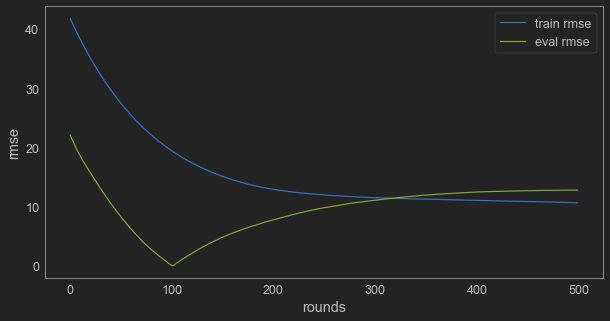

In [18]:
plt.figure(figsize=(10, 5))
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error
pred = bst.predict(dvalid)

rmse = np.sqrt(mean_squared_error(Y_train, pred))
print(rmse)

17.13167381286621


In [17]:
ttest = test.rename(columns={"Height": 0})
dtest = xgb.DMatrix(ttest)
pred = pd.DataFrame()
pred["Id"] = test_index
ans = ((bst.predict(dtest))*2.0).round(0)/2
pred["DBH"] = ans
pred.to_csv("DBH_xgb_loo.csv", index=False)